<a href="https://colab.research.google.com/github/NowshinTasnim/Spatio_Temporal_Crime_Prediction/blob/main/Crime_prediction_SF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


##Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Libraries

####install

In [ ]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=c9581085f00b4737e8da969f720d651951480adbacdf6aa0bb54287127a61ee9
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


####import

In [ ]:
# For data processing
import numpy as np
import math
from math import sqrt

# For data processing and manipulation
import pandas as pd
import csv

# For date calculations
import datetime
import time

# For ploting data
import IPython
import IPython.display

import itertools
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For checking path
import os , gc
from os import path
import csv
import json


from scipy.stats import hmean

from sklearn.metrics import mean_squared_error

#tensorflow libs
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping , Callback
import tensorflow as tf
from tensorflow.keras import backend as K
from keras import backend

from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense , LSTM ,Dropout , PReLU , RepeatVector ,TimeDistributed, Attention
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras import regularizers, constraints, initializers, activations
#from keras.layers.recurrent import Recurrent, _time_distributed_dense
from tensorflow.keras.layers import SimpleRNN as Recurrent
#from tensorflow.compat.v1.keras.layers import RNN 

from tensorflow.keras.layers import InputSpec

from keras_self_attention import SeqSelfAttention
from keras.layers.merge import concatenate


tf.get_logger().setLevel('ERROR')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

####Font

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

##Rootpath

In [ ]:
ROOTPATH = '/content/gdrive/MyDrive/Projects/Crime forcasting'

##Data Pre-processing

####Load dataset

In [ ]:
dataset = pd.read_csv(ROOTPATH+'/datasets/sf-crime/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

####DateTime

In [ ]:
# The data from 2004 to 2017 are taken
date_after = pd.to_datetime("1/1/2004  00:00:00 AM")
date_before = pd.to_datetime("1/1/2018  00:00:00 AM")

In [ ]:
dataset['datetime'] = pd.to_datetime(dataset['Date']+' '+dataset['Time'])
dataset = dataset[(dataset.datetime>=date_after) & (dataset.datetime<date_before)]
dataset = dataset.sort_values(by = ['datetime'])

# Taking the necessary existing features
dataset = dataset[["datetime","Date","Category","PdDistrict"]]

# Save the dataframe
dataset.to_csv(ROOTPATH+'/datasets/sf-crime/sf_crime_data_2004_2017.csv',index=False)

In [ ]:
# Retrieve the dataframe
dataset = pd.read_csv(ROOTPATH+'/datasets/sf-crime/sf_crime_data_2004_2017.csv')

In [ ]:
dataset.shape

(1970039, 4)

####PdDistrict

In [ ]:
# Check for null value
if(dataset['PdDistrict'].isnull().sum()>0):
  dataset = dataset.drop( index= dataset.loc[dataset['PdDistrict'].isnull()].index[0]) 
dataset['PdDistrict'].isnull().sum()

0

In [ ]:
dataset = dataset.reset_index(drop= True)

In [ ]:
# Find the uniue pdDistrict 
num_police_dept = dataset['PdDistrict'].nunique()
print("Police departement district = ",num_police_dept)
Police_dept_name = dataset['PdDistrict'].drop_duplicates().sort_values(ascending = True)
print(Police_dept_name)

Police departement district =  10
2        BAYVIEW
8        CENTRAL
0      INGLESIDE
6        MISSION
25      NORTHERN
15          PARK
10      RICHMOND
4       SOUTHERN
22       TARAVAL
33    TENDERLOIN
Name: PdDistrict, dtype: object


In [ ]:
# Dictionary for mapping id to name of the unique police department
Police_dept_id_name = {i:Police_dept_name.values[i] for i in range (num_police_dept)}
print("Police Departments ID:Name Dict-> \n",Police_dept_id_name)

# Dictionary for mapping name of the unique police department to id
Police_dept_name_id = {key:value for (value,key) in Police_dept_id_name.items()}
print("Police Departments Name:ID Dict-> \n",Police_dept_name_id)

# Update the new column of dataframe with the value of the dictionary 
dataset["PdDID"] = dataset['PdDistrict'].apply(lambda x: Police_dept_name_id[x])
print("PdDID column -> \n", dataset["PdDID"])

Police Departments ID:Name Dict-> 
 {0: 'BAYVIEW', 1: 'CENTRAL', 2: 'INGLESIDE', 3: 'MISSION', 4: 'NORTHERN', 5: 'PARK', 6: 'RICHMOND', 7: 'SOUTHERN', 8: 'TARAVAL', 9: 'TENDERLOIN'}
Police Departments Name:ID Dict-> 
 {'BAYVIEW': 0, 'CENTRAL': 1, 'INGLESIDE': 2, 'MISSION': 3, 'NORTHERN': 4, 'PARK': 5, 'RICHMOND': 6, 'SOUTHERN': 7, 'TARAVAL': 8, 'TENDERLOIN': 9}
PdDID column -> 
 0          2
1          2
2          0
3          2
4          7
          ..
1970033    3
1970034    9
1970035    9
1970036    9
1970037    7
Name: PdDID, Length: 1970038, dtype: int64


In [ ]:
# Save the dataframe
dataset.to_csv(ROOTPATH+'/datasets/sf-crime/sf_crime_data_2004_2017_pddid.csv',index=False)

In [ ]:
# Retrieve the dataframe
dataset1 = pd.read_csv(ROOTPATH+'/datasets/sf-crime/sf_crime_data_2004_2017_pddid.csv')

In [ ]:
print(dataset1.shape)

(1970038, 5)


In [ ]:
def processCategoryPd(df):
    '''
      Get the number of crimes per category on the basis of hour and unique pdDistrict.
      input:
        df  : dataframe having different crime categories for different pdDistricts.
      output:
        df  : dataframe with count per crime category based on hour and pdDistrict
        Category: mapped category 
    '''
    for col in df.columns:
        col = str(col)
        if(col=='Category'):
            continue
        if col=='datetime':
            continue
        if col=='PdDID':
            continue
        if col=='PdDistrict':
            continue
        df.drop(col , 1 , inplace=True)

    Category = np.array(df['Category'].unique() , str)
    Category.sort()
    Category = Category.tolist()
    #print(Category)
    df['Category'] = df['Category'].apply(lambda x:float(Category.index(x)))
    Y = pd.DataFrame(to_categorical(df['Category']))
    df = df.join(Y , on=Y.index)
    df['count'] = df['Category'].apply(lambda x:float(1))
    df.drop('Category' , 1, inplace=True)
    df.set_index("datetime" , inplace = True)
    df.index =  pd.to_datetime(df.index)
    #df_sample = df.resample(sample).sum()
    return df, Category

In [ ]:
df1 = processCategoryPd(dataset1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
df1 , Category1 = df1
print(df1.shape)

(1970038, 41)


In [ ]:
# get dataframe of different pdDistrict 
all_datasets = {}
for x in Police_dept_name:
    all_datasets[x] = df1[(df1.PdDistrict == x)]
    print(all_datasets[x].shape)

(191681, 41)
(204407, 41)
(169705, 41)
(266010, 41)
(244401, 41)
(110888, 41)
(104278, 41)
(360352, 41)
(144721, 41)
(173595, 41)


In [ ]:
# Save the dataframe
dataset2 = pd.read_csv(ROOTPATH+'/datasets/sf-crime/sf_crime_data_2004_2017_pddid.csv')

In [ ]:
def processCategory(df):
    '''
      Get the number of crimes per category on the basis of hour
      input:
        df  : dataframe having different crime categories for a city.
      output:
        df  : dataframe with count per crime category based on hour
        Category: mapped category 
    '''
    for col in df.columns:
        col = str(col)
        if(col=='Category'):
            continue
        if col=='datetime':
            continue
        df.drop(col , 1 , inplace=True)

    Category = np.array(df['Category'].unique() , str)
    Category.sort()
    Category = Category.tolist()
    df['Category'] = df['Category'].apply(lambda x:float(Category.index(x)))
    Y = pd.DataFrame(to_categorical(df['Category']))
    df = df.join(Y , on=Y.index)
    df['count'] = df['Category'].apply(lambda x:float(1))
    df.drop('Category' , 1, inplace=True)


    df.set_index("datetime" , inplace = True)
    df.index =  pd.to_datetime(df.index)
    return df, Category

In [ ]:
df2 = processCategory(dataset2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
df2 , Category2 = df2
df2.head()

0    1    2    3    4    5    6    7    8    9  ...  \
datetime                                                               ...   
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                      29   30   31   32   33   34   35   36   37  count  
datetime                                                                 
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1.0  
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0    1.0  
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1.0  
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1.0  
2004-01-01 00:01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1.0  

[5 rows x 39 columns]

####Temperature

In [ ]:
# Load the weather data
weather_dataset = pd.read_csv(ROOTPATH+"/datasets/sf-crime/weather_data_sf_2004_2017.csv")

In [ ]:
# Take the temperature from 2204 to 2017
temperature_dataset = pd.DataFrame(weather_dataset[["valid_date_time", "temp"]].copy())
temperature_dataset = temperature_dataset.rename(columns={"valid_date_time": "datetime","temp" : "temperature"})
temperature_dataset["datetime"] = pd.to_datetime(temperature_dataset["datetime"])
temperature_dataset = temperature_dataset.dropna()
temperature_dataset = temperature_dataset[(temperature_dataset.datetime>=date_after) & (temperature_dataset.datetime<date_before)]
temperature_dataset = temperature_dataset.drop_duplicates(subset =["datetime"])
temperature_dataset.shape

(122059, 2)

In [ ]:
# Check for null value
temperature_dataset["temperature"].isnull().sum()

0

In [ ]:
# Save the dataframe
temperature_dataset.to_csv(ROOTPATH+"/datasets/sf-crime/temp_data_sf_2004_2017.csv",index = False)

In [ ]:
temperature_dataset["temperature"].max()

38.0

In [ ]:
temperature_dataset["temperature"].min()

-12.0

####Categorical

In [ ]:
def processData(df,sample):
    '''
    Change the sorted crime category with their index value
    & Resample Date time using hour
    input:
        df  : Dataset to process
        sample  : How to resample dataset df
    output:
        df_sample : resampled dataset df
    '''

    df_sample = df.resample(sample).sum()
    return df_sample

In [ ]:
for x in Police_dept_name:
    all_datasets[x] = processData(all_datasets[x] , '1H')
    print(all_datasets[x].shape)

(122735, 40)
(122736, 40)
(122732, 40)
(122736, 40)
(122736, 40)
(122736, 40)
(122736, 40)
(122736, 40)
(122736, 40)
(122736, 40)


In [ ]:
# Assigning pdDistrict id and temperature in the categorical dataframe
for x in Police_dept_name:
    all_datasets[x]['PdDID']= Police_dept_name_id[x]
    all_datasets[x] = pd.merge(all_datasets[x] , temperature_dataset , on='datetime')
    all_datasets[x].set_index('datetime' , inplace=True)
    all_datasets[x].index = pd.to_datetime(all_datasets[x].index)

In [ ]:
for x in Police_dept_name:
    print(all_datasets[x].shape)

(122058, 41)
(122059, 41)
(122055, 41)
(122059, 41)
(122059, 41)
(122059, 41)
(122059, 41)
(122059, 41)
(122059, 41)
(122059, 41)


In [ ]:
# Assigning temperature in the dataframe
df2 = processData(df2 , '1H')
df2.index = pd.to_datetime(df2.index)
df2 = pd.merge(df2 , temperature_dataset , on='datetime')
df2.set_index('datetime' , inplace=True)
df2.index = pd.to_datetime(df2.index)

####Time to Signal

As we are trying to work with the periodical nature of crime, we are using encoded cyclic feature.

In [ ]:
def dateTimeToSignal(df):
    '''
    Converts the DateTime index to timestamp and convert it to signal (sine and cosine) to deal with periodicity
    input: 
        df : Dataset
    Output:
        df : Dataset with column Day sin , Day cos , Week sin , Week cos ,  Year sin , Year cos ; representing Sin / Cosine signal for timestamp  
    '''
    timestamp_s = df.index.map(datetime.datetime.timestamp)
    day = 24*60*60
    week = 7*day
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

    df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
    df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    return df

In [ ]:
for x in Police_dept_name:
    all_datasets[x] = dateTimeToSignal(all_datasets[x])

In [ ]:
df2 = dateTimeToSignal(df2)

In [ ]:
# Check for missing datetime and replace it with the starting date of the dataframe
date_all = df2.index
date_range = pd.date_range(date_after,date_before)
for x in Police_dept_name:
  if(len(all_datasets[x])<len(date_all)):
    print(x , len(all_datasets[x]))
    for i in date_all:
      if(i not in all_datasets[x].index):
        all_datasets[x].loc[i] = all_datasets[x].loc[date_after]
        print(all_datasets[x].loc[i])

BAYVIEW 122058
PdDID          0.000000e+00
0              0.000000e+00
1              0.000000e+00
2              0.000000e+00
3              0.000000e+00
4              0.000000e+00
5              0.000000e+00
6              0.000000e+00
7              0.000000e+00
8              0.000000e+00
9              0.000000e+00
10             0.000000e+00
11             1.000000e+00
12             3.000000e+00
13             0.000000e+00
14             0.000000e+00
15             0.000000e+00
16             1.000000e+00
17             0.000000e+00
18             0.000000e+00
19             0.000000e+00
20             1.000000e+00
21             1.000000e+00
22             0.000000e+00
23             0.000000e+00
24             0.000000e+00
25             0.000000e+00
26             0.000000e+00
27             1.000000e+00
28             0.000000e+00
29             0.000000e+00
30             0.000000e+00
31             1.000000e+00
32             0.000000e+00
33             0.000000e+00
34   

####Group Distribution

In the Dataset, there are many categories whose count is less then 100000 and the lowest count is 14. There are only 7 categories having count greater than 100000. So, we've taken this 7 categories as they are and then made 3 groups with rest of the categories. 

In [ ]:
# Group define
GROUPS = [[16],
     [21],
     [20],
     [1],
     [35],
     [7],
     [34],
     [36,4],
     [31,25,19,13],
     [12,26,37,33,23,29,27,5,8,24,6,15,17,0,9,18,30,2,11,3,10,28,14,22,32]]

In [ ]:
def make_groups(df):
    '''
    Make 10 groups from 38 different type of crime categories. 
    Where,
      GR0 consits of,
        36 	WARRANTS
        4 	BURGLARY
      GR1 consits of,
        31 	SUSPICIOUS OCC
        25 	ROBBERY
        19 	MISSING PERSON
        13 	FRAUD
      GR2 consits of,
        12 	FORGERY/COUNTERFEITING
        26 	SECONDARY CODES
        37 	WEAPON LAWS
        33 	TRESPASS
        23 	PROSTITUTION
        29 	STOLEN PROPERTY
        27 	SEX OFFENSES, FORCIBLE
        5 	DISORDERLY CONDUCT
        8 	DRUNKENNESS
        24 	RECOVERED VEHICLE
        6 	DRIVING UNDER THE INFLUENCE
        15 	KIDNAPPING
        17 	LIQUOR LAWS
        0 	ARSON
        9 	EMBEZZLEMENT
        18 	LOITERING
        30 	SUICIDE
        2 	BAD CHECKS
        11 	FAMILY OFFENSES
        3 	BRIBERY
        10 	EXTORTION
        28 	SEX OFFENSES, NON FORCIBLE
        14 	GAMBLING
        22 	PORNOGRAPHY/OBSCENE MAT
        32 	TREA

    input:
        df : Dataset with count of individual's from 38 categories
    output:
        df : Dataset with count of 10 groups  
    '''
    cnt = 0
    for i in GROUPS:
        cols_to_sum = i
        if(len(i)==1):
            continue
        else:
            newname = "GRP"+str(cnt)
            cnt = cnt + 1
            df[newname] = df[cols_to_sum].sum(axis=1)
            for j in i:
                df.drop(j , 1 , inplace=True)
    return df


In [ ]:
for x in Police_dept_name:
    all_datasets[x] = make_groups(all_datasets[x])
    all_datasets[x] = all_datasets[x].rename(columns={1:4,7: 6, 16 : 1,20 : 3,21 : 2,34 : 7,35 : 5})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
for x in Police_dept_name:
    print(all_datasets[x].shape)

(122059, 19)
(122059, 19)
(122059, 19)
(122059, 19)
(122059, 19)
(122059, 19)
(122059, 19)
(122059, 19)
(122059, 19)
(122059, 19)


In [ ]:
df2 = make_groups(df2) 
df2 = df2.rename(columns={1:4,7: 6, 16 : 1,20 : 3,21 : 2,34 : 7,35 : 5})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
df2.index = pd.to_datetime(df2.index)
df2.head()

4    6     1     3     2    7    5  count  \
datetime                                                            
2004-01-01 00:00:00  11.0  0.0  16.0  14.0  13.0  4.0  0.0  114.0   
2004-01-01 01:00:00   6.0  1.0   5.0   4.0   1.0  1.0  1.0   21.0   
2004-01-01 02:00:00   9.0  0.0   4.0   2.0   1.0  2.0  2.0   25.0   
2004-01-01 03:00:00   1.0  0.0   2.0   1.0   0.0  2.0  2.0    9.0   
2004-01-01 04:00:00   1.0  0.0   2.0   0.0   3.0  2.0  0.0   11.0   

                     temperature       Day sin   Day cos      Week sin  \
datetime                                                                 
2004-01-01 00:00:00          9.0  2.827550e-12  1.000000  4.039357e-13   
2004-01-01 01:00:00         10.0  2.588190e-01  0.965926  3.739119e-02   
2004-01-01 02:00:00         10.0  5.000000e-01  0.866025  7.473009e-02   
2004-01-01 03:00:00         11.0  7.071068e-01  0.707107  1.119645e-01   
2004-01-01 04:00:00         11.0  8.660254e-01  0.500000  1.490423e-01   

                     Week cos  Year sin  Year cos  GRP0  GRP1  GRP2  
datetime                                                             
2004-01-01 00:00:00  1.000000 -0.004215  0.999991   4.0  19.0  33.0  
2004-01-01 01:00:00  0.999301 -0.003498  0.999994   0.0   1.0   1.0  
2004-01-01 02:00:00  0.997204 -0.002781  0.999996   0.0   3.0   2.0  
2004-01-01 03:00:00  0.993712 -0.002064  0.999998   0.0   0.0   1.0  
2004-01-01 04:00:00  0.988831 -0.001348  0.999999   1.0   2.0   0.0

####Temperature mapping 

In [ ]:
def temp_scale(x):
    '''
    x <= 273K or 0C -> low(0) 
    x > 303K or 30C-> high(2)
    else medium(1)
    '''
    if(x<=0):
        return 0
    elif(x>30):
        return 2
    else:
        return 1

In [ ]:
for x in Police_dept_name:
    all_datasets[x]['temperature'] = all_datasets[x]['temperature'].apply(lambda x:temp_scale(x))

##Models

####some functions

In [ ]:
def save_history(history , path):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    # or save to csv: 
    hist_csv_file = path
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_json(f)

def get_history(path):
	with open(path) as json_file:
		data = json.load(json_file)
		return data

def save_model_weights(model , path):
  model.save_weights(path)


In [ ]:
def load_pretrained(model, name=None , pathModel = 'model_all_mae_swish' , pathHistory = 'history_all_mae_swish'):
    '''
    Load a model
    '''
    model_path = ROOTPATH+'/'+pathModel+'/'+name
    history_path = ROOTPATH+'/'+pathHistory+'/'+name+".json"

    print("Loaded Pre Trained Model")
    model = tf.keras.models.load_model(model_path)
    history = get_history(history_path)
    # model.set_weights(modelOld.get_weights())
    return model , history

In [ ]:
def MDA(y, y_hat):
    c = tf.equal(tf.sign(y[1:] - y[:-1]), tf.sign(y_hat[1:] - y_hat[:-1]))
    return tf.reduce_mean(tf.cast(c, tf.float32))

In [ ]:
def MAPE(y_true,y_pred):
  EPSILON = 0.1
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)
  upore = backend.maximum(tf.abs(y_true-y_pred),EPSILON)
  niche = backend.maximum(tf.abs(y_true),EPSILON)
  diff = tf.abs(upore/niche)
  return 100. * backend.mean(diff, axis=-1)

In [ ]:
def sMAPE(y, y_pred):
  epsilon = 0.1
  summ = backend.maximum(backend.abs(y) + backend.abs(y_pred) + epsilon, 0.5 + epsilon)
  smape = backend.abs(y_pred - y) / summ * 2.0
  return smape

In [ ]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2

In [ ]:
MAX_EPOCHS = 200
metrics_name = ["MAE" , "MSLE" , "MSE" , "R^2" , "MAPE" , "sMAPE" , "MDA"]
def compileModel(model):
  model.compile(loss=tf.losses.MeanAbsoluteError(),optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredLogarithmicError() , tf.metrics.MeanSquaredError() , R_squared , MAPE , sMAPE , MDA])
  return model

####Window generation

In [ ]:
def split_data(df):
    '''
    split the dataset ( train , val , test = (70 , 20 , 10)% )
    input:
        df : Dataset to split
    output:
        train_df : train dataset
        val_df : validation dataset
        test_df : test dataset
        num_features : Number of features in dataset
        column_indices : column_indices in dataset
    '''
    column_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    num_features = df.shape[1]
    return train_df , val_df , test_df , num_features , column_indices

In [ ]:
#@title
class WindowGenerator():
    '''
    WindowGenerator Class
    1. Split windows of features into a (features, labels) pairs.
    2. Plot the content of the resulting windows.
    3. Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets S.
    '''
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None , shuffle=False , batch_size = 64):
        '''
        The __init__ method includes all the necessary logic for the input and label indices.
        Input: 
            input_width : input width / window size 
            label_width : output width
            shift : size of window shifting forward
            train_df : train dataset
            val_df : validation dataset
            test_df : test dataset
            label_columns ( Default = None) : Label Columns
            shuffle ( Default = False) : weather to shuffle data 
            batch_size (Default = 64) : Batch Size
        Output: None
        Example :
            w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['count'])
            w2

        '''
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.shuffle = shuffle
        self.batch_size = batch_size

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}


        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) #(start , stop)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    def split_window(self, features):
        '''
        Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.
        
        Input: 
            features : Stack of array of datas , used for splitting data to inputs and labels
        Output:
            inputs : nd Array splitted as input_width
            labesl : nd Array splitted as label_width
        Example :
        # Stack three slices, the length of the total window:
            example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


            example_inputs, example_labels = w2.split_window(example_window)

            print('All shapes are: (batch, time, features)')
            print(f'Window shape: {example_window.shape}')
            print(f'Inputs shape: {example_inputs.shape}')
            print(f'labels shape: {example_labels.shape}')
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        #taking only the labels that are presentin the label_columns
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='count', max_subplots=3):
        '''
            plot method that allows a simple visualization of the split window,
            Input:
                model (Default=None) : tensorflow model to evaluate 
                plot_col ( Default = 'count') : Name of column to evaluate
                max_subplots ( Default = 3) : Maximum Number of subplotting
            Output:
                None
            Example:
                w2.plot()
                w2.plot(plot_col=0) # label wont be shown as w2 config has only column , count 

        '''
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        '''
        make_dataset method will take a time series DataFrame and convert it to a
            tf.data.Dataset of (input_window, label_window) pairs using the preprocessing.timeseries_dataset_from_array function.
        Input:
            data :  Input data to transform into (input_window , label_window)
        Output:
            ds : transformed dataset
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=self.shuffle,
            batch_size=self.batch_size,)
        ds = ds.map(self.split_window)
        return ds
    
    
    def create_dataset2(self , map_df , reshape=True):
      x = []
      y = []
      for res in iter(map_df):
        inputs, labels = res
        if(len(inputs)==64):
          x.append(inputs)
          y.append(labels)
      
      x = np.array(x)
      y = np.array(y)
      if(reshape):
        x = x.reshape(-1, x.shape[-2] , x.shape[-1])
        y = y.reshape(-1 , y.shape[-2] , y.shape[-1])
      return x , y
    
    '''
    properties for accessing  training, validation and test data as tf.data.Datasets using the above make_dataset method.
    Also a standard example batch for easy access and plotting
    '''

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [ ]:
def create_data(train , test , val , columns):
    '''
    Create dataset from main train , test , val with given columns
    '''
    if(columns==None):
        columns = train.columns
    new_train = train[columns]
    new_test = test[columns]
    new_val = val[columns]
    return new_train , new_test , new_val

In [ ]:
general_indexs = ['PdDID' , 1,2,3,4,5,6,7,'count','temperature','Day sin','Day cos','Week sin','Week cos','Year sin','Year cos','GRP0','GRP1','GRP2']
x_col = ['Day sin' , 'Day cos' , 'Year sin' , 'Year cos' , 'Week cos' , 'Week sin' ,'temperature' , 'datetime' , 'PdDID']
def generate_window(df_now, ret_test = 0):
    train_df , val_df , test_df , num_features_df , column_indices_df = split_data(df_now)
    train_df , test_df , val_df = create_data(train_df , test_df , val_df , general_indexs)
    y_col = [] 

    for i in train_df.columns:
        if (i in x_col):
            continue
        y_col.append(i)
    wide_window_all = WindowGenerator(train_df=train_df, test_df=test_df , val_df=val_df, 
        input_width=24, label_width=24, shift=1,
        label_columns=y_col)
    
    if (ret_test == 1):
      return wide_window_all, test_df
    else:  
      return wide_window_all   

In [ ]:
general_indexs2 = [ 1,2,3,4,5,6,7,'count', 'Day sin' , 'Day cos' , 'Week cos' , 'Week sin', 'Year sin' , 'Year cos' , 'GRP0','GRP1','GRP2']
x_col2 = ['Day sin' , 'Day cos' , 'Year sin' , 'Year cos' , 'Week cos' , 'Week sin' , 'datetime']
def generate_window2(df_now):
    train_df , val_df , test_df , num_features_df , column_indices_df = split_data(df_now)
    train_df , test_df , val_df = create_data(train_df , test_df , val_df , general_indexs2)
    
    y_col = []
    for i in train_df.columns:
        if(i in x_col2):
            continue
        y_col.append(i)
    wide_window_all = WindowGenerator(train_df=train_df, test_df=test_df , val_df=val_df, input_width=24, label_width=24, shift=1, label_columns=y_col)
    
    return wide_window_all    

####ATTN_Bi


In [ ]:
# not trainable Attn_LSTM model 
input_attn_lstm = keras.Input(shape=(24,19), name="input_attn")
x_attn = (tf.keras.layers.LSTM(128, activation = tf.keras.activations.swish ,return_sequences=True, name= "LSTM", trainable = False))(input_attn_lstm)
x_attn = (SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, attention_activation='swish', name='Attention', trainable = False))(x_attn)
x_attn = (TimeDistributed(keras.layers.Dense(units=64, activation = tf.keras.activations.swish, trainable = False), name="TimeDisDense1"))(x_attn)
output_attn_lstm = (keras.layers.Dense(units=11))(x_attn)

attn_lstm_model_all_feature = keras.Model(
    inputs=[input_attn_lstm],
    outputs=[output_attn_lstm],
)

# not trainable St-Bi-LSTM model
input_bd_td_lstm = keras.Input(shape=(24,17), name="input_bd")
x_bd = (keras.layers.Bidirectional(keras.layers.LSTM(128, activation = tf.keras.activations.swish ,return_sequences=True, trainable = False), name="Bi-LSTM1"))(input_bd_td_lstm)
x_bd = (keras.layers.Bidirectional(keras.layers.LSTM(64, activation = tf.keras.activations.swish ,return_sequences=True, trainable = False), name="Bi-LSTM2"))(x_bd)
x_bd = (keras.layers.TimeDistributed(keras.layers.Dense(units=64, activation = tf.keras.activations.swish, trainable = False),name="TimeDisDense2"))(x_bd)
output_bd_td_lstm = (keras.layers.TimeDistributed(keras.layers.Dense(units=11)))(x_bd)

bd_td_lstm_model_common_feature = keras.Model(
    inputs=[input_bd_td_lstm],
    outputs=[output_bd_td_lstm],
)


In [ ]:
histories = {}

In [ ]:
# Load Attn_LSTM MODEL
val_performance_attn_all = {}
performance_attn_all = {}
attn_lstm_model_all_feature = compileModel(attn_lstm_model_all_feature)
print(attn_lstm_model_all_feature.metrics_names)
for x in Police_dept_name:
    wide_window_all = generate_window(all_datasets[x])
    
    attn_lstm_model_all_feature , histories['Attn_LSTM_all_feature_'+x]  = load_pretrained(attn_lstm_model_all_feature, 
                                                             name='Attn_LSTM_all_feature_'+x , 
                                                             pathModel='model_all_mae_swish',
                                                             pathHistory='history_all_mae_swish')
    attn_lstm_model_all_feature = compileModel(attn_lstm_model_all_feature)
    
    val_performance_attn_all[x] = attn_lstm_model_all_feature.evaluate(wide_window_all.val)
    performance_attn_all[x] = attn_lstm_model_all_feature.evaluate(wide_window_all.test)

    IPython.display.clear_output()

In [ ]:
print(f'{"model":50s}: Test   | Val')
for i in range(len(metrics_name)):
  print("==================",metrics_name[i],"==================")
  for key in performance_attn_all.keys():
    print(f'{key:50s}: {performance_attn_all[key][i]:0.4f} | {val_performance_attn_all[key][i]:0.4f}')

model                                             : Test   | Val
================== MAE ==================
BAYVIEW                                           : 0.0199 | 0.0207
CENTRAL                                           : 0.0245 | 0.0242
INGLESIDE                                         : 0.0162 | 0.0184
MISSION                                           : 0.0884 | 0.0804
NORTHERN                                          : 0.0465 | 0.0424
PARK                                              : 0.0217 | 0.0251
RICHMOND                                          : 0.0152 | 0.0149
SOUTHERN                                          : 0.0352 | 0.0391
TARAVAL                                           : 0.0195 | 0.0204
TENDERLOIN                                        : 0.0140 | 0.0172
================== MSLE ==================
BAYVIEW                                           : 0.0061 | 0.0061
CENTRAL                                           : 0.0067 | 0.0064
INGLESIDE                         

In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_attn_all.keys():
    print(f'{key:50s}: {performance_attn_all[key][0]:0.4f} | {val_performance_attn_all[key][0]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.0199 | 0.0207
CENTRAL                                           : 0.0245 | 0.0242
INGLESIDE                                         : 0.0162 | 0.0184
MISSION                                           : 0.0884 | 0.0804
NORTHERN                                          : 0.0465 | 0.0424
PARK                                              : 0.0217 | 0.0251
RICHMOND                                          : 0.0152 | 0.0149
SOUTHERN                                          : 0.0352 | 0.0391
TARAVAL                                           : 0.0195 | 0.0204
TENDERLOIN                                        : 0.0140 | 0.0172


In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_attn_all.keys():
    print(f'{key:50s}: {performance_attn_all[key][1]:0.4f} | {val_performance_attn_all[key][1]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.0061 | 0.0061
CENTRAL                                           : 0.0067 | 0.0064
INGLESIDE                                         : 0.0051 | 0.0055
MISSION                                           : 0.0270 | 0.0242
NORTHERN                                          : 0.0108 | 0.0098
PARK                                              : 0.0057 | 0.0063
RICHMOND                                          : 0.0044 | 0.0041
SOUTHERN                                          : 0.0082 | 0.0086
TARAVAL                                           : 0.0058 | 0.0055
TENDERLOIN                                        : 0.0039 | 0.0047


In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_attn_all.keys():
    print(f'{key:50s}: {performance_attn_all[key][2]:0.4f} | {val_performance_attn_all[key][2]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.0271 | 0.0272
CENTRAL                                           : 0.0584 | 0.0336
INGLESIDE                                         : 0.0217 | 0.0239
MISSION                                           : 0.1246 | 0.1118
NORTHERN                                          : 0.1157 | 0.0579
PARK                                              : 0.0217 | 0.0255
RICHMOND                                          : 0.0177 | 0.0157
SOUTHERN                                          : 0.0591 | 0.0801
TARAVAL                                           : 0.0909 | 0.1072
TENDERLOIN                                        : 0.0153 | 0.0207


In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_attn_all.keys():
    print(f'{key:50s}: {performance_attn_all[key][3]:0.4f} | {val_performance_attn_all[key][3]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.9567 | 0.9569
CENTRAL                                           : 0.9580 | 0.9625
INGLESIDE                                         : 0.9544 | 0.9560
MISSION                                           : 0.8928 | 0.8863
NORTHERN                                          : 0.9276 | 0.9425
PARK                                              : 0.9316 | 0.9294
RICHMOND                                          : 0.9533 | 0.9530
SOUTHERN                                          : 0.9683 | 0.9629
TARAVAL                                           : 0.9347 | 0.9171
TENDERLOIN                                        : 0.9582 | 0.9583


In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_attn_all.keys():
    print(f'{key:50s}: {performance_attn_all[key][4]:0.4f} | {val_performance_attn_all[key][4]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 85.8716 | 85.8055
CENTRAL                                           : 83.7842 | 83.6623
INGLESIDE                                         : 87.7714 | 86.6733
MISSION                                           : 87.8832 | 90.1306
NORTHERN                                          : 88.0657 | 87.4981
PARK                                              : 94.3035 | 94.1814
RICHMOND                                          : 89.9651 | 90.4335
SOUTHERN                                          : 79.2216 | 79.5823
TARAVAL                                           : 90.2422 | 90.8340
TENDERLOIN                                        : 90.4363 | 88.8517


In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_attn_all.keys():
    print(f'{key:50s}: {performance_attn_all[key][5]:0.4f} | {val_performance_attn_all[key][5]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.0277 | 0.0289
CENTRAL                                           : 0.0293 | 0.0307
INGLESIDE                                         : 0.0228 | 0.0257
MISSION                                           : 0.1189 | 0.1122
NORTHERN                                          : 0.0507 | 0.0512
PARK                                              : 0.0339 | 0.0387
RICHMOND                                          : 0.0223 | 0.0229
SOUTHERN                                          : 0.0377 | 0.0404
TARAVAL                                           : 0.0246 | 0.0261
TENDERLOIN                                        : 0.0227 | 0.0261


In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_attn_all.keys():
    print(f'{key:50s}: {performance_attn_all[key][6]:0.4f} | {val_performance_attn_all[key][6]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.2577 | 0.2599
CENTRAL                                           : 0.2727 | 0.2763
INGLESIDE                                         : 0.2239 | 0.2408
MISSION                                           : 0.3228 | 0.3006
NORTHERN                                          : 0.2953 | 0.2922
PARK                                              : 0.1768 | 0.1866
RICHMOND                                          : 0.1833 | 0.1765
SOUTHERN                                          : 0.3616 | 0.3589
TARAVAL                                           : 0.2217 | 0.2155
TENDERLOIN                                        : 0.1877 | 0.2158


In [ ]:
# Load St-Bi-LSTM model
val_performance_bd = {}
performance_bd = {}
wide_window2 = generate_window2(df2)

bd_td_lstm_model_common_feature = compileModel(bd_td_lstm_model_common_feature)

bd_td_lstm_model_common_feature , history_bd  = load_pretrained(bd_td_lstm_model_common_feature, name='bd_td_LSTM_common_feature',
                                                                pathModel='model_common_mae_swish' , 
                                                                pathHistory='history_common_mae_swish')
IPython.display.clear_output()
print("Model is Loaded!!")


bd_td_lstm_model_common_feature = compileModel(bd_td_lstm_model_common_feature)

val_performance_bd['bd_td_LSTM_common_feature'] = bd_td_lstm_model_common_feature.evaluate(wide_window2.val)
performance_bd['bd_td_LSTM_common_feature'] = bd_td_lstm_model_common_feature.evaluate(wide_window2.test)

Model is Loaded!!
191/191 [==============================] - 14s 72ms/step - loss: 0.1220 - mean_squared_logarithmic_error: 0.0130 - mean_squared_error: 0.2519 - R_squared: 0.9921 - MAPE: 47.1619 - sMAPE: 0.1035 - MDA: 0.7048


In [ ]:
# merged model architecture
x_merged = concatenate([x_attn, x_bd], axis=-1)
x_merged = (TimeDistributed(tf.keras.layers.Dense(units=64, activation = tf.keras.activations.swish , name= "Mered_model_Dense")))(x_merged)
x_merged = (tf.keras.layers.Dense(units=11))(x_merged)

merged_model = keras.Model(
    inputs = [input_attn_lstm, input_bd_td_lstm],
    outputs = [x_merged],
)

In [ ]:
merged_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_attn (InputLayer)        [(None, 24, 19)]     0           []                               
                                                                                                  
 input_bd (InputLayer)          [(None, 24, 17)]     0           []                               
                                                                                                  
 LSTM (LSTM)                    (None, 24, 128)      75776       ['input_attn[0][0]']             
                                                                                                  
 Bi-LSTM1 (Bidirectional)       (None, 24, 256)      149504      ['input_bd[0][0]']               
                                                                                            

In [ ]:
val_performance = {}
performance = {}
wide_window2 = generate_window2(df2)
X_train2 , Y_train2 = wide_window2.create_dataset2(wide_window2.train)
X_val2 , Y_val2 = wide_window2.create_dataset2(wide_window2.val)
X_test2, Y_test2 = wide_window2.create_dataset2(wide_window2.test)

In [ ]:
merged_model = compileModel(merged_model)
for x in Police_dept_name:
    wide_window_all = generate_window(all_datasets[x])

    X_train1 , Y_train1 = wide_window_all.create_dataset2(wide_window_all.train)
    X_val1 , Y_val1 = wide_window_all.create_dataset2(wide_window_all.val)
    X_test1, Y_test1 = wide_window_all.create_dataset2(wide_window_all.test)
    print(x)
    
    merged_model , histories['Merged_model_'+x]  = load_pretrained(merged_model, name = 'Merged_model_'+x , 
                                              pathModel='model_merged_attn_bi_mae_swish_new',
                                              pathHistory='history_merged_attn_bi_mae_swish')
    merged_model = compileModel(merged_model)
    
    val_performance[x] = merged_model.evaluate([X_val1, X_val2], Y_val1)
    performance[x] = merged_model.evaluate([X_test1,X_test2], Y_test1)
    IPython.display.clear_output()
print("Model is trained")

Model is trained


In [ ]:
print(f'{"model":50s}: Test   | Val')
for i in range(len(metrics_name)):
  print("==================",metrics_name[i],"==================")
  for key in performance.keys():
    print(f'{key:50s}: {performance[key][i]:0.4f} | {val_performance[key][i]:0.4f}')
  # print("====================================")

model                                             : Test   | Val
================== MAE ==================
BAYVIEW                                           : 0.2509 | 0.2498
CENTRAL                                           : 0.3133 | 0.3002
INGLESIDE                                         : 0.2092 | 0.2236
MISSION                                           : 0.3843 | 0.3164
NORTHERN                                          : 0.3198 | 0.3078
PARK                                              : 0.1595 | 0.1717
RICHMOND                                          : 0.1742 | 0.1616
SOUTHERN                                          : 0.4067 | 0.4079
TARAVAL                                           : 0.2095 | 0.7191
TENDERLOIN                                        : 0.1726 | 0.2053
================== MSLE ==================
BAYVIEW                                           : 0.1075 | 0.1070
CENTRAL                                           : 0.1344 | 0.1280
INGLESIDE                         

##BiLSTM-ATTN


In [ ]:
# not trainable Attn_LSTM model 
input_attn_lstm2 = keras.Input(shape=(24,17), name="input_attn")
x2_attn = (tf.keras.layers.LSTM(128, activation = tf.keras.activations.swish ,return_sequences=True, name= "LSTM"))(input_attn_lstm2)
x2_attn = (SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, attention_activation='swish', name='Attention'))(x2_attn)
x2_attn = (TimeDistributed(keras.layers.Dense(units=64, activation = tf.keras.activations.swish), name="TimeDisDense1"))(x2_attn)
output_attn_lstm2 = (keras.layers.Dense(units=11))(x2_attn)

attn_lstm_model_common_feature = keras.Model(
    inputs=[input_attn_lstm2],
    outputs=[output_attn_lstm2],
)

# not trainable St-Bi-LSTM model
input_bd_td_lstm2 = keras.Input(shape=(24,19), name="input_bd")
x2_bd = (keras.layers.Bidirectional(keras.layers.LSTM(128, activation = tf.keras.activations.swish ,return_sequences=True), name="Bi-LSTM1"))(input_bd_td_lstm2)
x2_bd = (keras.layers.Bidirectional(keras.layers.LSTM(64, activation = tf.keras.activations.swish ,return_sequences=True), name="Bi-LSTM2"))(x2_bd)
x2_bd = (keras.layers.TimeDistributed(keras.layers.Dense(units=64, activation = tf.keras.activations.swish),name="TimeDisDense2"))(x2_bd)
output_bd_td_lstm2 = (keras.layers.TimeDistributed(keras.layers.Dense(units=11)))(x2_bd)

bd_td_lstm_model_all_feature = keras.Model(
    inputs=[input_bd_td_lstm2],
    outputs=[output_bd_td_lstm2],
)

In [ ]:
# Load Attn_LSTM MODEL
val_performance_attn = {}
performance_attn = {}
wide_window2 = generate_window2(df2)
attn_lstm_model_common_feature = compileModel(attn_lstm_model_common_feature)

attn_lstm_model_common_feature , history_attn  = load_pretrained(attn_lstm_model_common_feature, name='attn_LSTM_common_feature', pathModel='model_commonAttn_mae_swish' , pathHistory='history_commonAttn_mae_swish')
IPython.display.clear_output()
print("Model is Loaded!!")

attn_lstm_model_common_feature = compileModel(attn_lstm_model_common_feature)

val_performance_attn['attn_LSTM_cf'] = attn_lstm_model_common_feature.evaluate(wide_window2.val)
performance_attn['attn_LSTM_cf'] = attn_lstm_model_common_feature.evaluate(wide_window2.test)


Model is Loaded!!
191/191 [==============================] - 6s 31ms/step - loss: 0.1185 - mean_squared_logarithmic_error: 0.0194 - mean_squared_error: 0.3743 - R_squared: 0.9883 - MAPE: 48.1464 - sMAPE: 0.0860 - MDA: 0.7006


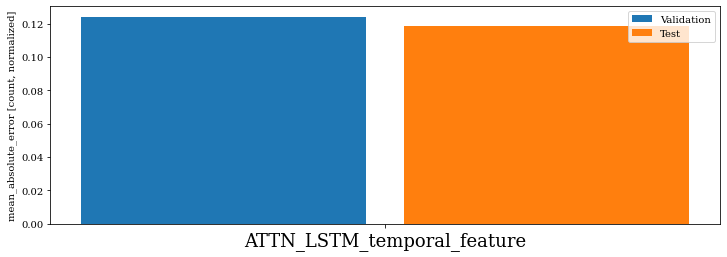

In [ ]:
# Visualize the Attn_LSTM model for checking
plt.figure(figsize=(12, 4))
x = np.arange(len(performance_attn))
width = 0.3
metric_name = 'loss'
metric_index = attn_lstm_model_common_feature.metrics_names.index(metric_name)

label = ['ATTN_LSTM_temporal_feature']
val_mae = [v[metric_index] for v in val_performance_attn.values()]
test_mae = [v[metric_index] for v in performance_attn.values()]

plt.ylabel('mean_absolute_error [count, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=label, fontsize = 18)
_ = plt.legend()

In [ ]:
# Load St-Bi-LSTM model

#  {0: 'BAYVIEW', 1: 'CENTRAL', 2: 'INGLESIDE', 3: 'MISSION', 4: 'NORTHERN', 5: 'PARK', 6: 'RICHMOND', 7: 'SOUTHERN', 8: 'TARAVAL', 9: 'TENDERLOIN'}
val_performance_bd = {}
performance_bd = {}
bd_td_lstm_model_all_feature = compileModel(bd_td_lstm_model_all_feature)
for x in Police_dept_name:
    wide_window_all = generate_window(all_datasets[x])
    print(x)
    bd_td_lstm_model_all_feature , histories['BiLSTM_all_feature_'+x]  = load_pretrained(bd_td_lstm_model_all_feature, name='BiLSTM_all_feature_'+x, pathModel='model_allBi_mae_swish' , pathHistory='history_allBi_mae_swish')
    
    bd_td_lstm_model_all_feature = compileModel(bd_td_lstm_model_all_feature)
    val_performance_bd[x] = bd_td_lstm_model_all_feature.evaluate(wide_window_all.val)
    performance_bd[x] = bd_td_lstm_model_all_feature.evaluate(wide_window_all.test)

    IPython.display.clear_output()

In [ ]:
print(f'{"model":50s}: Test   | Val')
for i in range(len(metrics_name)):
  print("==================",metrics_name[i],"==================")
  for key in val_performance_bd.keys():
    print(f'{key:50s}: {performance_bd[key][i]:0.4f} | {val_performance_bd[key][i]:0.4f}')
  # print("====================================")

model                                             : Test   | Val
================== MAE ==================
BAYVIEW                                           : 0.0224 | 0.0244
CENTRAL                                           : 0.0282 | 0.0283
INGLESIDE                                         : 0.0198 | 0.0229
MISSION                                           : 0.0234 | 0.0213
NORTHERN                                          : 0.0229 | 0.0215
PARK                                              : 0.0112 | 0.0127
RICHMOND                                          : 0.0125 | 0.0118
SOUTHERN                                          : 0.0316 | 0.0332
TARAVAL                                           : 0.0164 | 0.0169
TENDERLOIN                                        : 0.0154 | 0.0192
================== MSLE ==================
BAYVIEW                                           : 0.0048 | 0.0048
CENTRAL                                           : 0.0059 | 0.0056
INGLESIDE                         

In [ ]:
# val_performance_bd = {}
# # performance_bd = {}

In [ ]:
# # Load St-Bi-LSTM model
# for x in Police_dept_name:
#     wide_window_all = generate_window(all_datasets[x])
#     print(x)
#     # bd_td_lstm_model_all_feature , history  = compile_and_fit(bd_td_lstm_model_all_feature, window= wide_window_all, name='BiLSTM_all_feature_'+x, stream = 1)
    
#     val_performance_bd['StBiLSTM_all_feature_'+x] = bd_td_lstm_model_all_feature.evaluate(wide_window_all.val)
#     performance_bd['StBiLSTM_all_feature_'+x] = bd_td_lstm_model_all_feature.evaluate(wide_window_all.test)

#     # IPython.display.clear_output()

In [ ]:
# Fusion model architecture
x2_merged = concatenate([x2_bd, x2_attn], axis=-1)
x2_merged = (TimeDistributed(tf.keras.layers.Dense(units=64, activation = tf.keras.activations.swish , name= "Merged_swap_model_Dense")))(x2_merged)
x2_merged = (tf.keras.layers.Dense(units=11))(x2_merged)

merged_model_swap = keras.Model(
    inputs = [input_bd_td_lstm2, input_attn_lstm2],
    outputs = [x2_merged],
)
merged_model_swap.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_bd (InputLayer)          [(None, 24, 19)]     0           []                               
                                                                                                  
 input_attn (InputLayer)        [(None, 24, 17)]     0           []                               
                                                                                                  
 Bi-LSTM1 (Bidirectional)       (None, 24, 256)      151552      ['input_bd[0][0]']               
                                                                                                  
 LSTM (LSTM)                    (None, 24, 128)      74752       ['input_attn[0][0]']             
                                                                                            

In [ ]:
val_performance_swap = {}
performance_swap = {}

wide_window2 = generate_window2(df2)
X_train2 , Y_train2 = wide_window2.create_dataset2(wide_window2.train)
X_val2 , Y_val2 = wide_window2.create_dataset2(wide_window2.val)
X_test2, Y_test2 = wide_window2.create_dataset2(wide_window2.test)

In [ ]:
merged_model_swap = compileModel(merged_model_swap)
for x in Police_dept_name:
    wide_window_all = generate_window(all_datasets[x])
    
    X_train1 , Y_train1 = wide_window_all.create_dataset2(wide_window_all.train)
    X_val1 , Y_val1 = wide_window_all.create_dataset2(wide_window_all.val)
    X_test1, Y_test1 = wide_window_all.create_dataset2(wide_window_all.test)
    
    print(x)
    
    merged_model_swap , histories['Merged_model_swap'+x]  = load_pretrained(merged_model_swap, name = 'Merged_model_'+x , 
                                                   pathModel='model_merged_BiAttn_mae_swish' , pathHistory='history_merged_BiAttn_mae_swish')
    merged_model_swap = compileModel(merged_model_swap)
    val_performance_swap[x] = merged_model_swap.evaluate([X_val1, X_val2], Y_val1)
    performance_swap[x] = merged_model_swap.evaluate([X_test1,X_test2], Y_test1)
    IPython.display.clear_output()
print("Model is trained")


Model is trained


In [ ]:
print(f'{"model":50s}: Test   | Val')
for i in range(len(metrics_name)):
  print("==================",metrics_name[i],"==================")
  for key in val_performance_swap.keys():
    print(f'{key:50s}: {performance_swap[key][i]:0.4f} | {val_performance_swap[key][i]:0.4f}')
  # print("====================================")

model                                             : Test   | Val
================== MAE ==================
BAYVIEW                                           : 0.0212 | 0.0213
CENTRAL                                           : 0.0247 | 0.0232
INGLESIDE                                         : 0.0150 | 0.0166
MISSION                                           : 0.0258 | 0.0229
NORTHERN                                          : 0.0235 | 0.0215
PARK                                              : 0.0101 | 0.0111
RICHMOND                                          : 0.0109 | 0.0101
SOUTHERN                                          : 0.0288 | 0.0299
TARAVAL                                           : 0.0133 | 0.0127
TENDERLOIN                                        : 0.0110 | 0.0132
================== MSLE ==================
BAYVIEW                                           : 0.0048 | 0.0048
CENTRAL                                           : 0.0060 | 0.0057
INGLESIDE                         

In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_swap.keys():
    print(f'{key:50s}: {performance_swap[key][0]:0.4f} | {val_performance_swap[key][0]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.0212 | 0.0213
CENTRAL                                           : 0.0247 | 0.0232
INGLESIDE                                         : 0.0150 | 0.0166
MISSION                                           : 0.0258 | 0.0229
NORTHERN                                          : 0.0235 | 0.0215
PARK                                              : 0.0101 | 0.0111
RICHMOND                                          : 0.0109 | 0.0101
SOUTHERN                                          : 0.0288 | 0.0299
TARAVAL                                           : 0.0133 | 0.0127
TENDERLOIN                                        : 0.0110 | 0.0132


In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_swap.keys():
    print(f'{key:50s}: {performance_swap[key][1]:0.4f} | {val_performance_swap[key][1]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.0048 | 0.0048
CENTRAL                                           : 0.0060 | 0.0057
INGLESIDE                                         : 0.0039 | 0.0042
MISSION                                           : 0.0069 | 0.0060
NORTHERN                                          : 0.0066 | 0.0060
PARK                                              : 0.0030 | 0.0032
RICHMOND                                          : 0.0032 | 0.0030
SOUTHERN                                          : 0.0067 | 0.0069
TARAVAL                                           : 0.0039 | 0.0037
TENDERLOIN                                        : 0.0033 | 0.0039


In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_swap.keys():
    print(f'{key:50s}: {performance_swap[key][2]:0.4f} | {val_performance_swap[key][2]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.0212 | 0.0210
CENTRAL                                           : 0.0352 | 0.0289
INGLESIDE                                         : 0.0167 | 0.0189
MISSION                                           : 0.0354 | 0.0299
NORTHERN                                          : 0.0373 | 0.0309
PARK                                              : 0.0109 | 0.0126
RICHMOND                                          : 0.0130 | 0.0115
SOUTHERN                                          : 0.0428 | 0.0466
TARAVAL                                           : 0.0173 | 0.0161
TENDERLOIN                                        : 0.0128 | 0.0170


In [ ]:
print(f'{"model":50s}: Test   | Val')
for key in performance_swap.keys():
    print(f'{key:50s}: {performance_swap[key][3]:0.4f} | {val_performance_swap[key][3]:0.4f}')

model                                             : Test   | Val
BAYVIEW                                           : 0.9663 | 0.9663
CENTRAL                                           : 0.9673 | 0.9676
INGLESIDE                                         : 0.9651 | 0.9651
MISSION                                           : 0.9691 | 0.9685
NORTHERN                                          : 0.9689 | 0.9691
PARK                                              : 0.9649 | 0.9647
RICHMOND                                          : 0.9652 | 0.9650
SOUTHERN                                          : 0.9765 | 0.9761
TARAVAL                                           : 0.9657 | 0.9652
TENDERLOIN                                        : 0.9643 | 0.9653


In [ ]:
# visualize results of model for checking
def plotLoss(model , performance_data , validation_data , metric_name , model_name, ylabel='mean_absolute_error [count, normalized]'):
  plt.figure(figsize=(20, 9))
  x = np.arange(len(performance_data))
  width = 0.3
  metric_index = model.metrics_names.index(metric_name)
  
  val_mae = [v[metric_index] for v in validation_data.values()]
  test_mae = [v[metric_index] for v in performance_data.values()]
  plt.ylabel(ylabel , fontsize = 25)
  plt.bar(x - 0.17, val_mae, width, label='Validation')
  plt.bar(x + 0.17, test_mae, width, label='Test')
  plt.xticks(ticks=x, labels=performance_data.keys(),
           rotation=90,fontsize = 25)
  locs , labels = plt.yticks()
  plt.yticks(ticks=locs , fontsize=25)
  plt.xlabel(model_name)
  _ = plt.legend(prop={'size': 25})

In [ ]:
merged_model.metrics_names

['loss',
 'mean_squared_logarithmic_error',
 'mean_squared_error',
 'R_squared',
 'MAPE',
 'sMAPE',
 'MDA']

In [ ]:
trained_models = [merged_model , attn_lstm_model_all_feature , bd_td_lstm_model_all_feature , merged_model_swap]
performance_datas = [performance , performance_attn_all , performance_bd , performance_swap]
val_performance_datas = [val_performance , val_performance_attn_all , val_performance_bd , val_performance_swap]
names = ['merged_model_bi_attn' , 'attn_lstm_model_all_feature' , 'bd_td_lstm_model_all_feature' , 'fusion']
ylabels = ['mean_absolute_error' , 'mean_squared_logarithmic_error','mean_squared_error' , 'rsquared' , 'mape' , 'smape' , 'mad']

merged_model_bi_attn
attn_lstm_model_all_feature
bd_td_lstm_model_all_feature


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


fusion


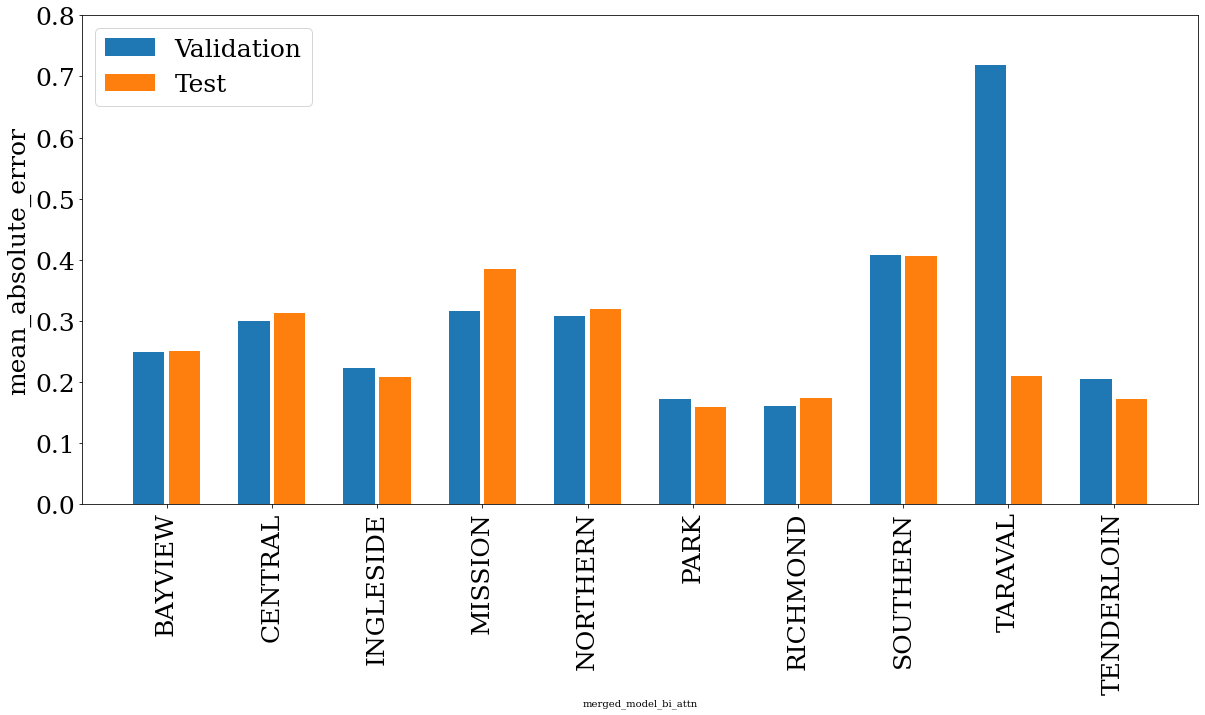

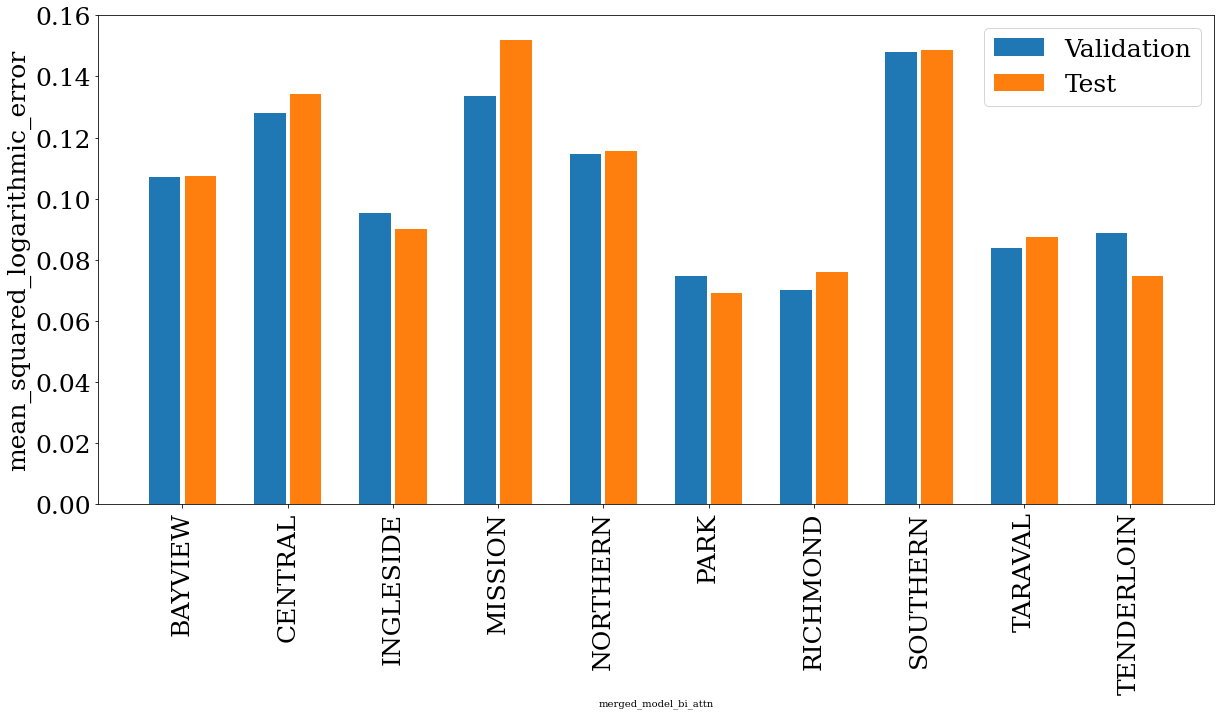

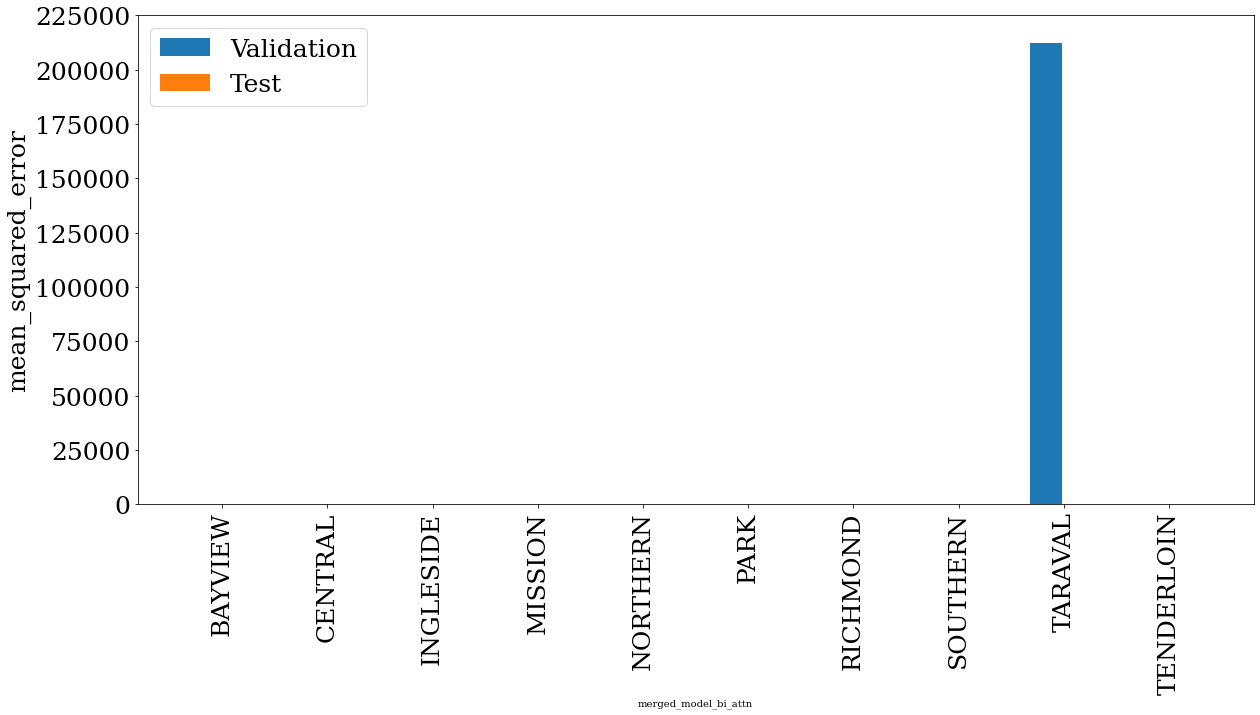

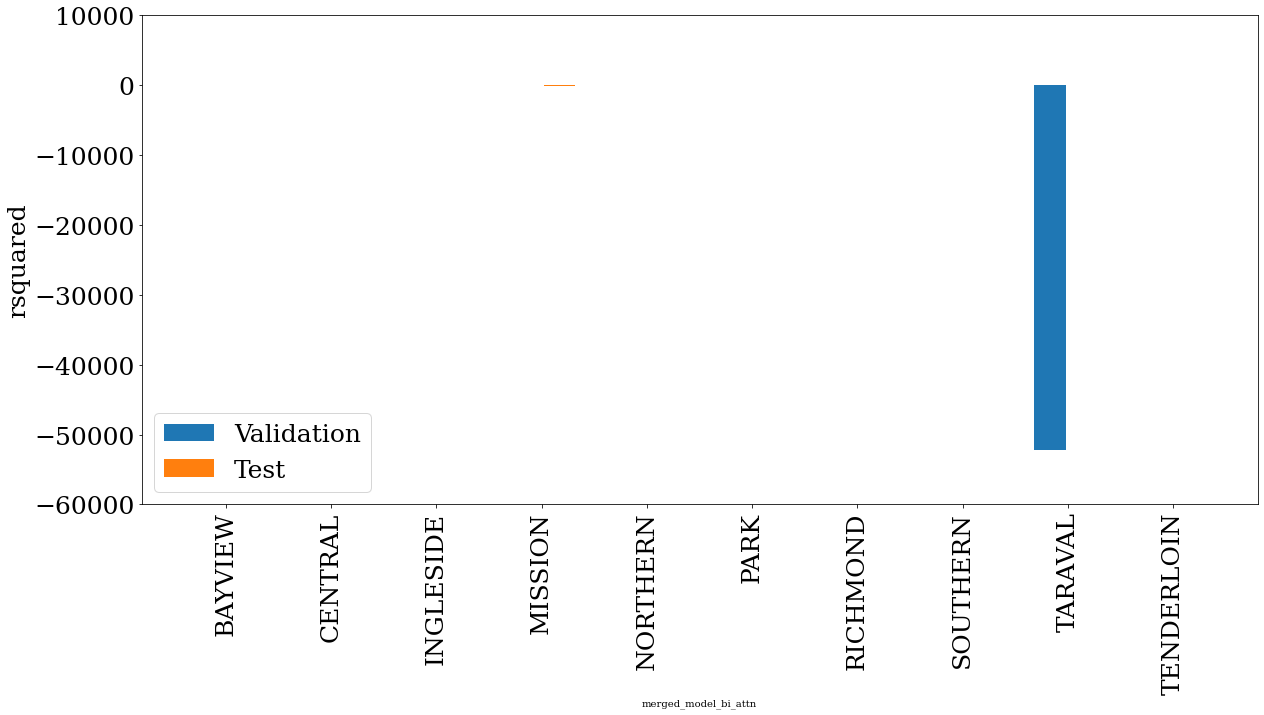

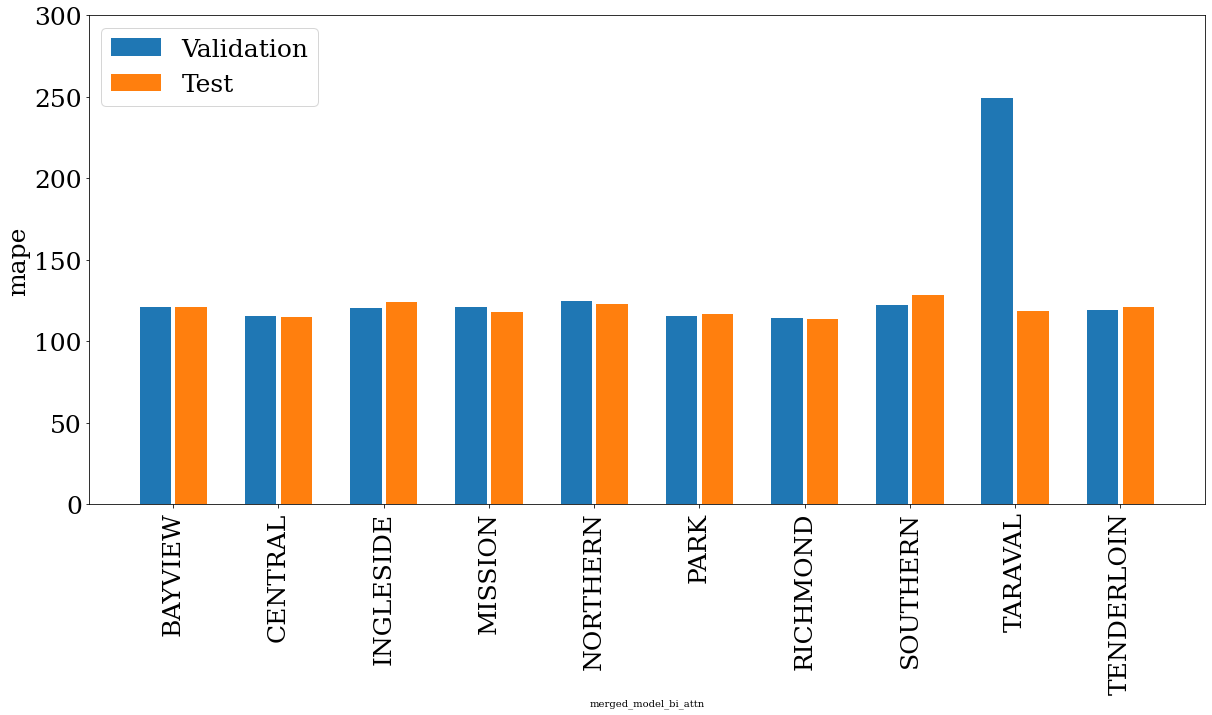

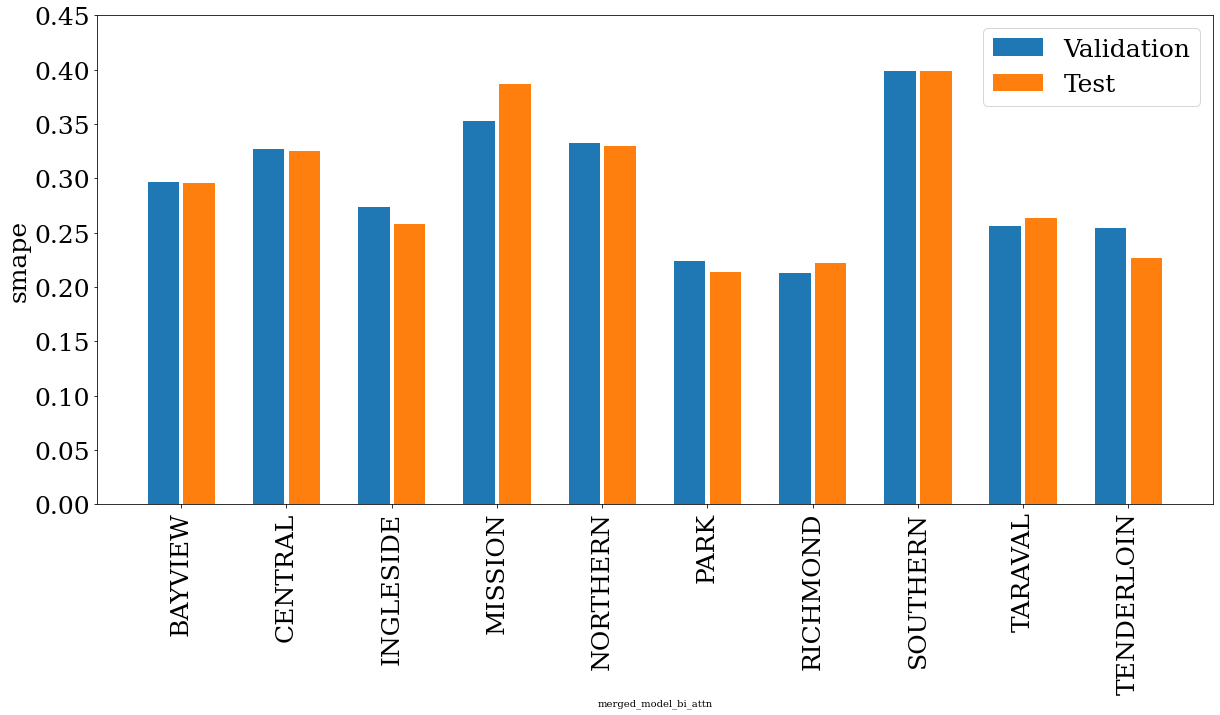

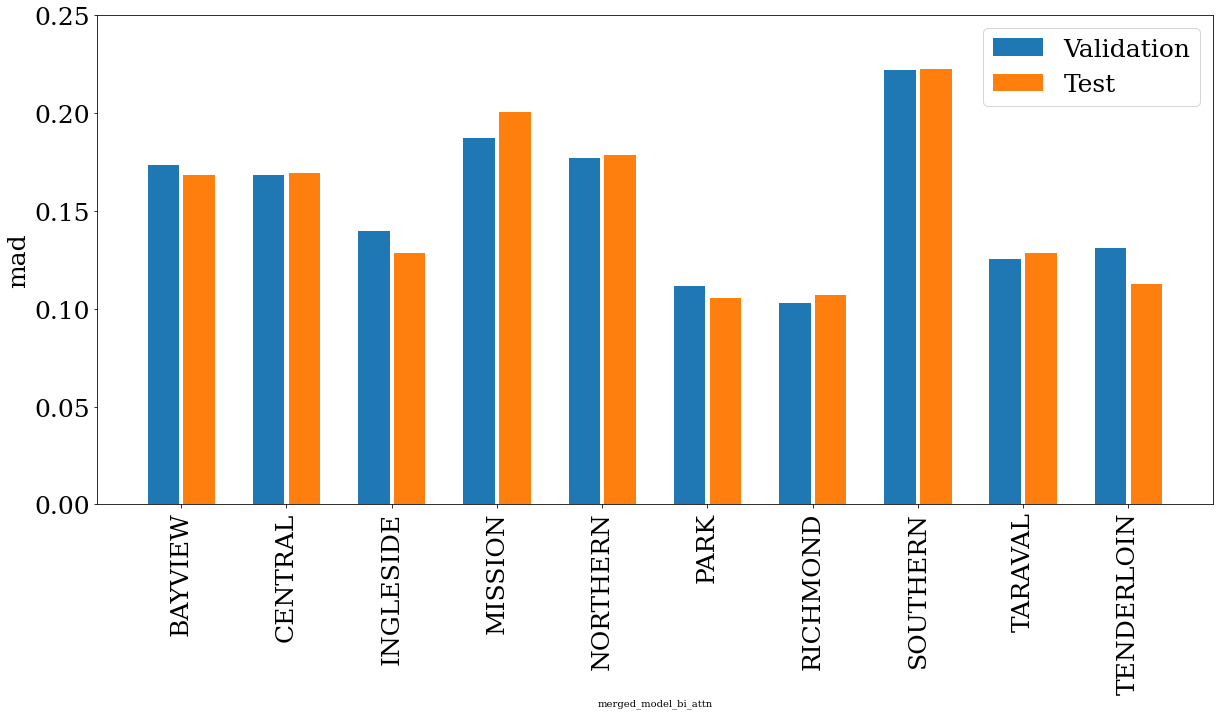

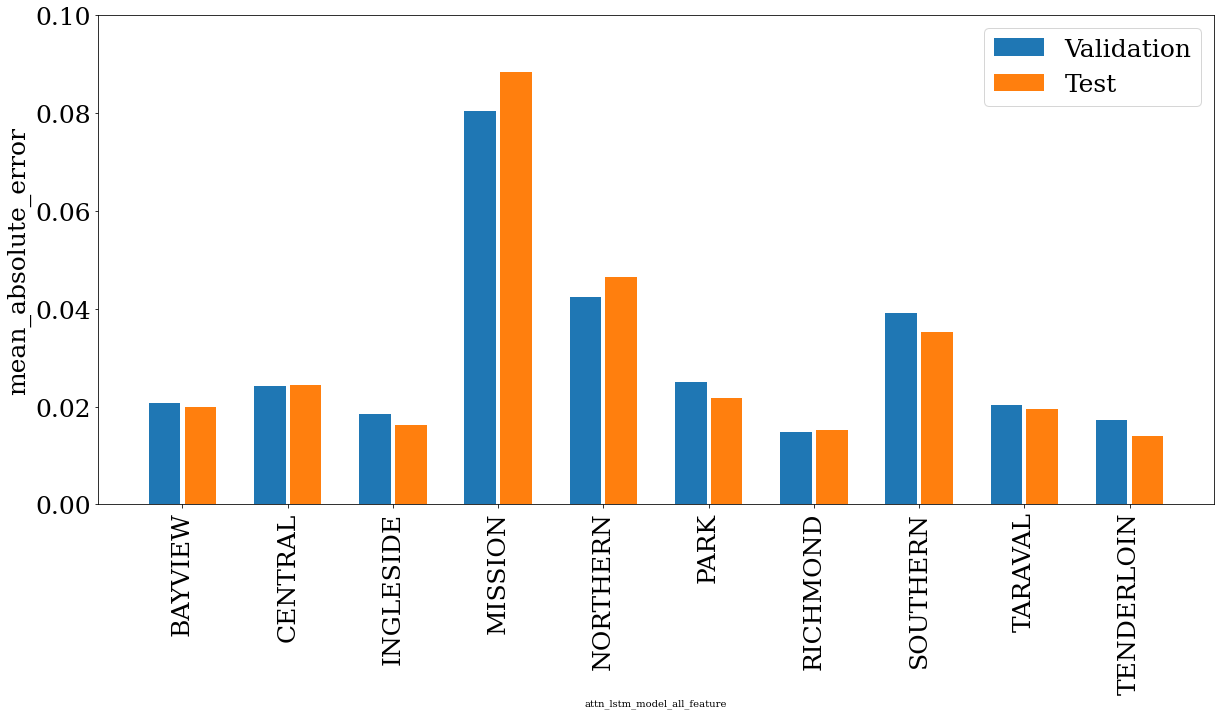

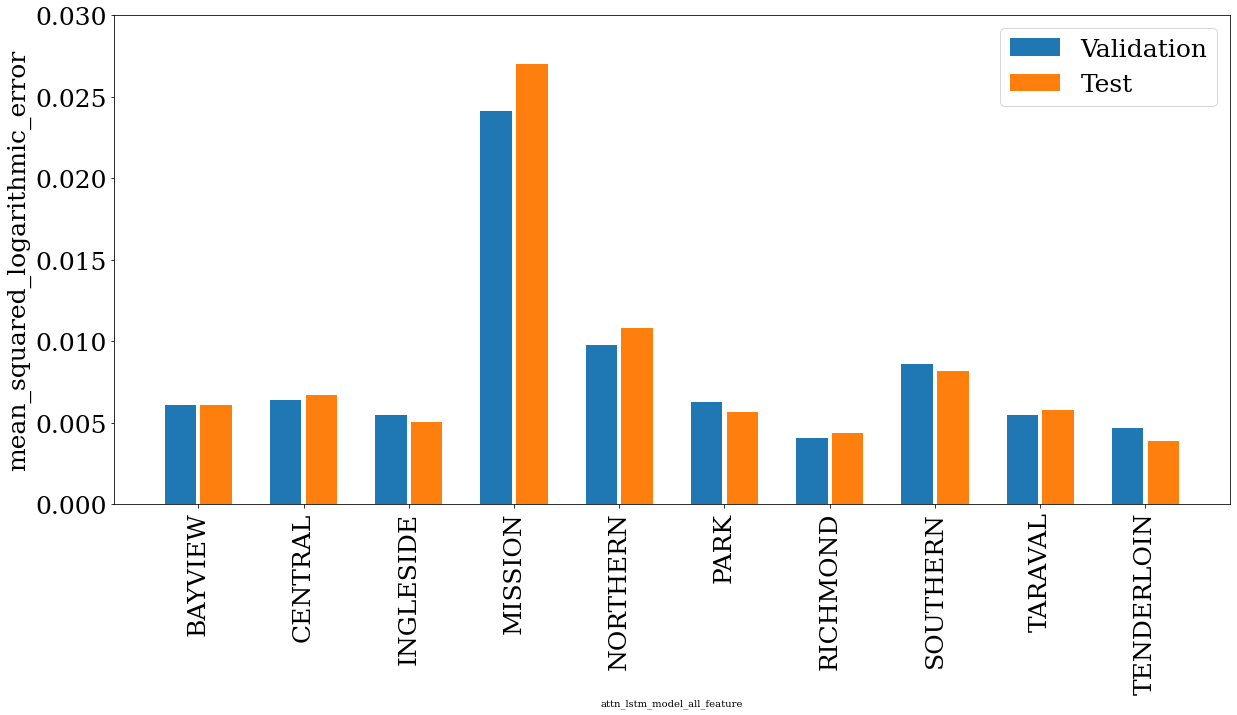

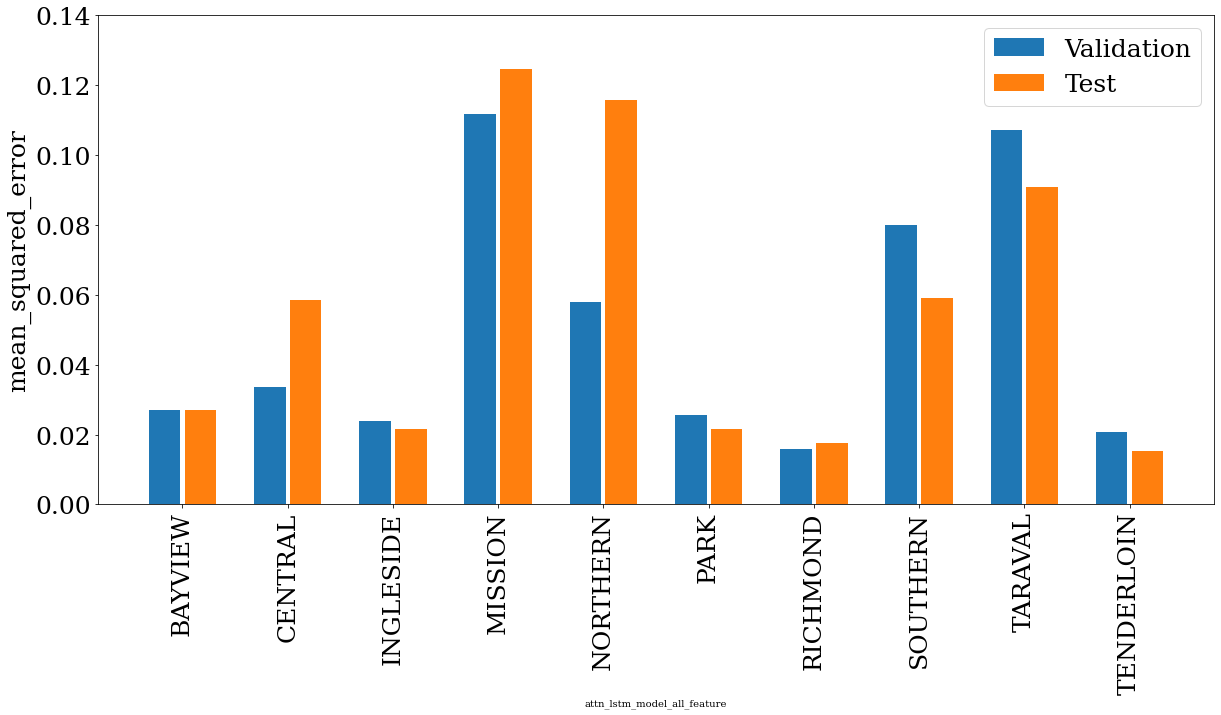

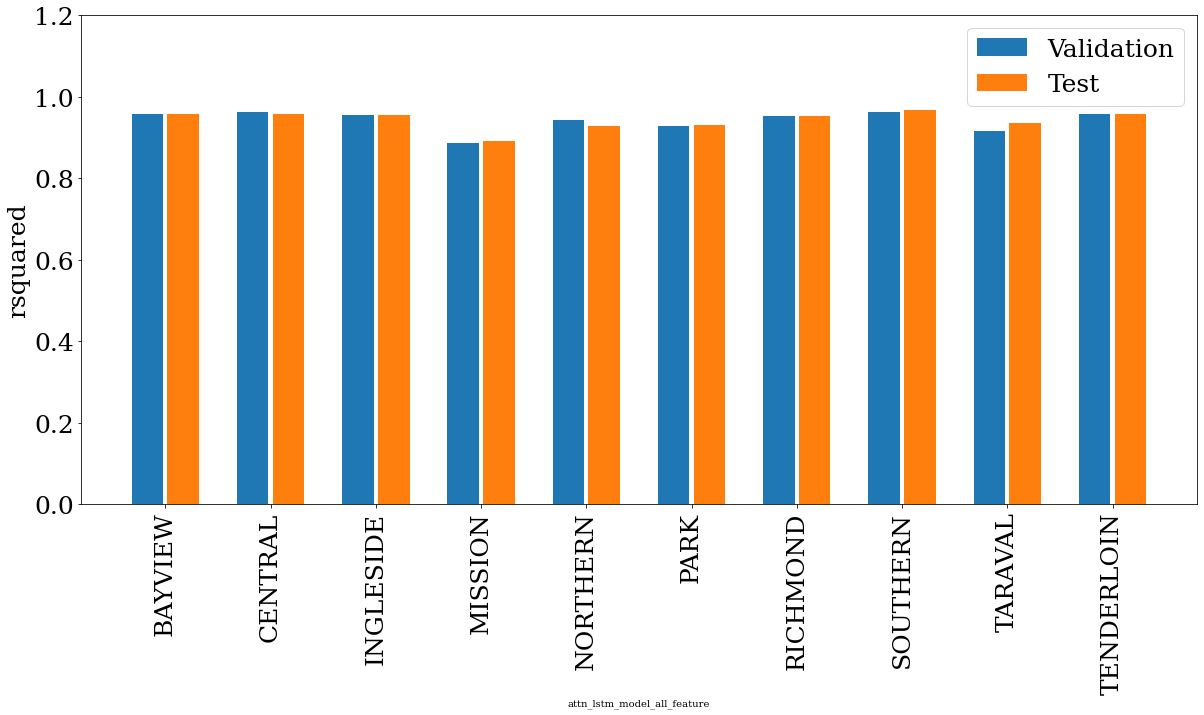

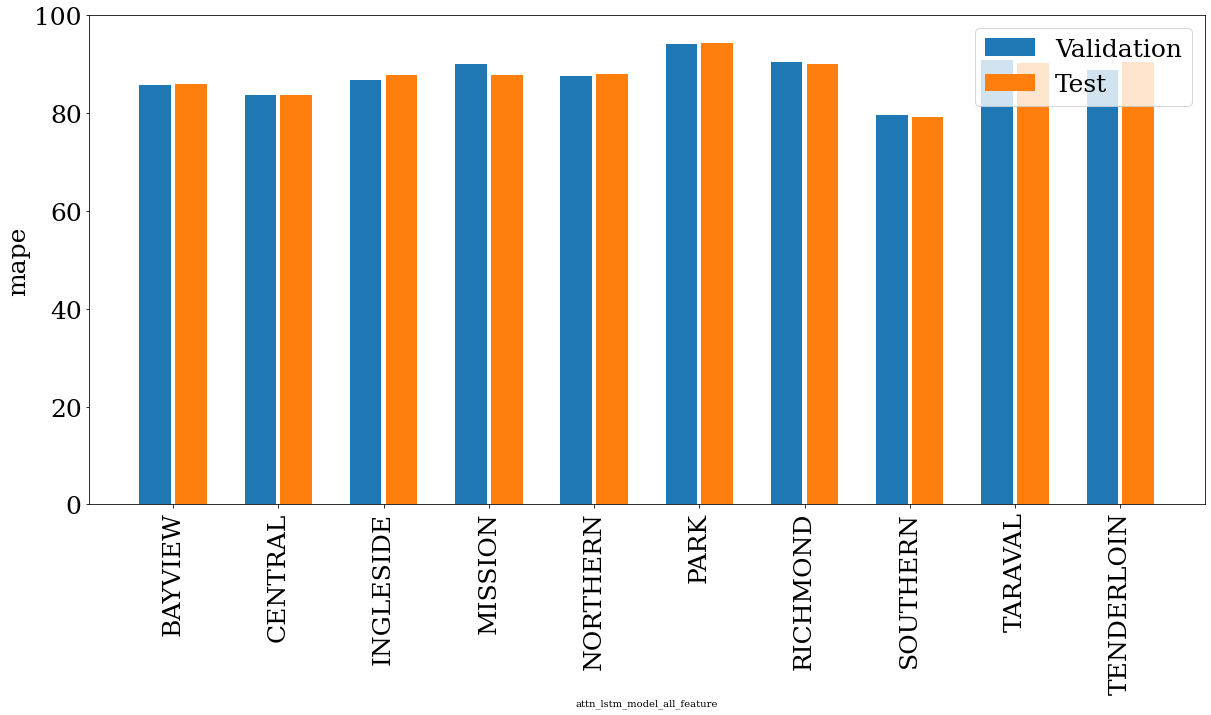

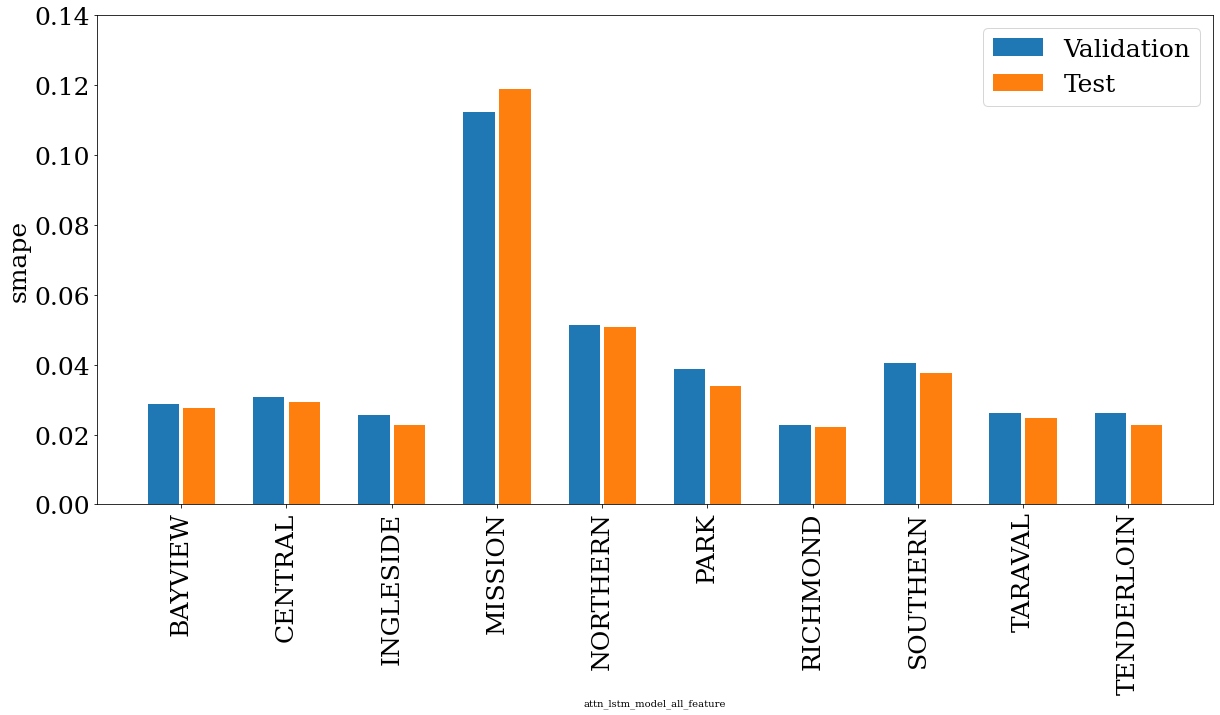

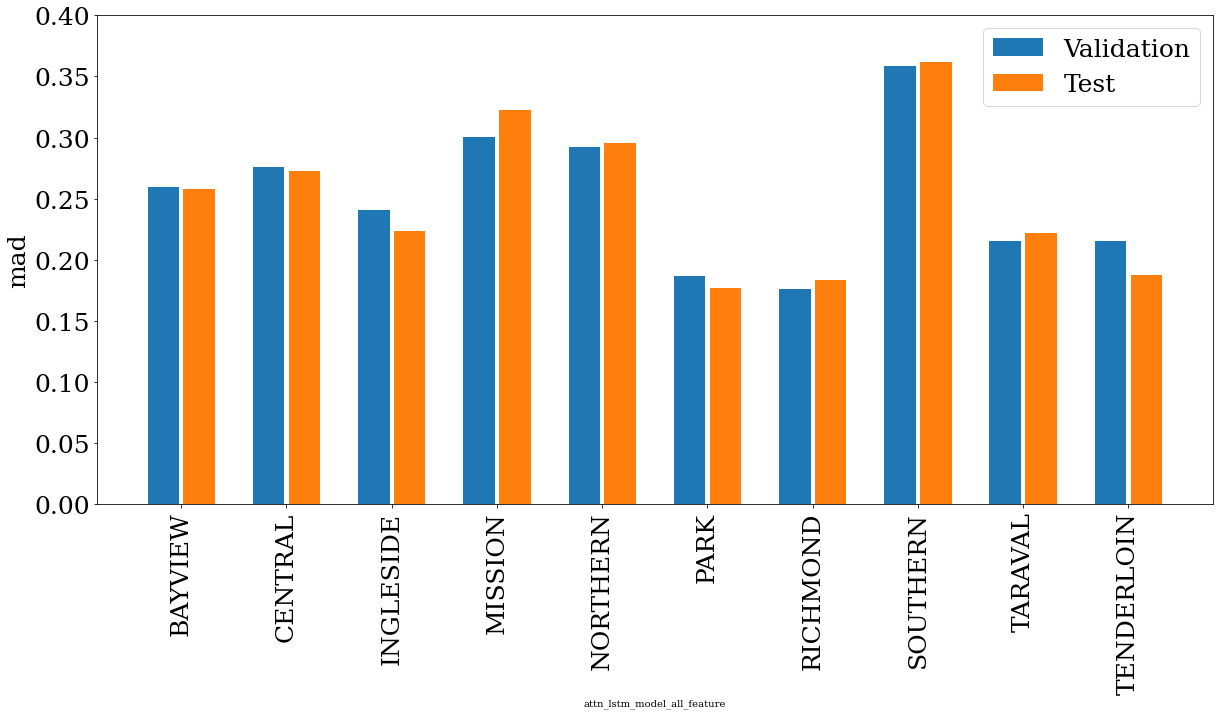

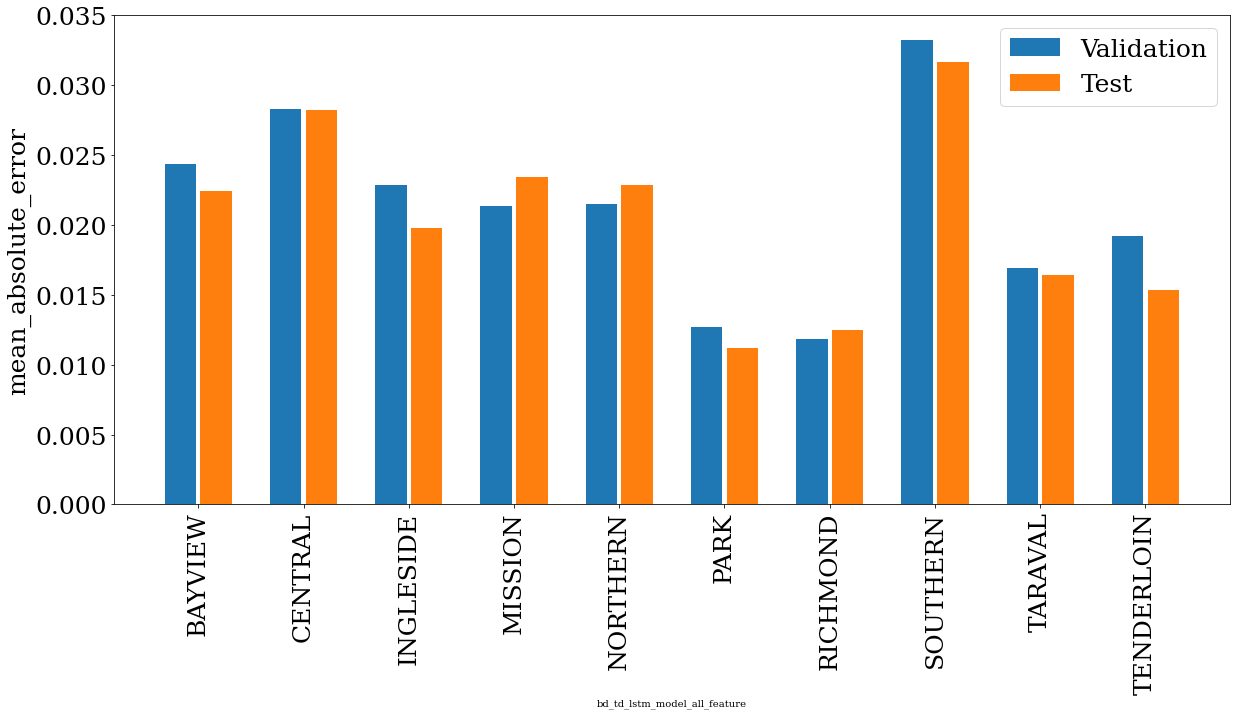

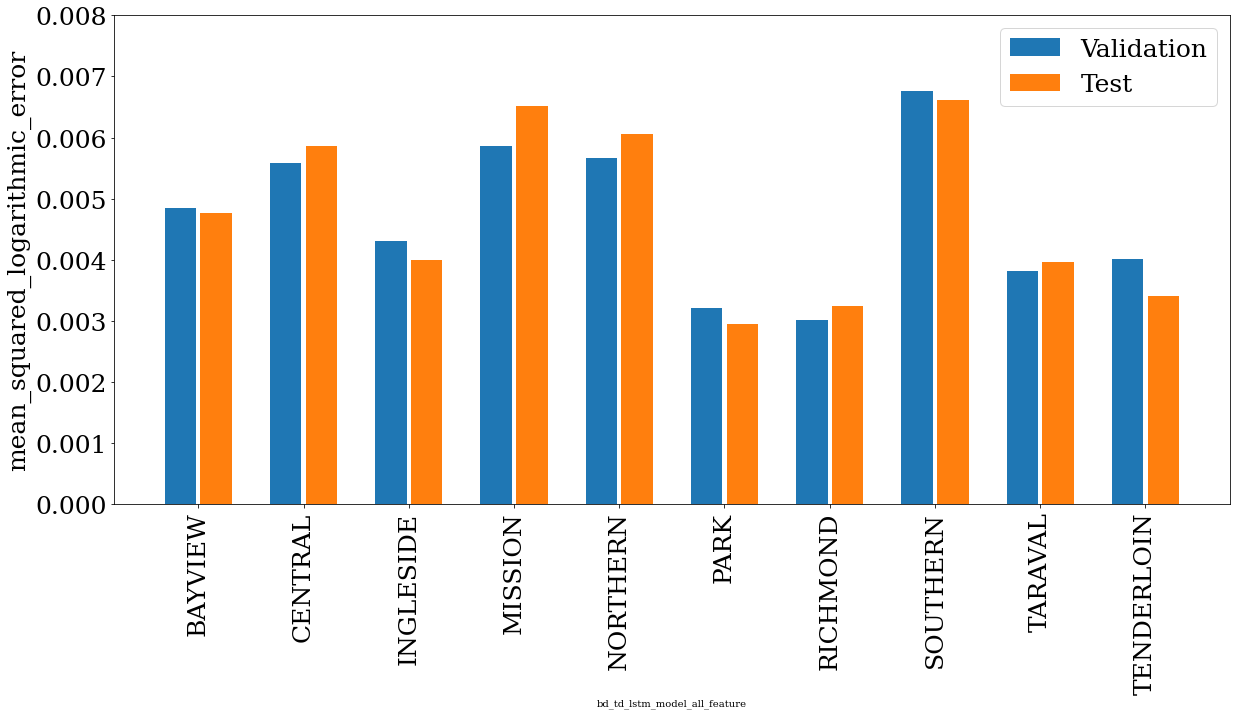

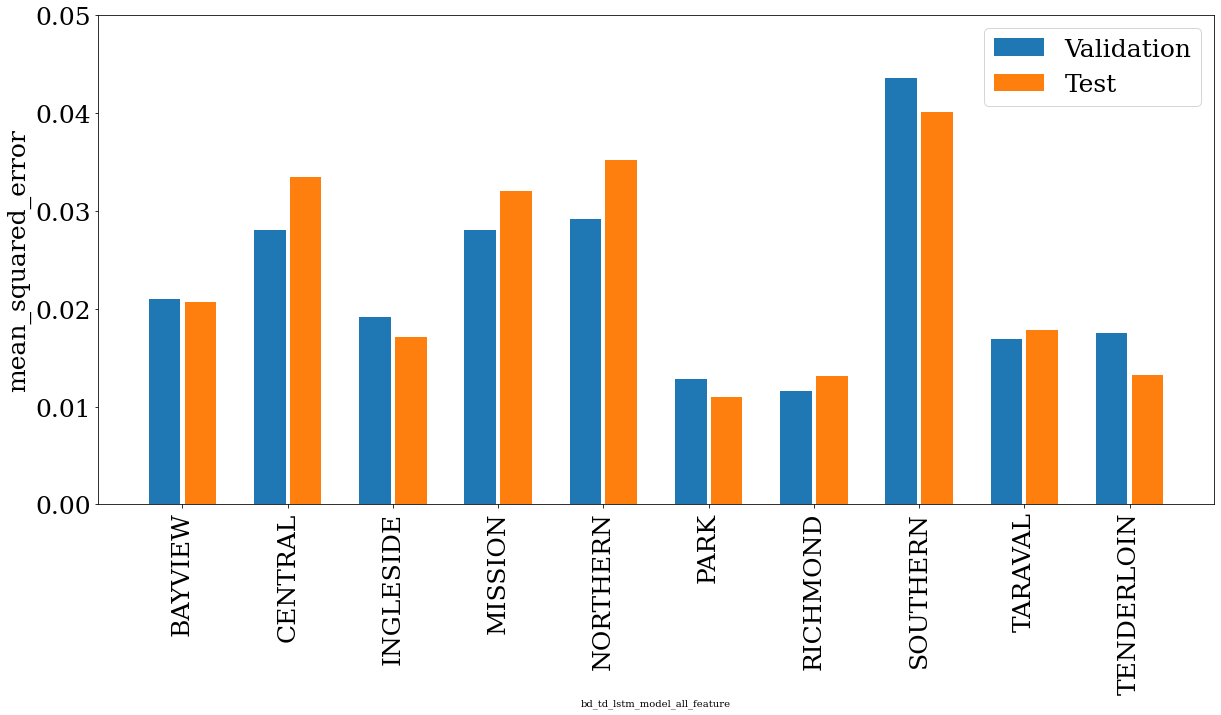

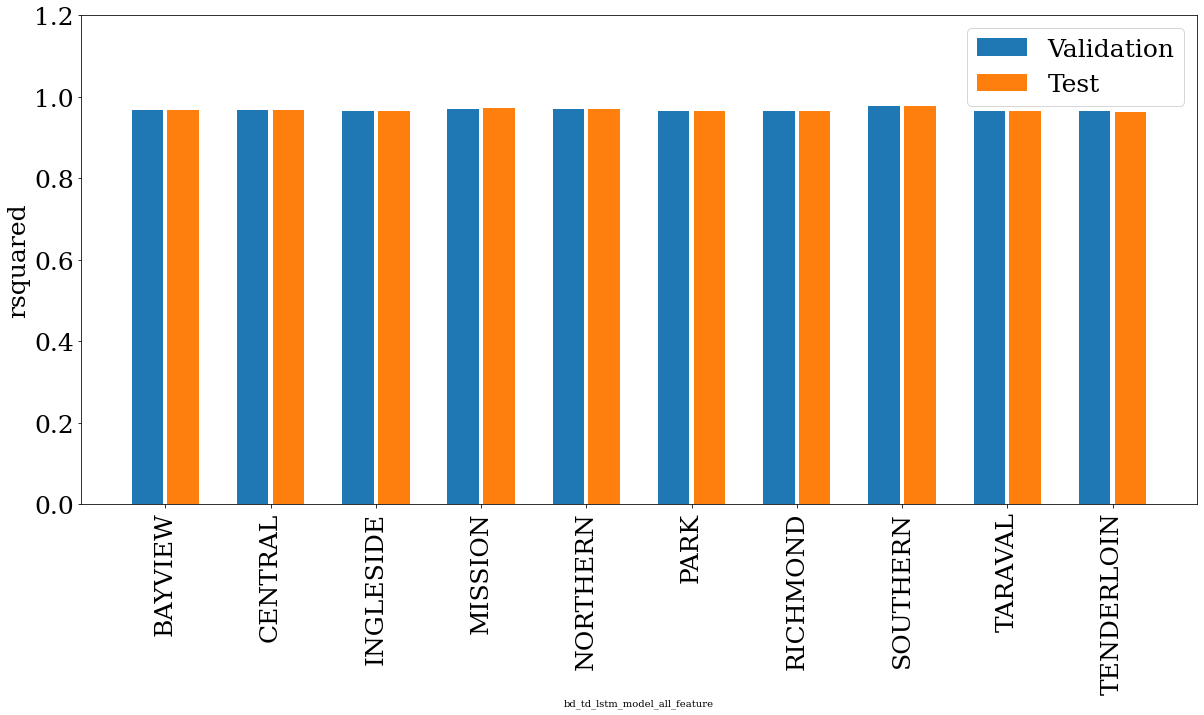

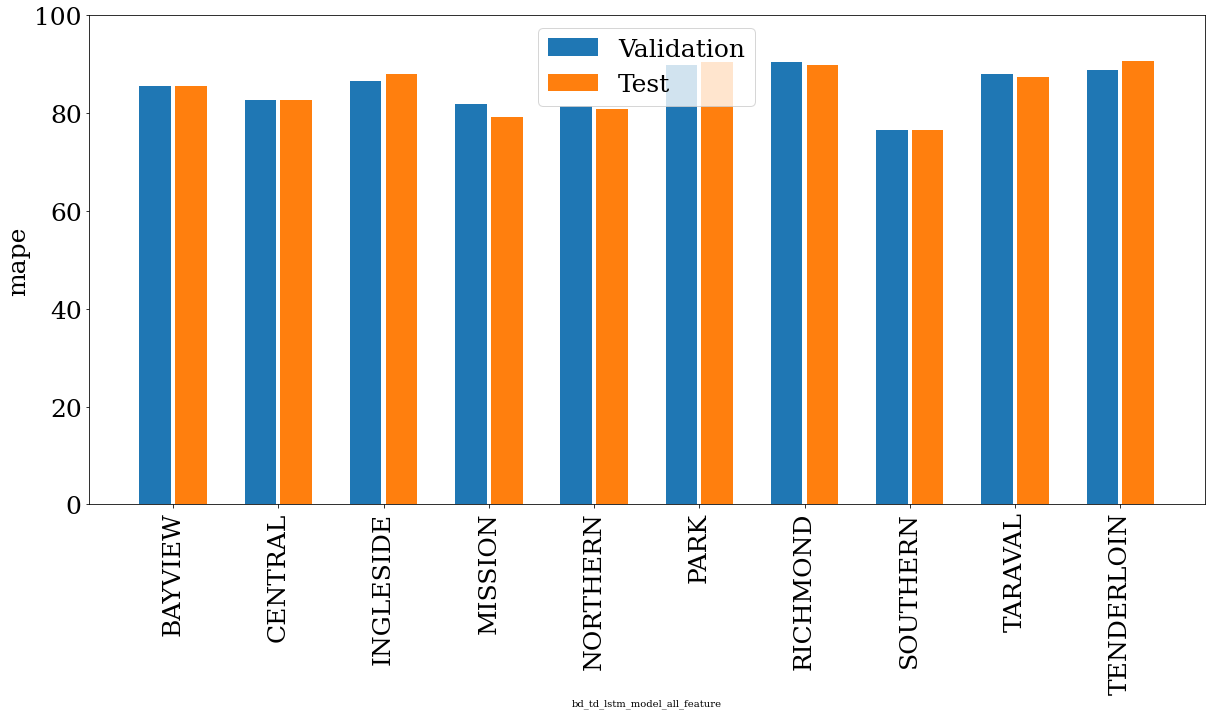

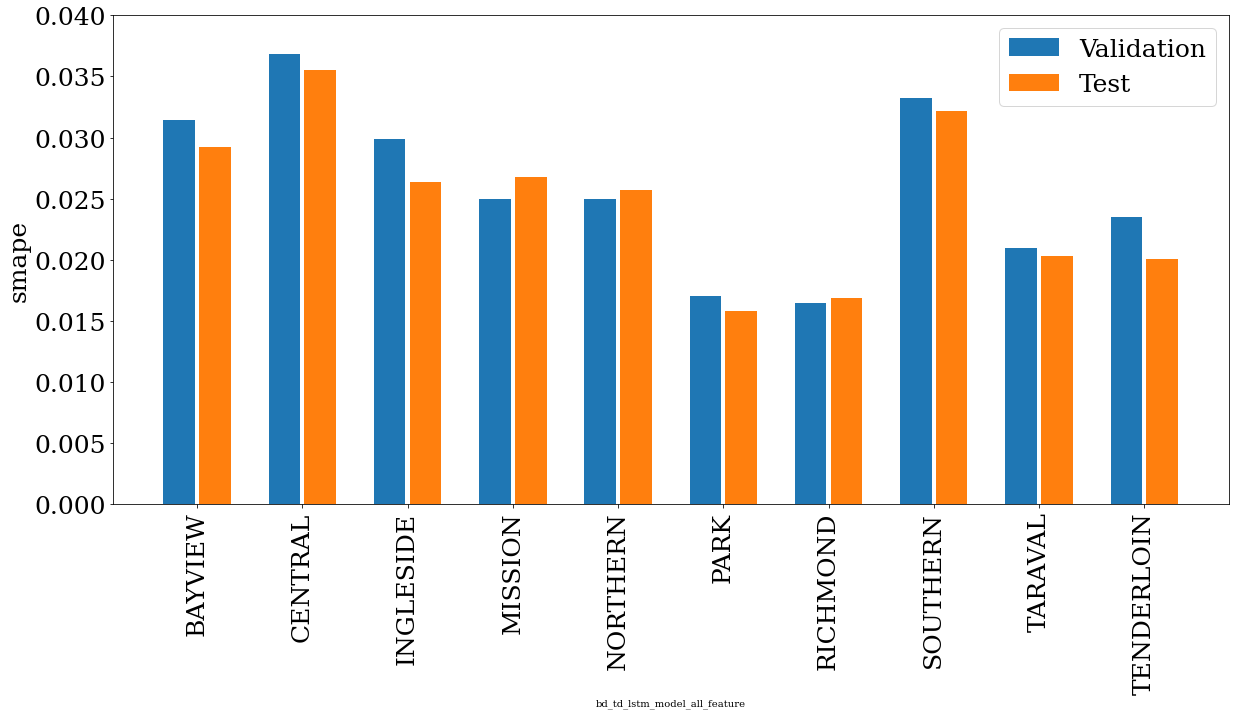

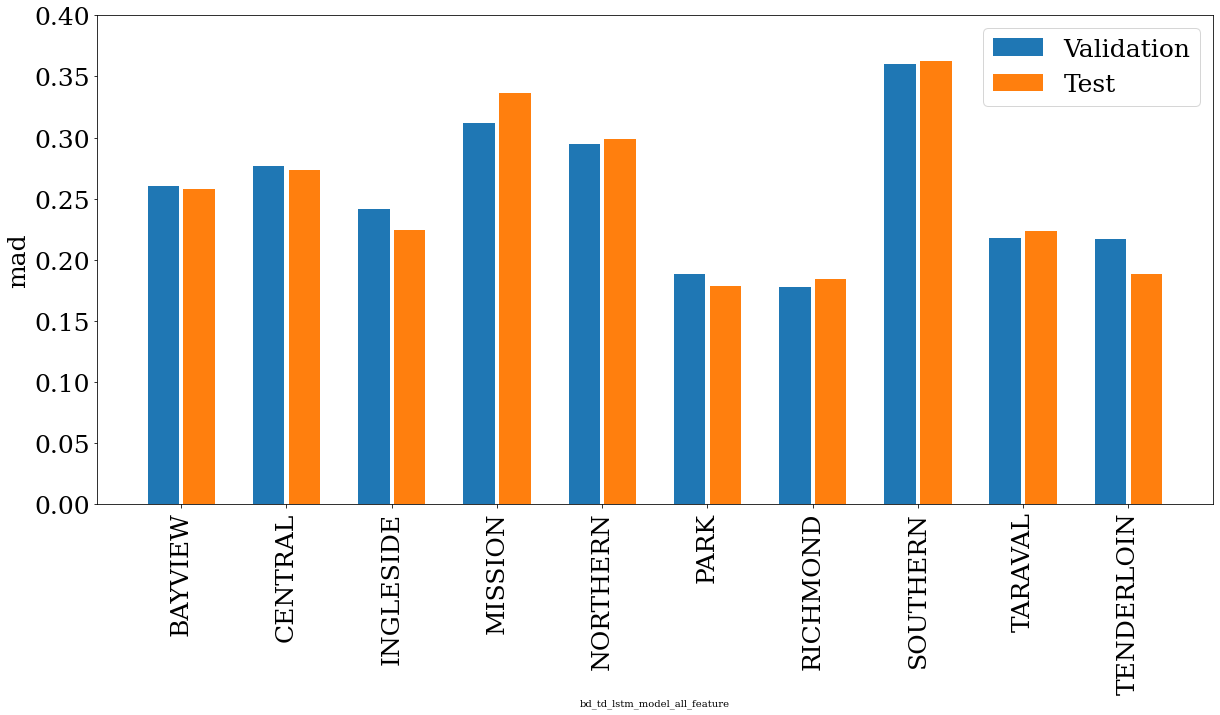

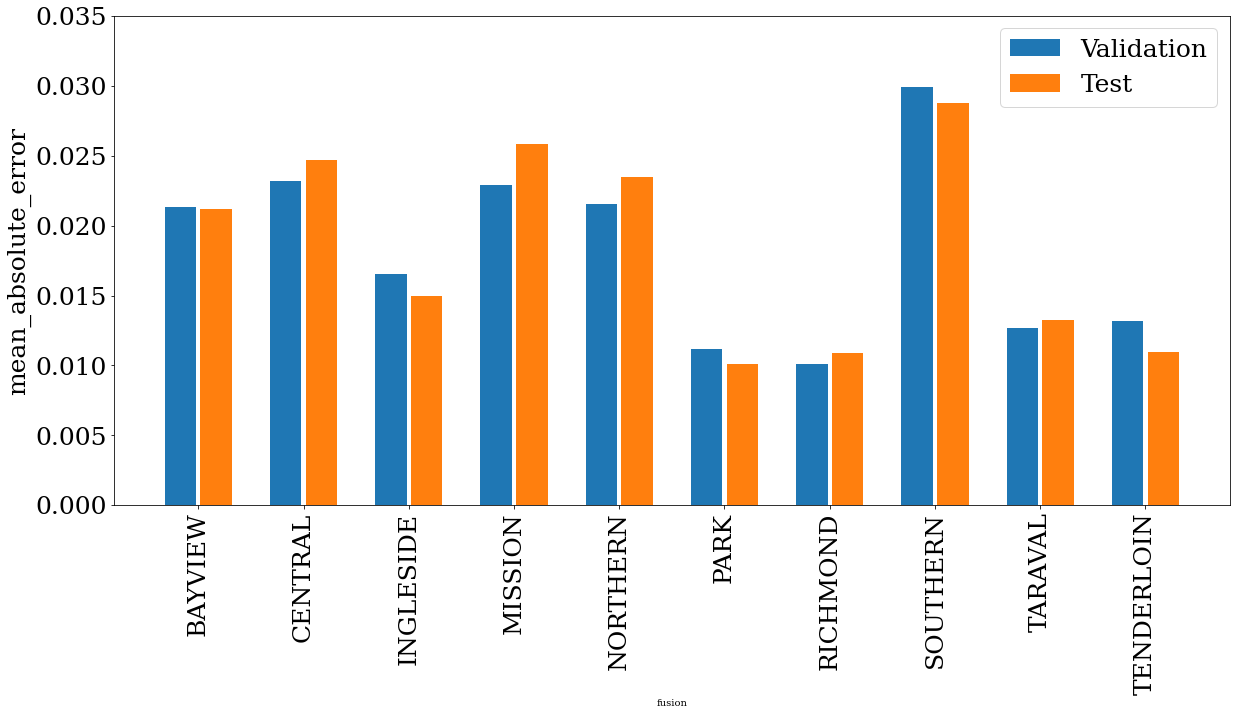

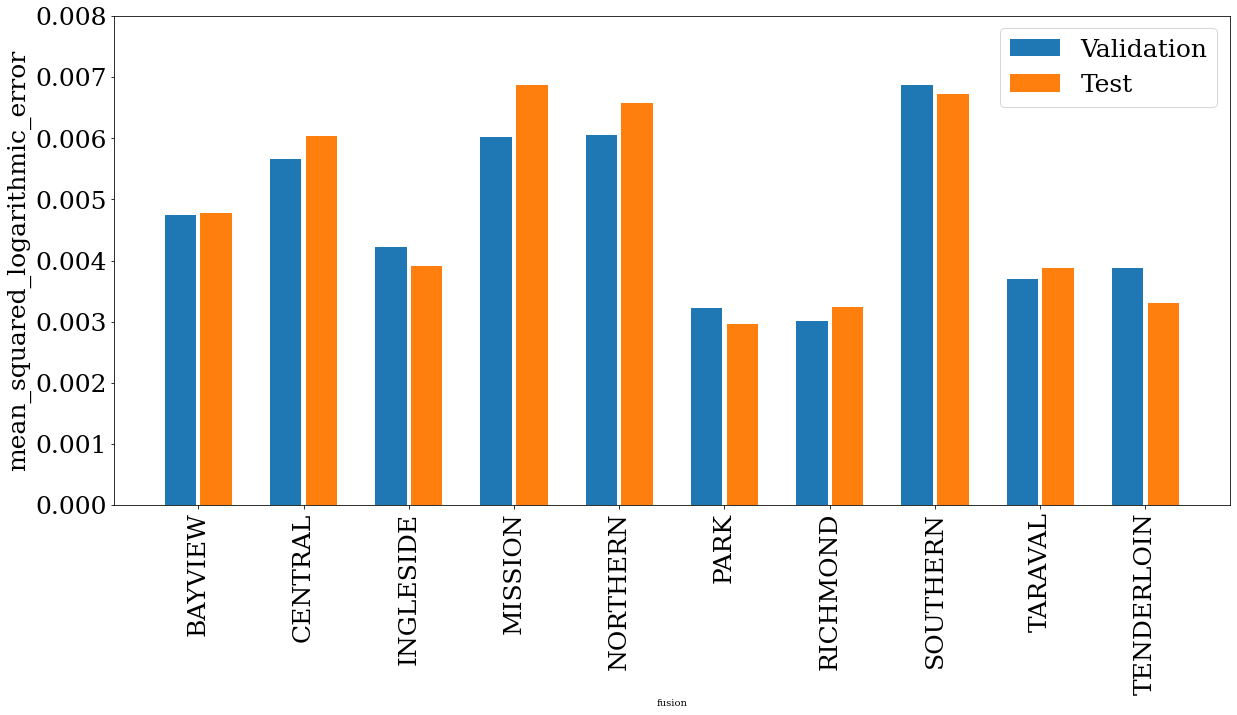

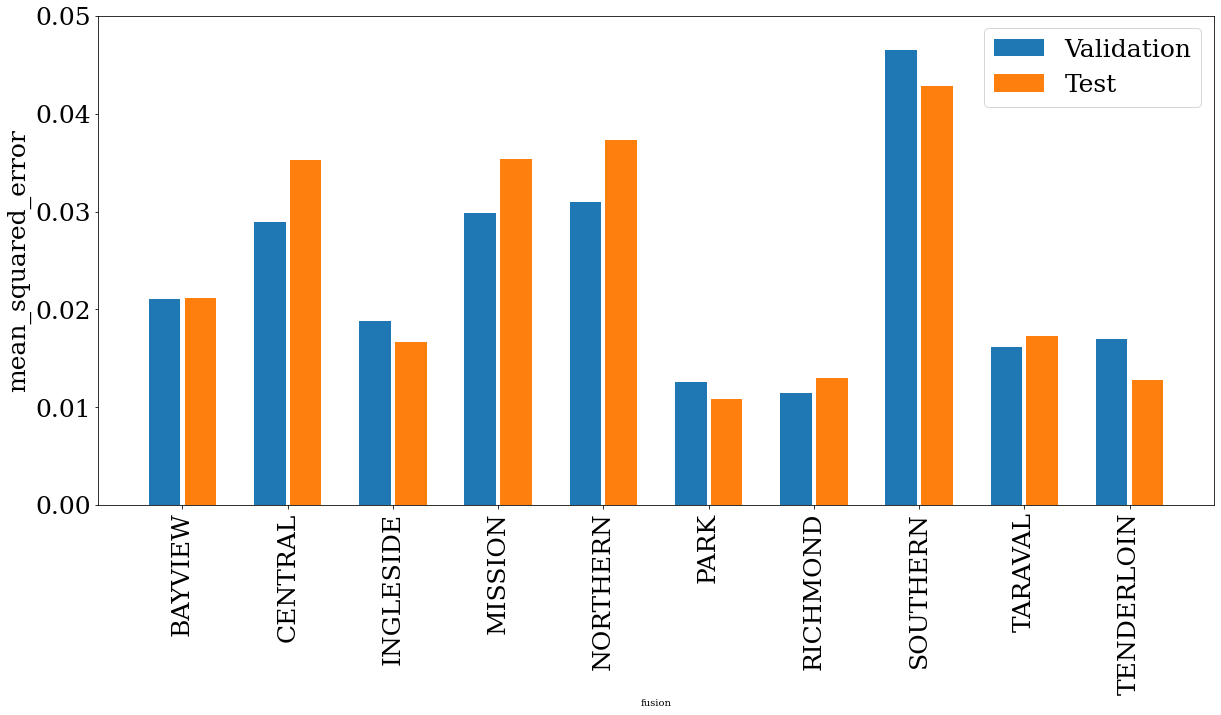

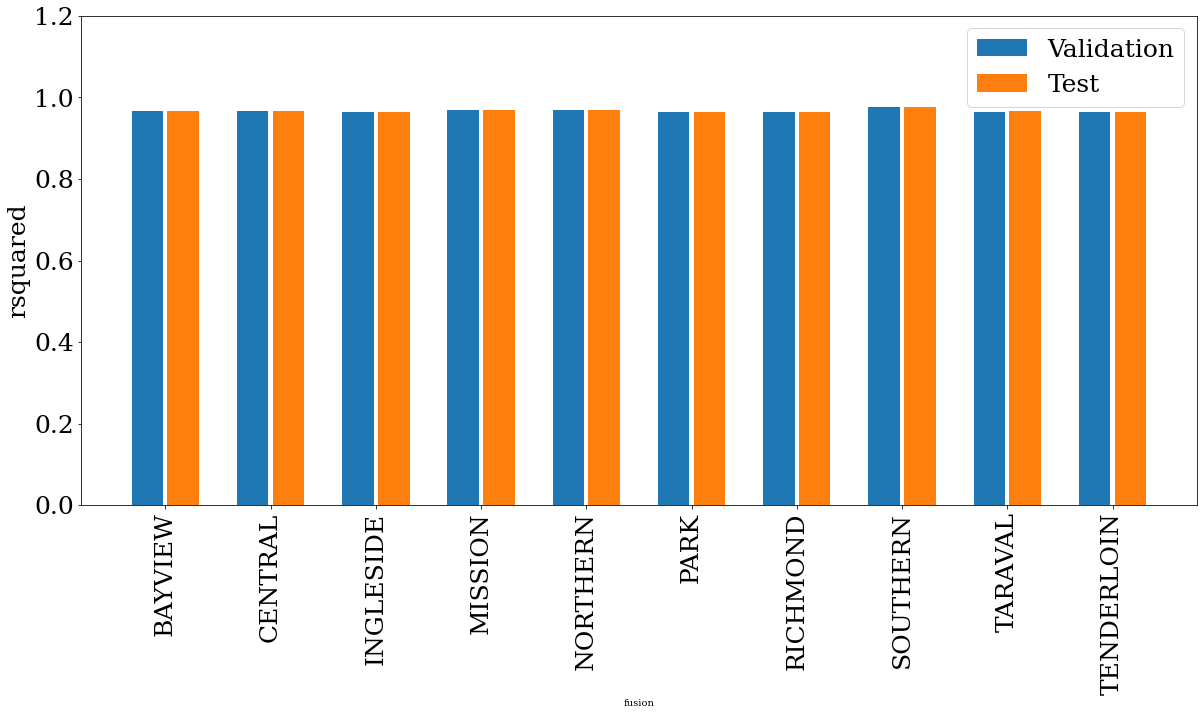

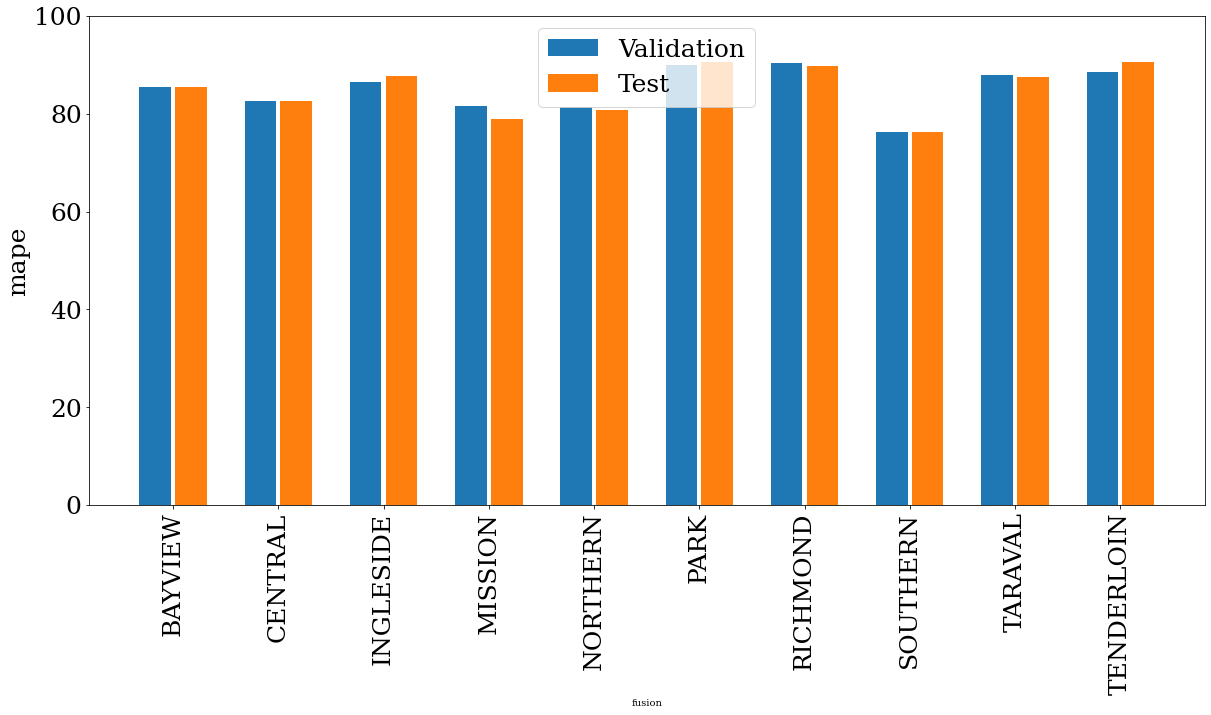

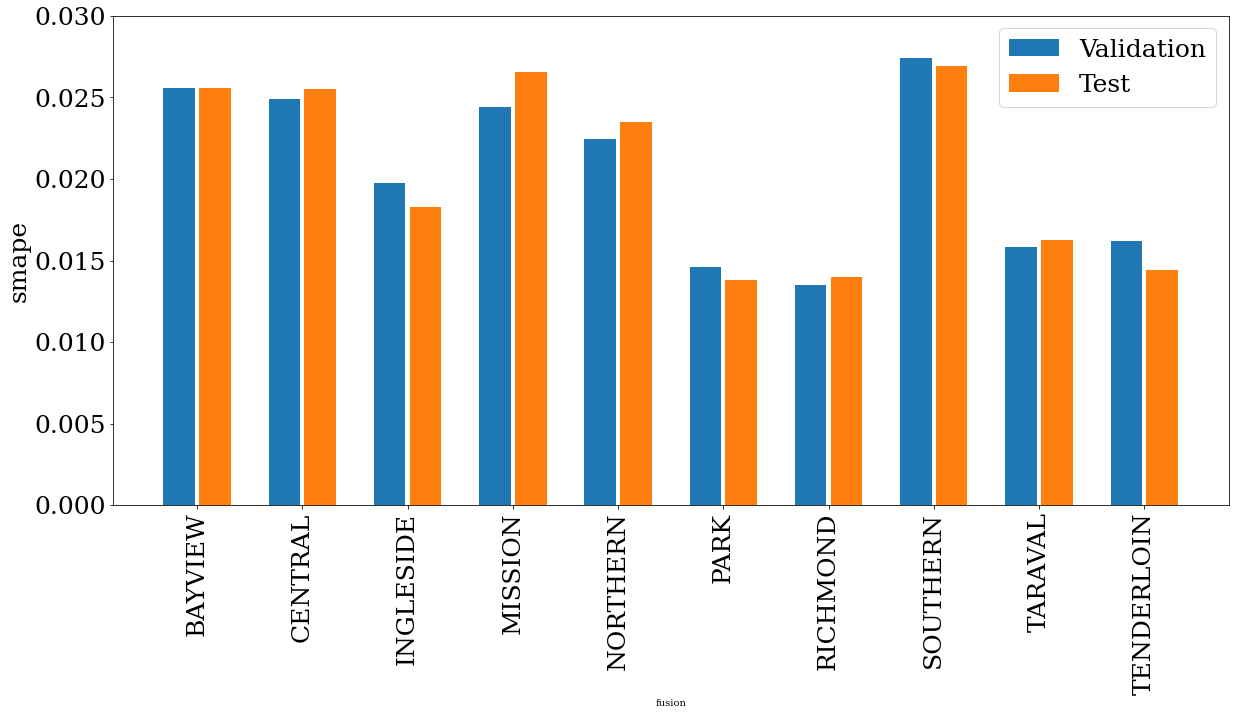

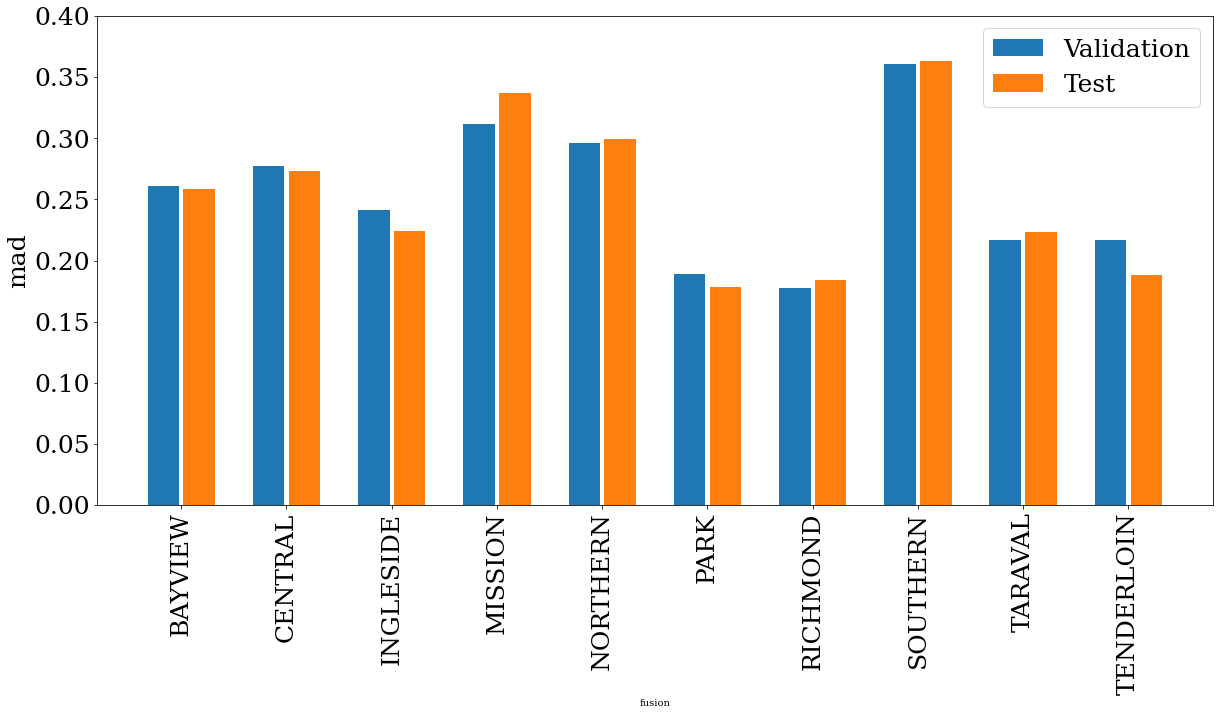

In [ ]:
for i in range(len(trained_models)):
  cnt = 0
  print(names[i])
  for j in trained_models[i].metrics_names:
    plotLoss(trained_models[i] , performance_datas[i] , val_performance_datas[i] , j , names[i] , ylabels[cnt])
    cnt = cnt + 1

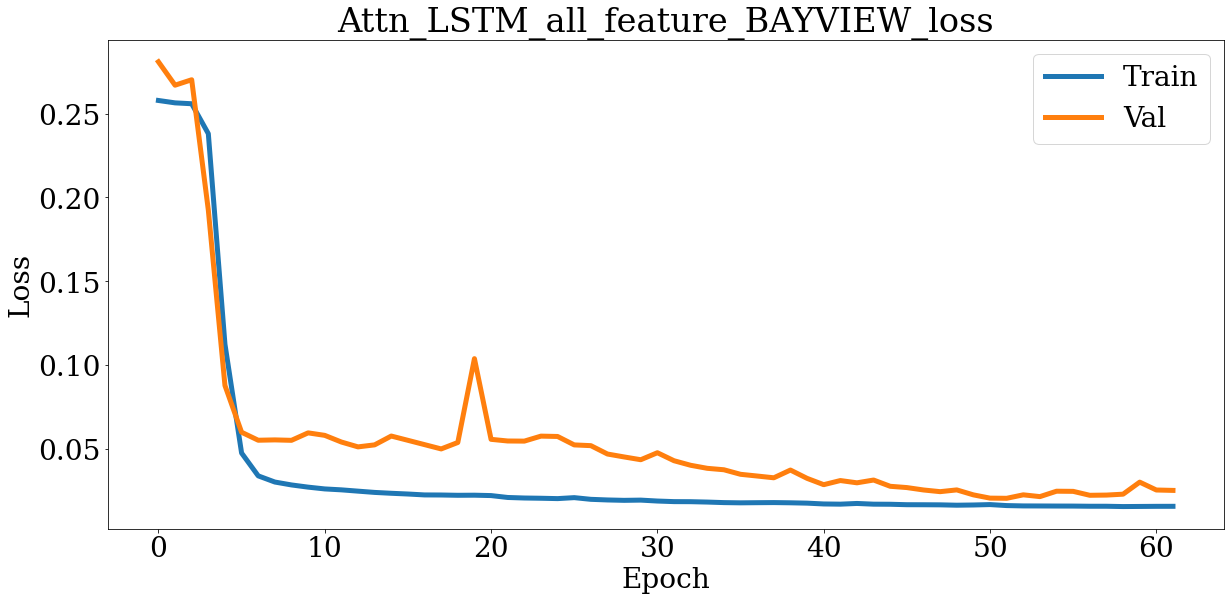

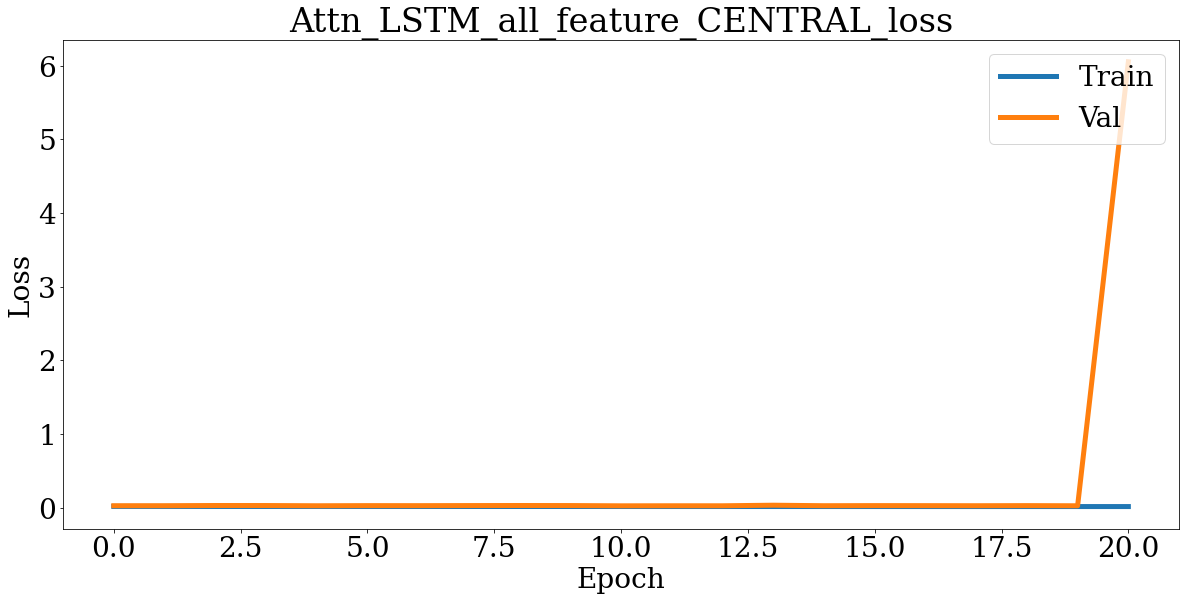

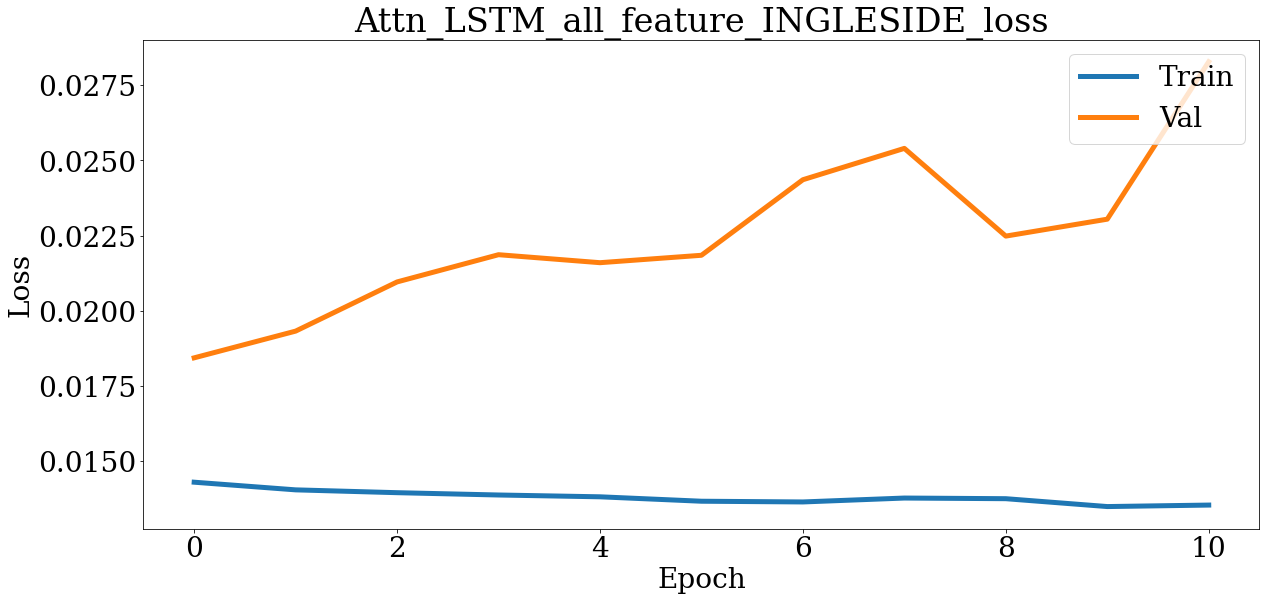

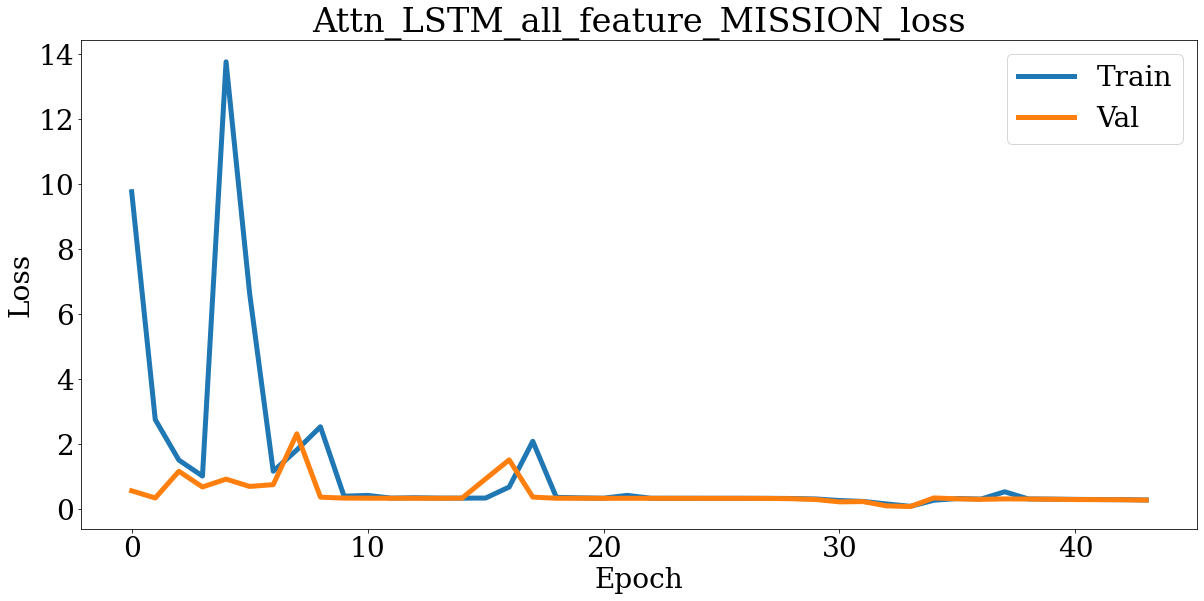

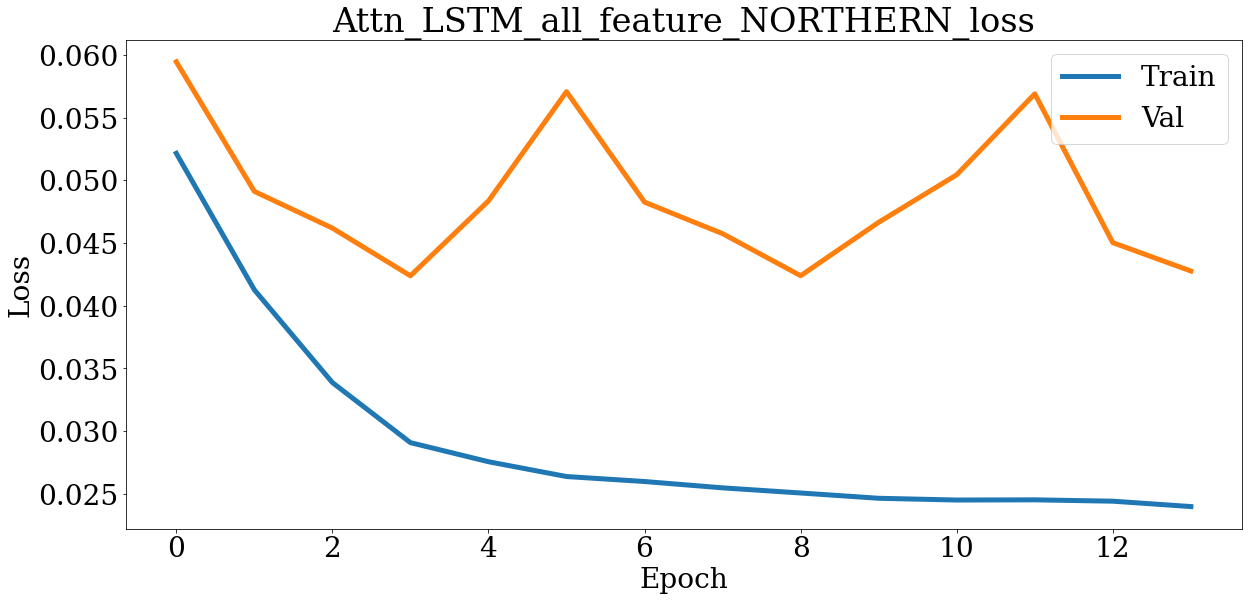

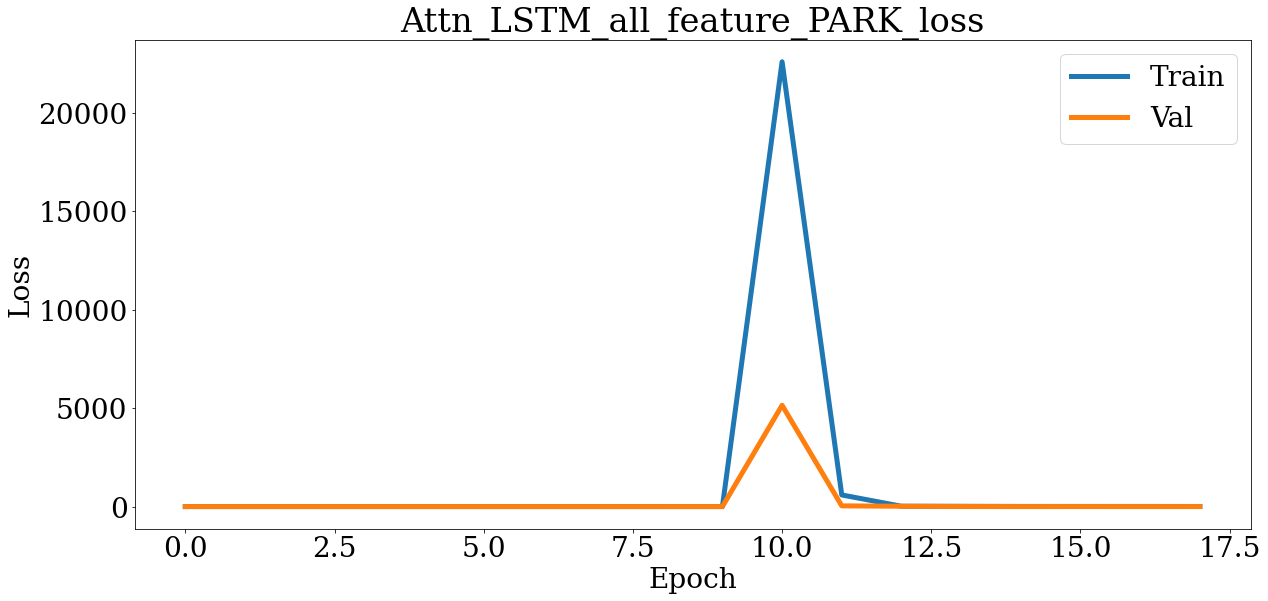

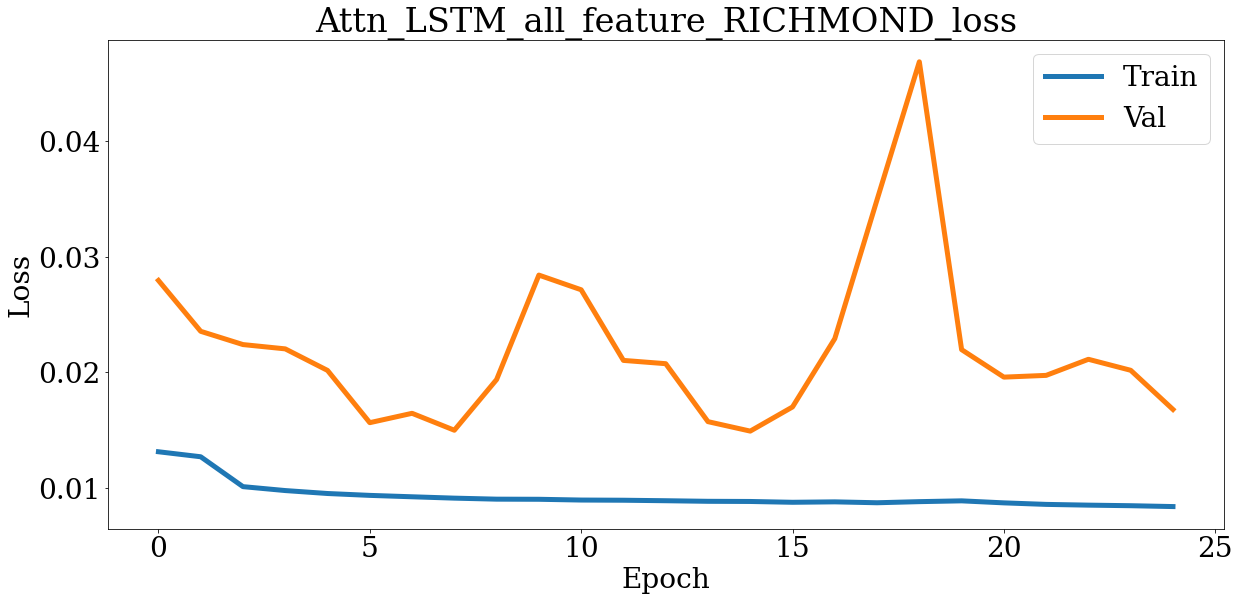

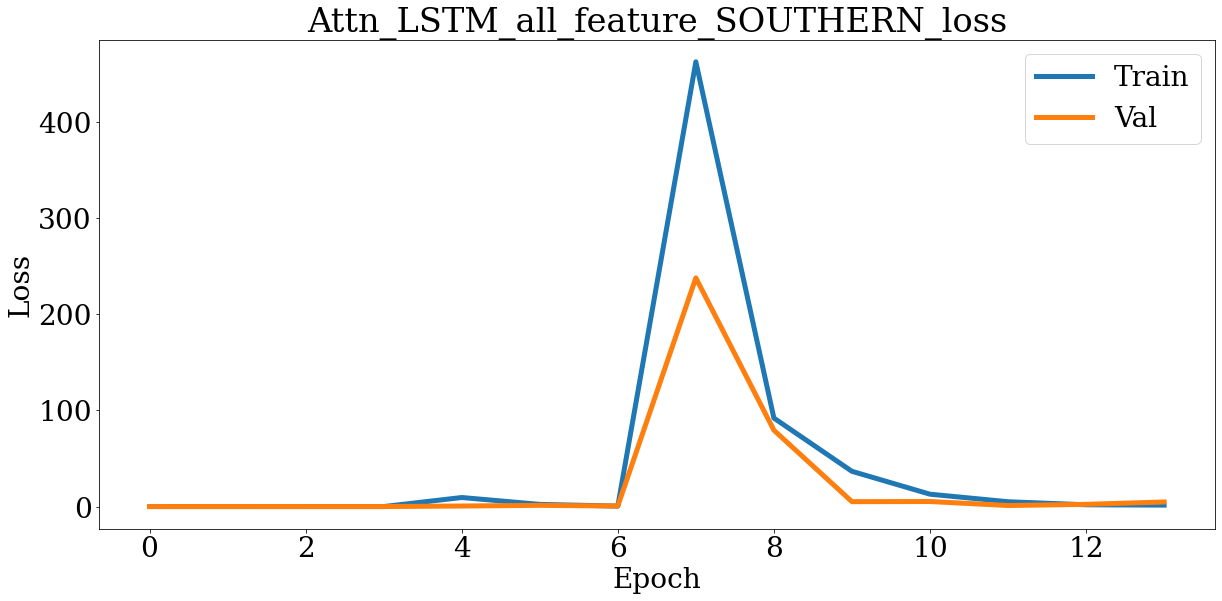

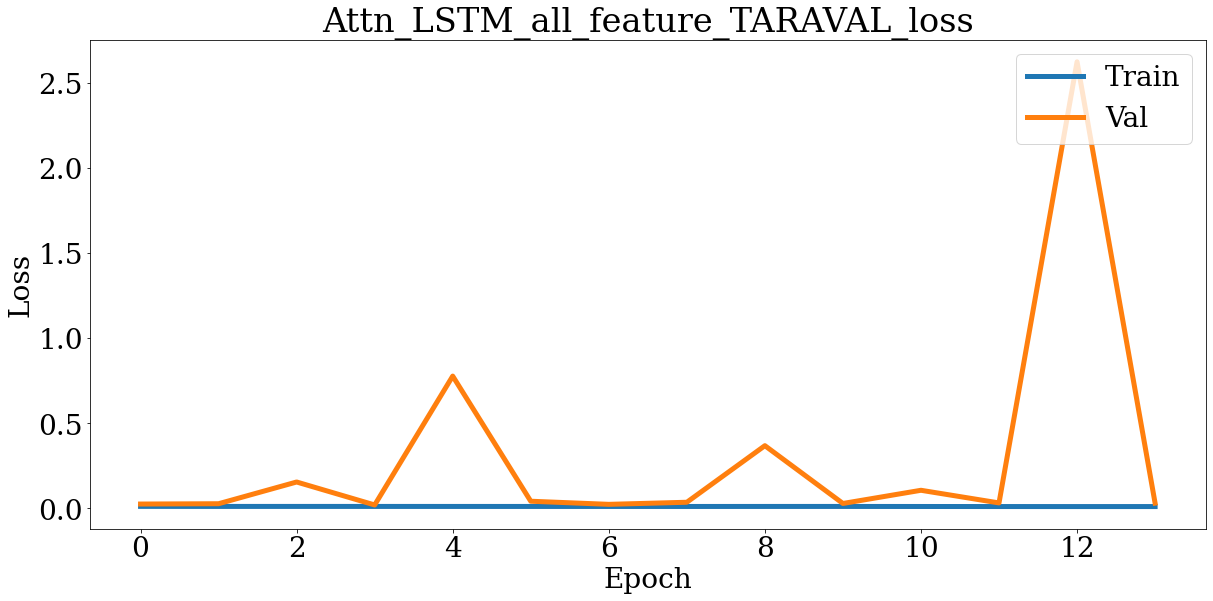

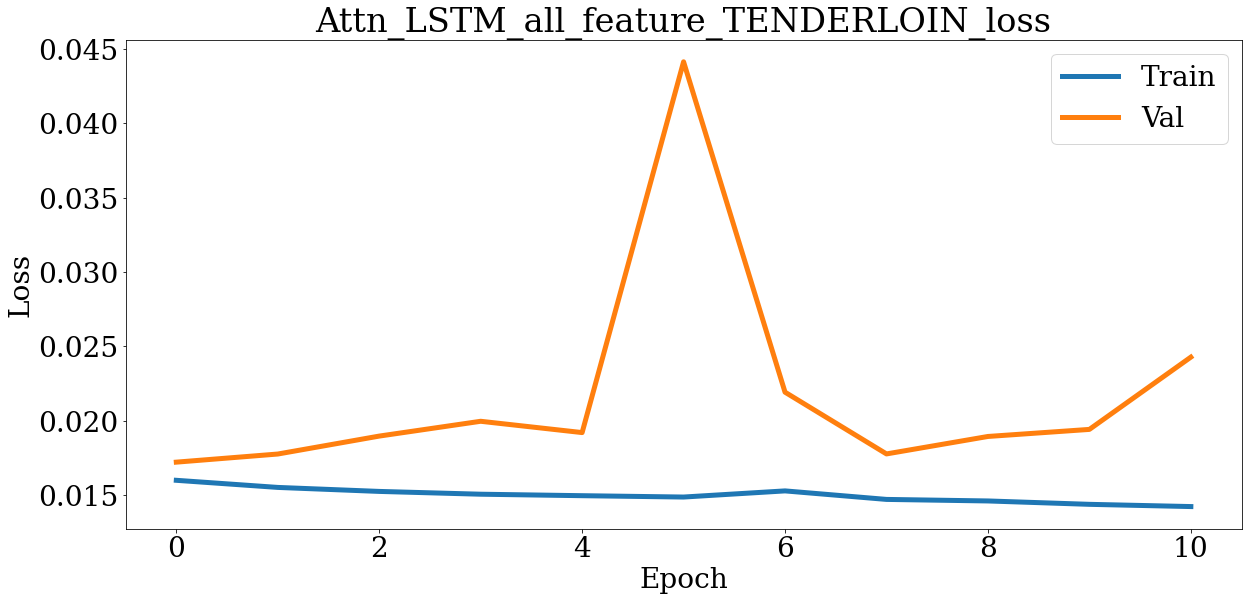

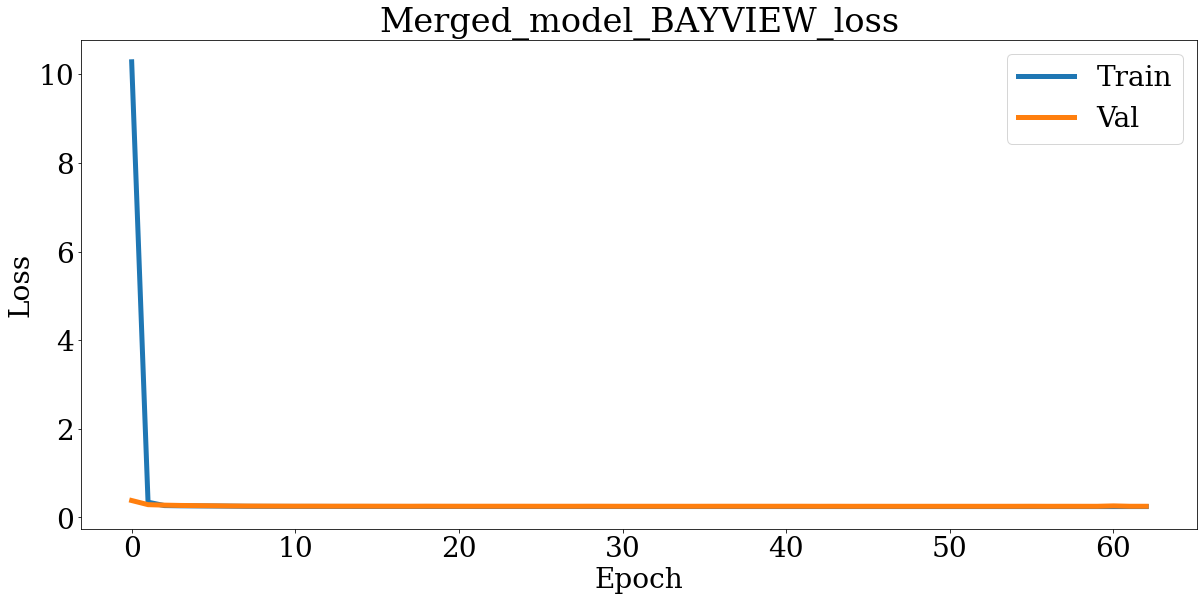

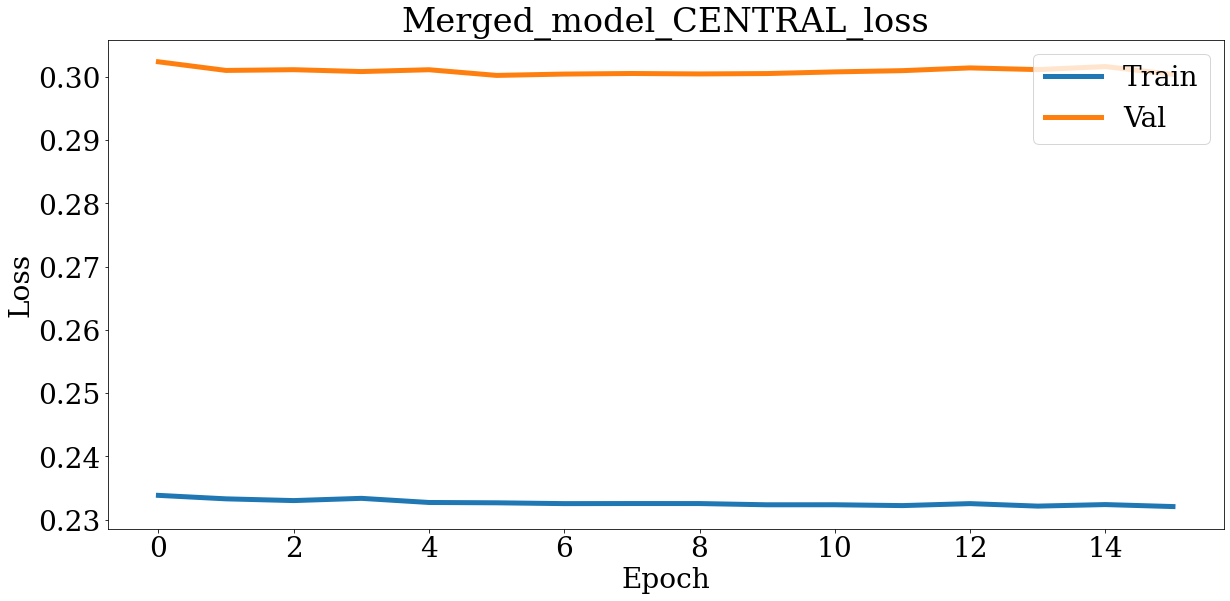

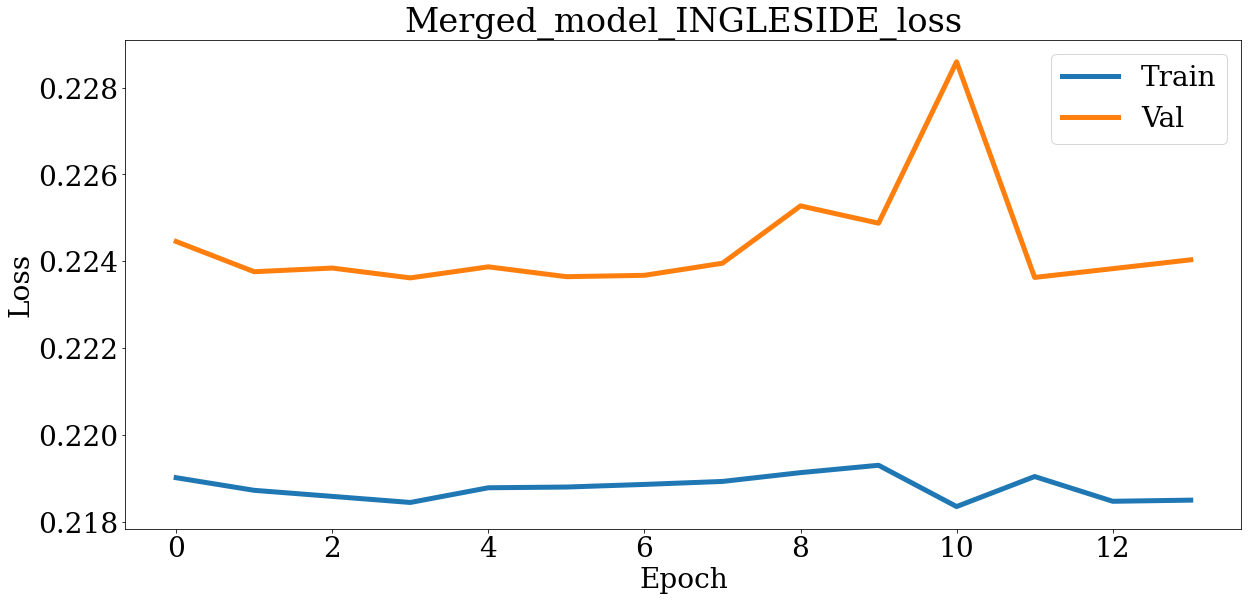

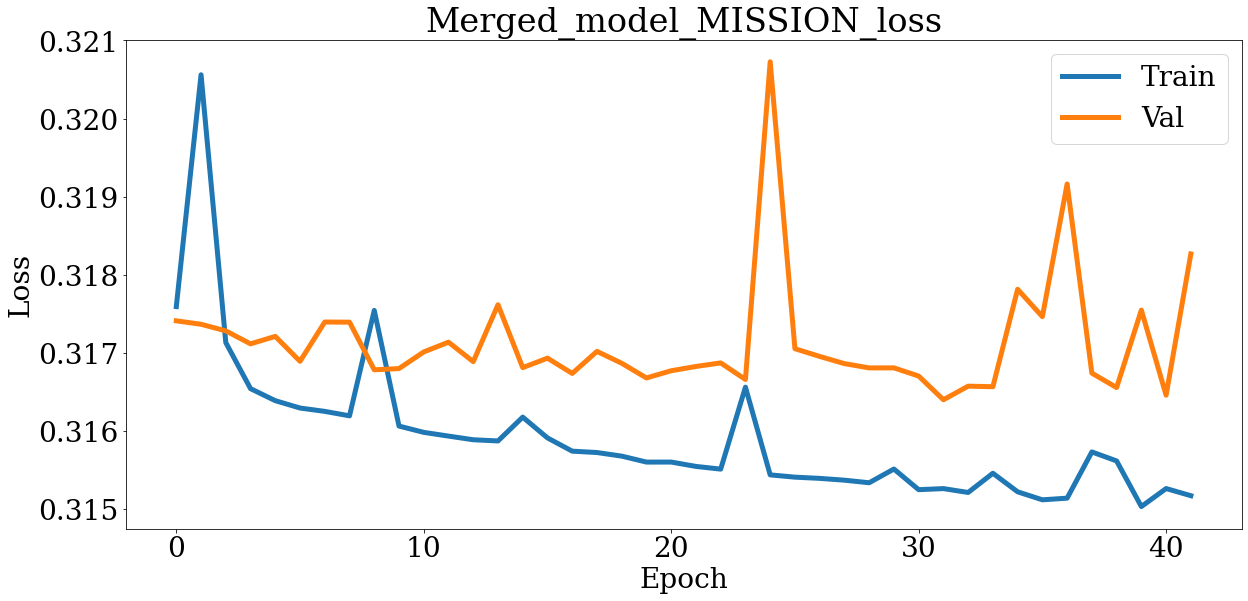

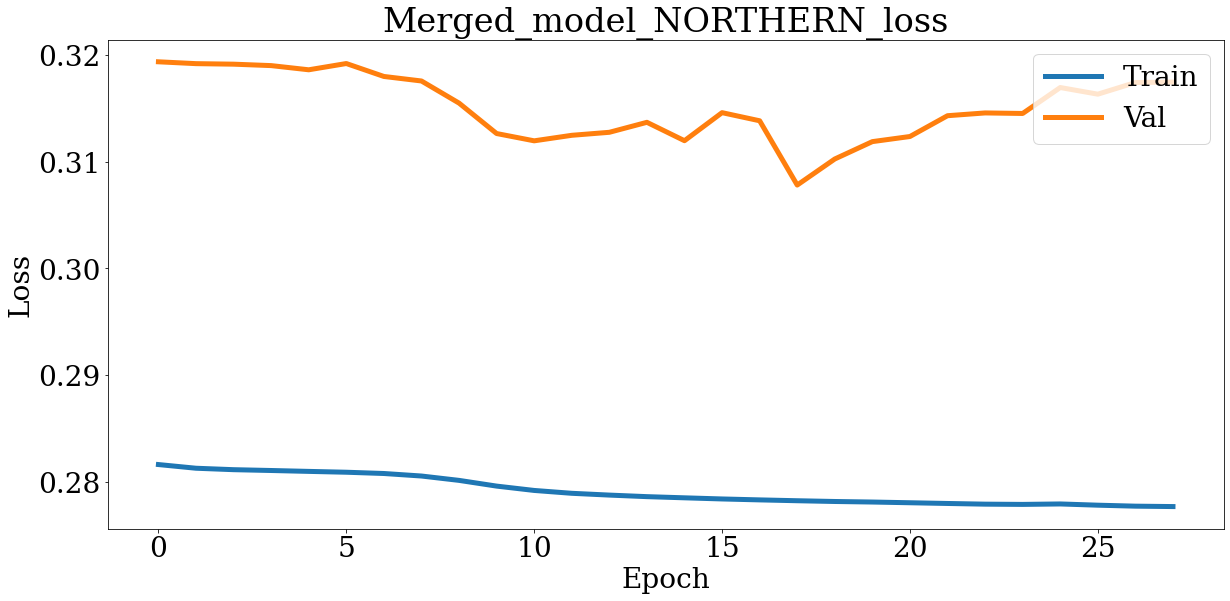

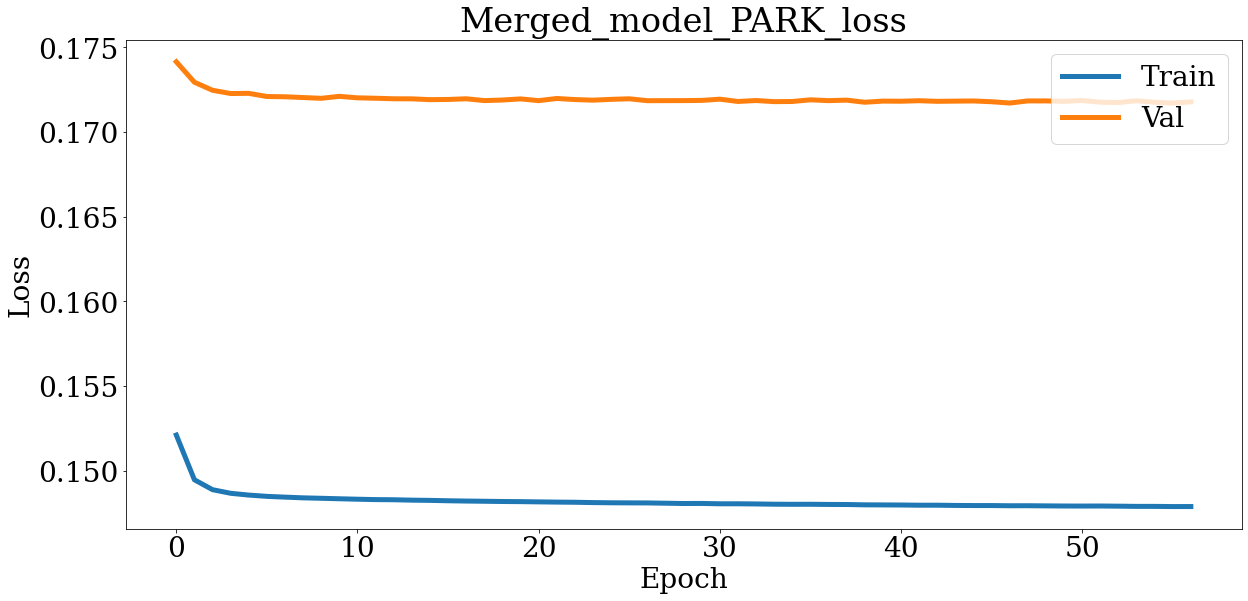

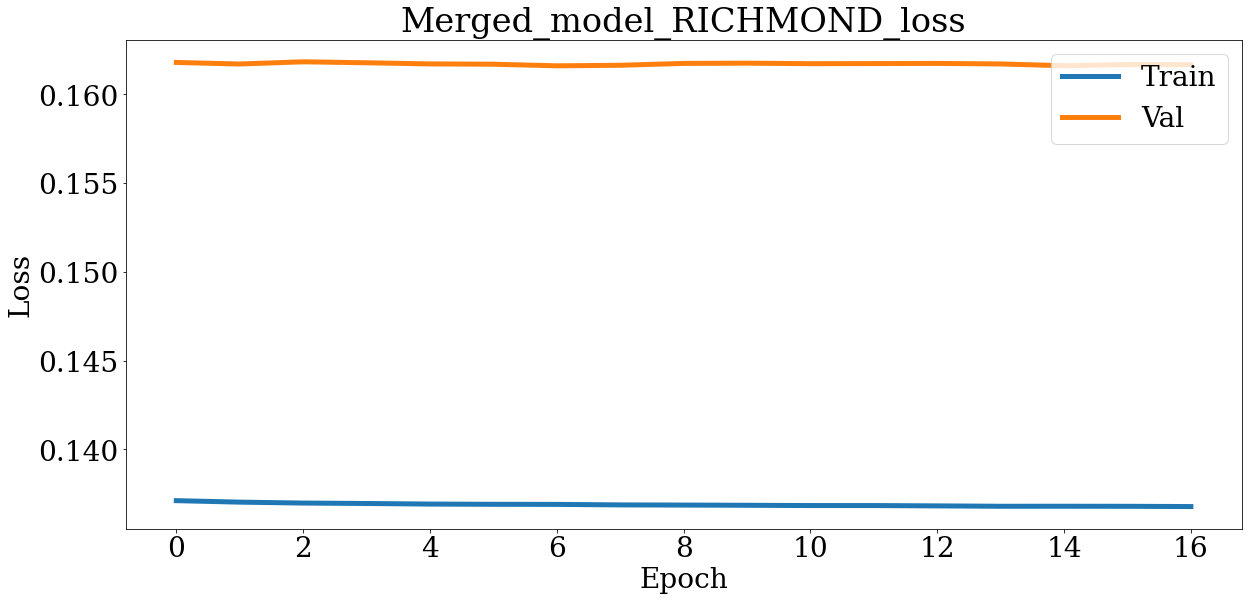

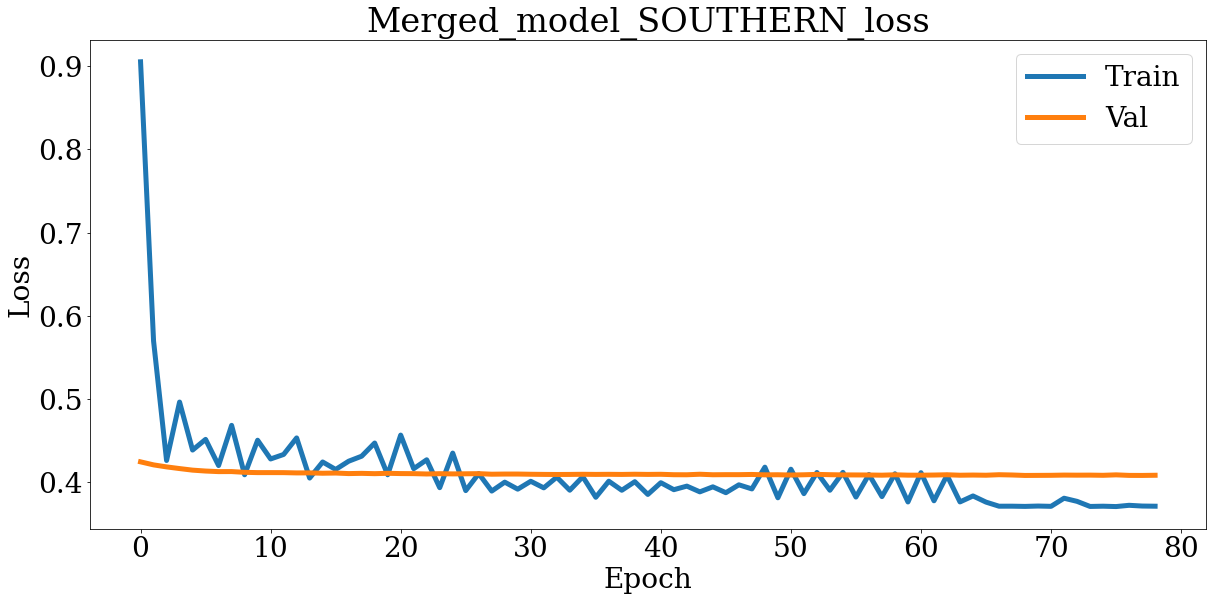

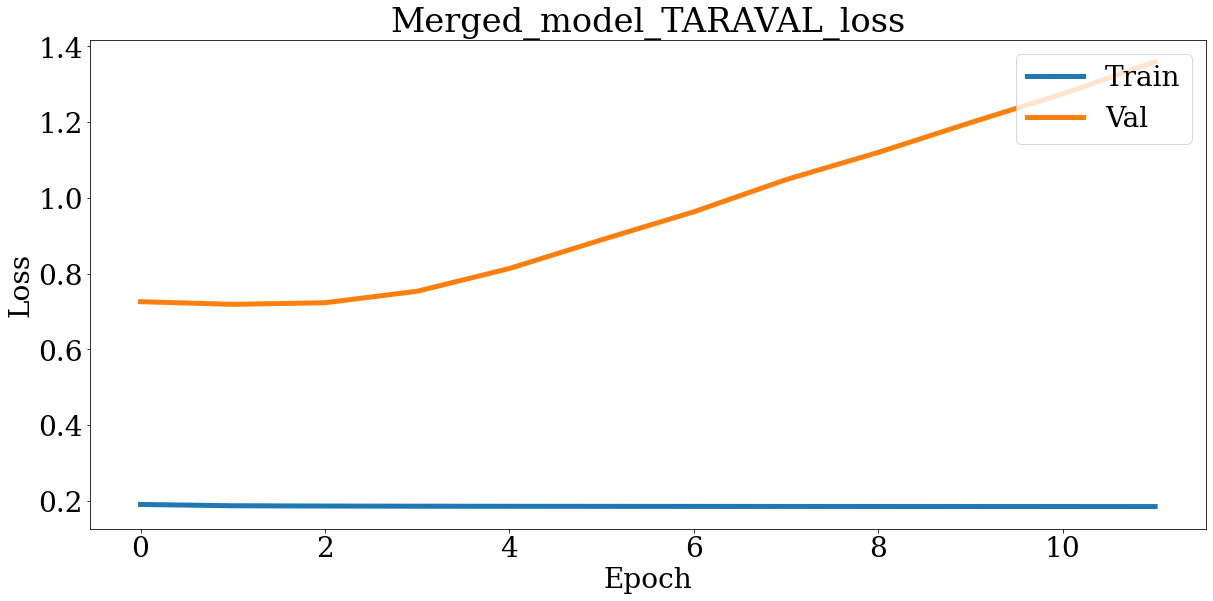

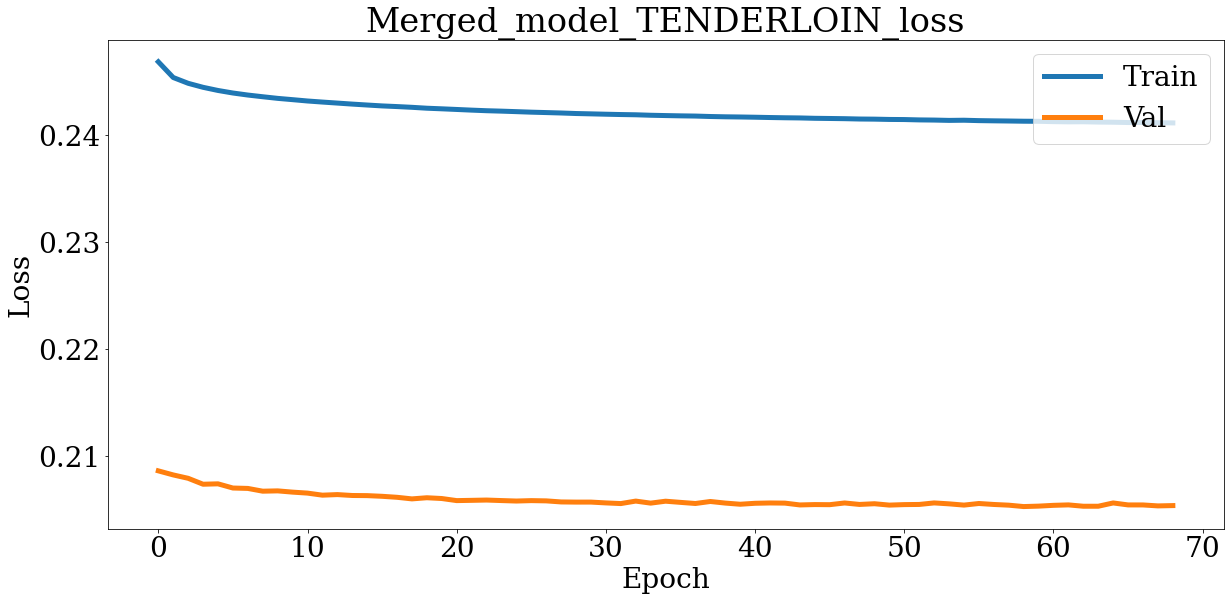

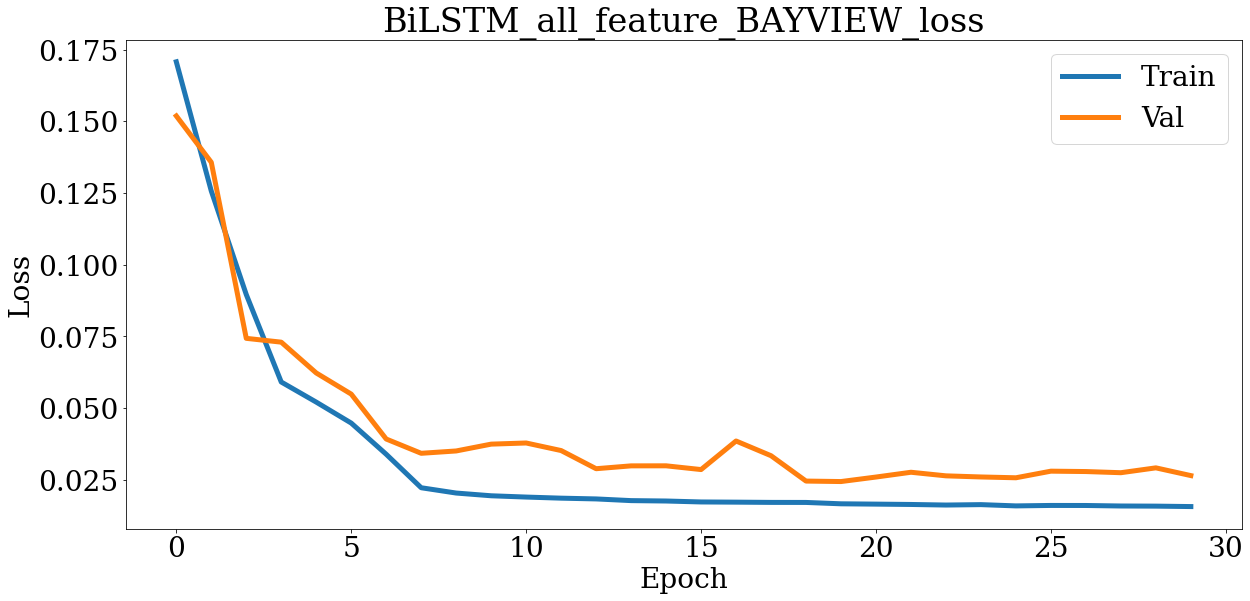

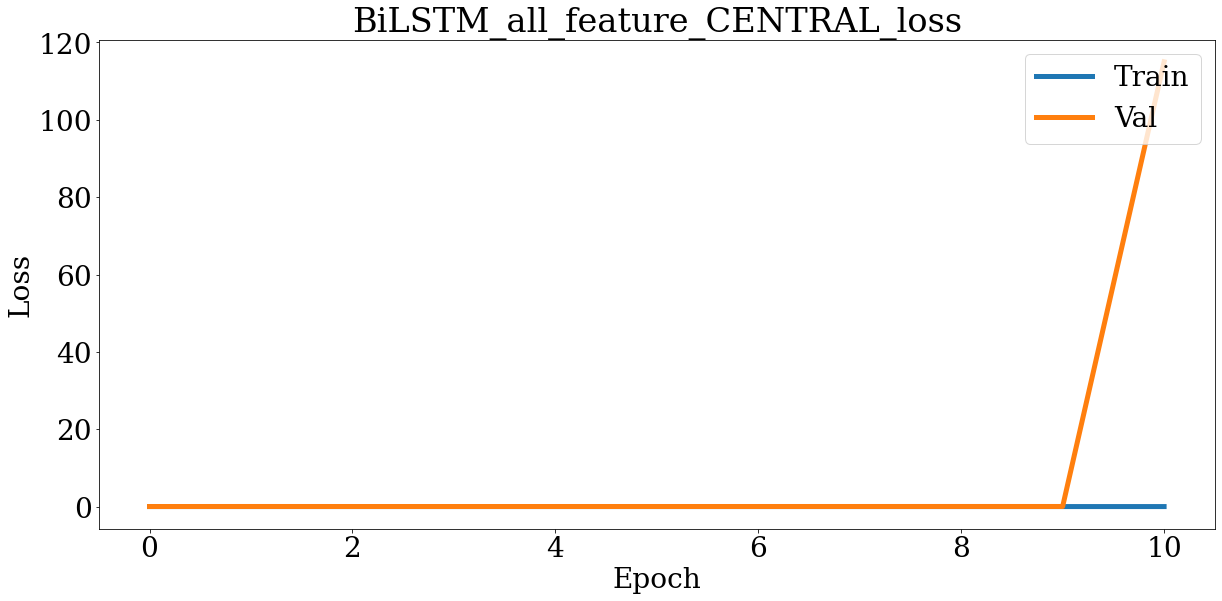

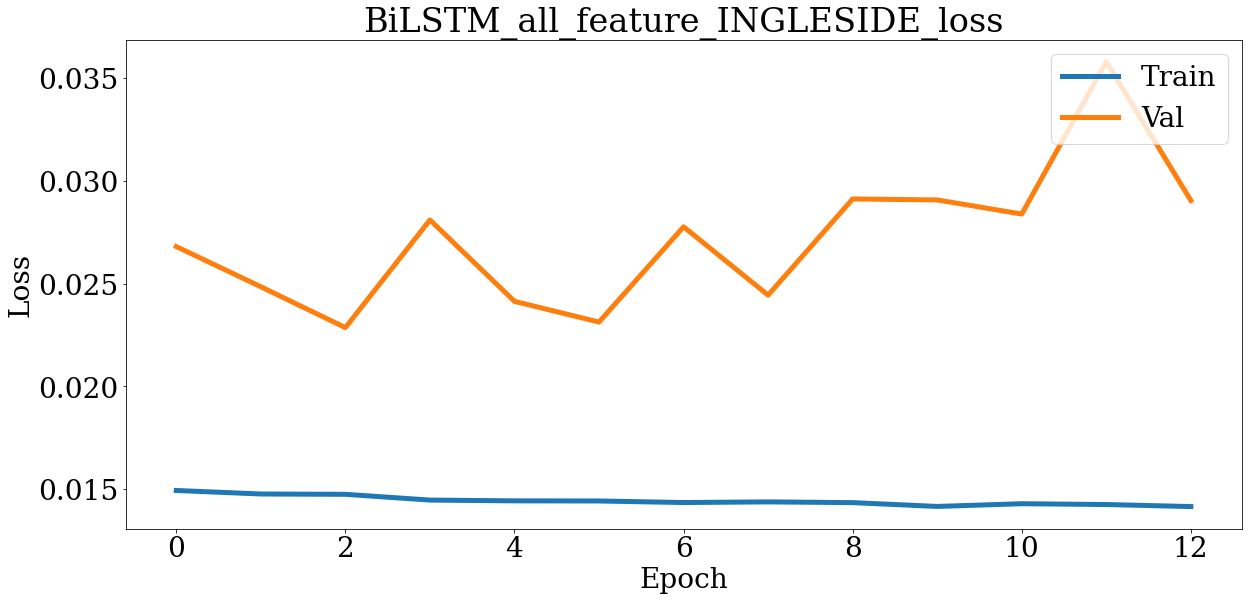

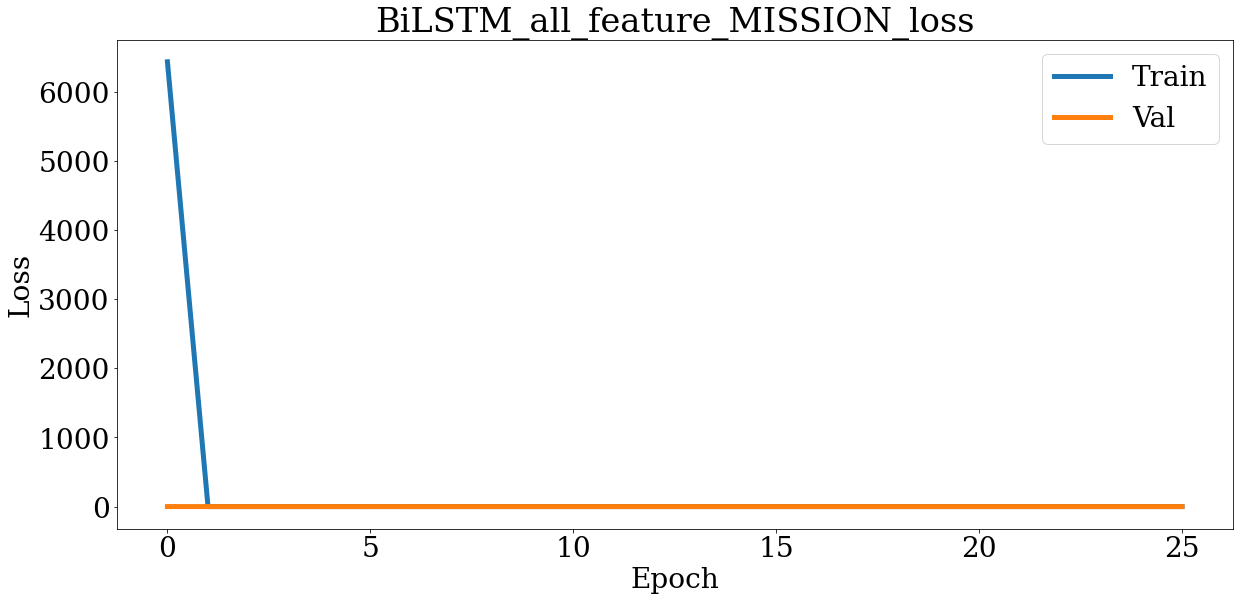

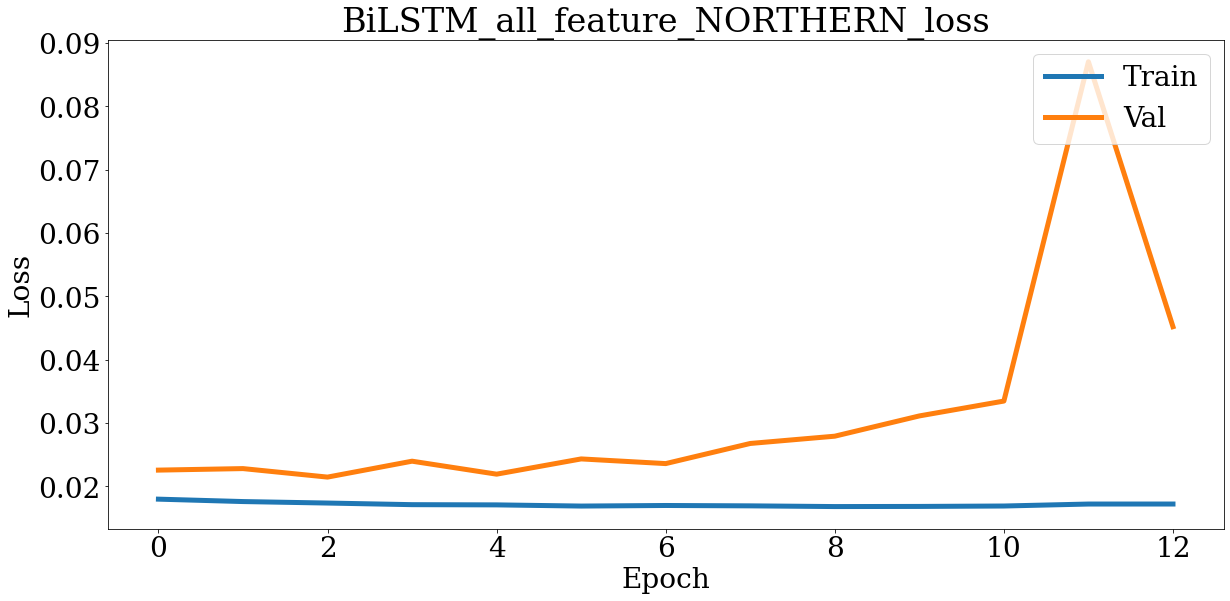

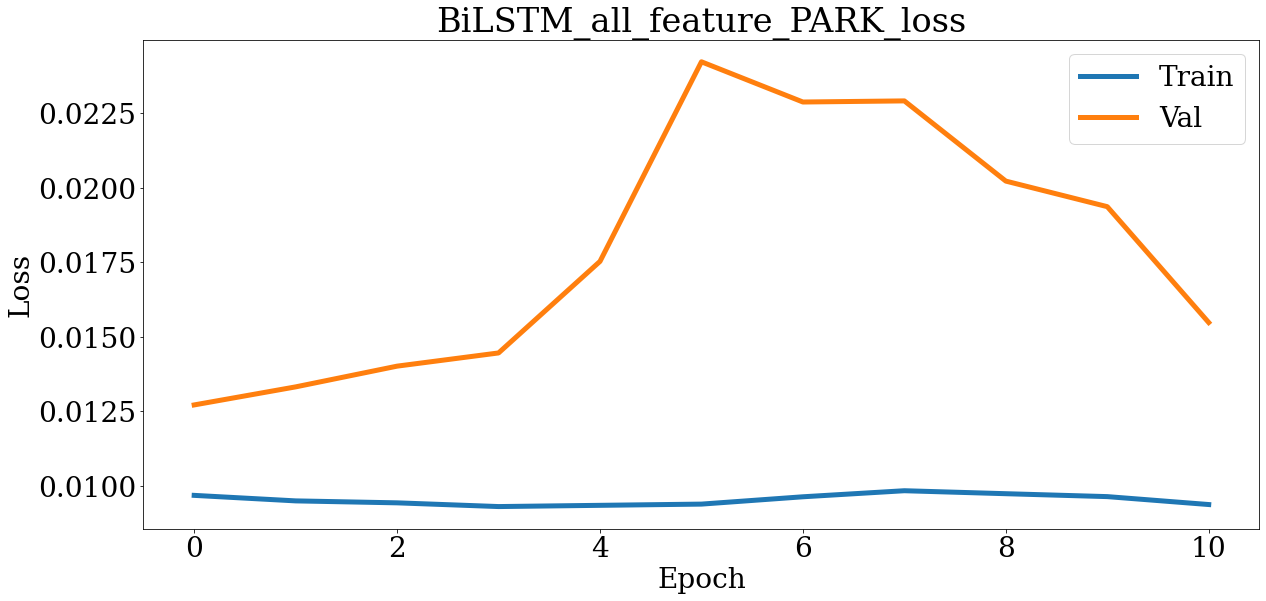

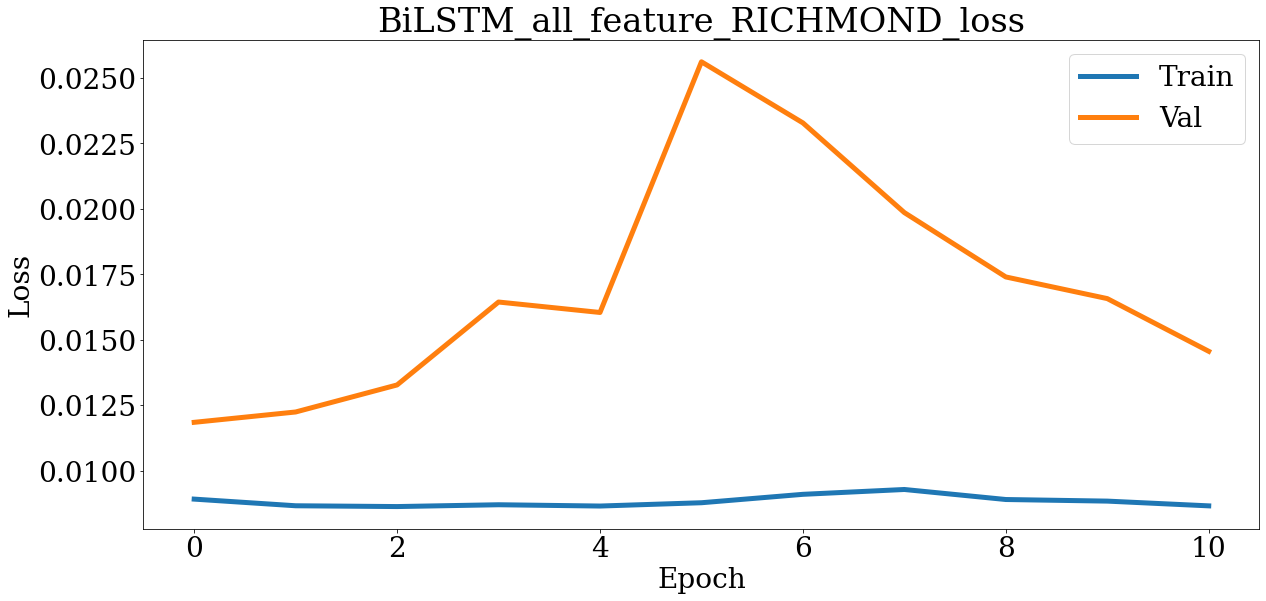

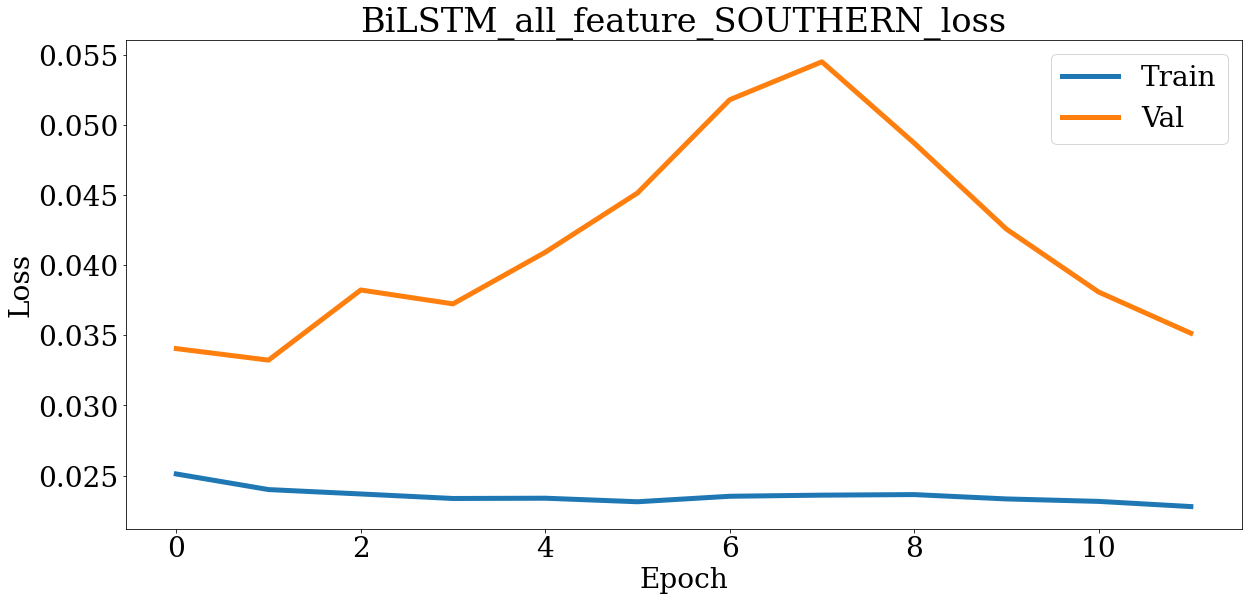

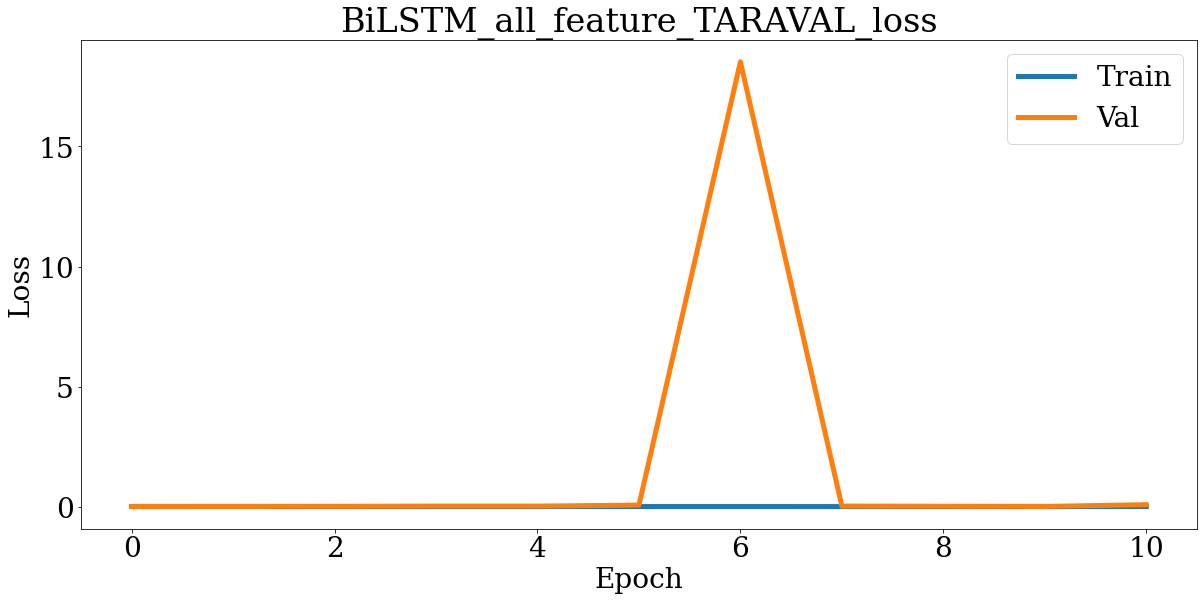

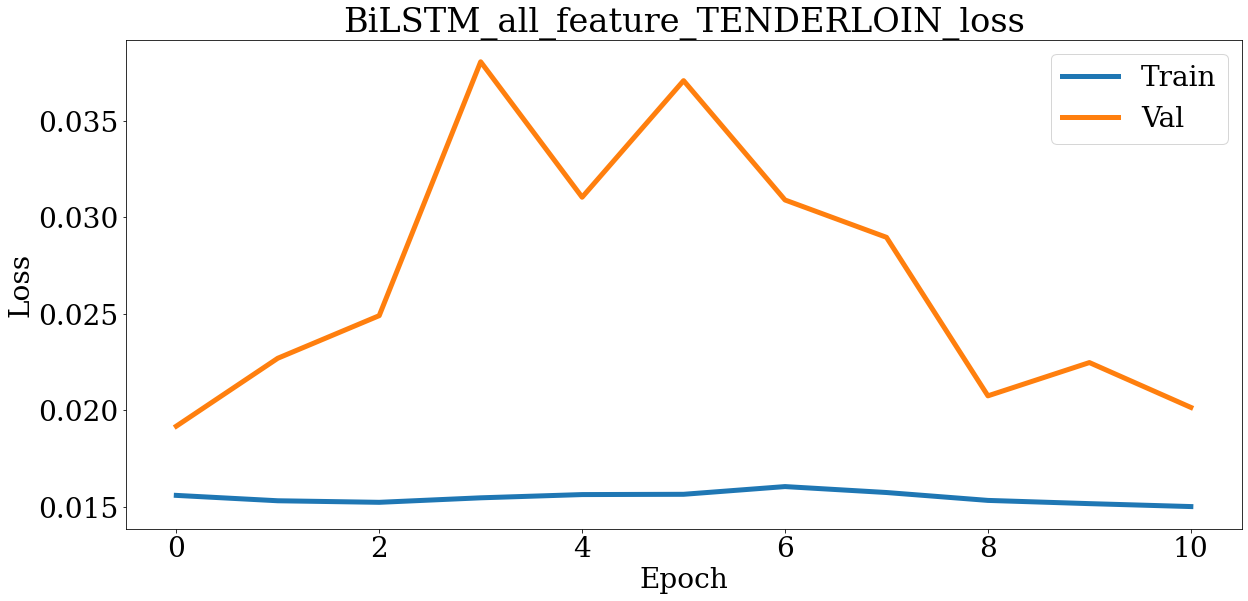

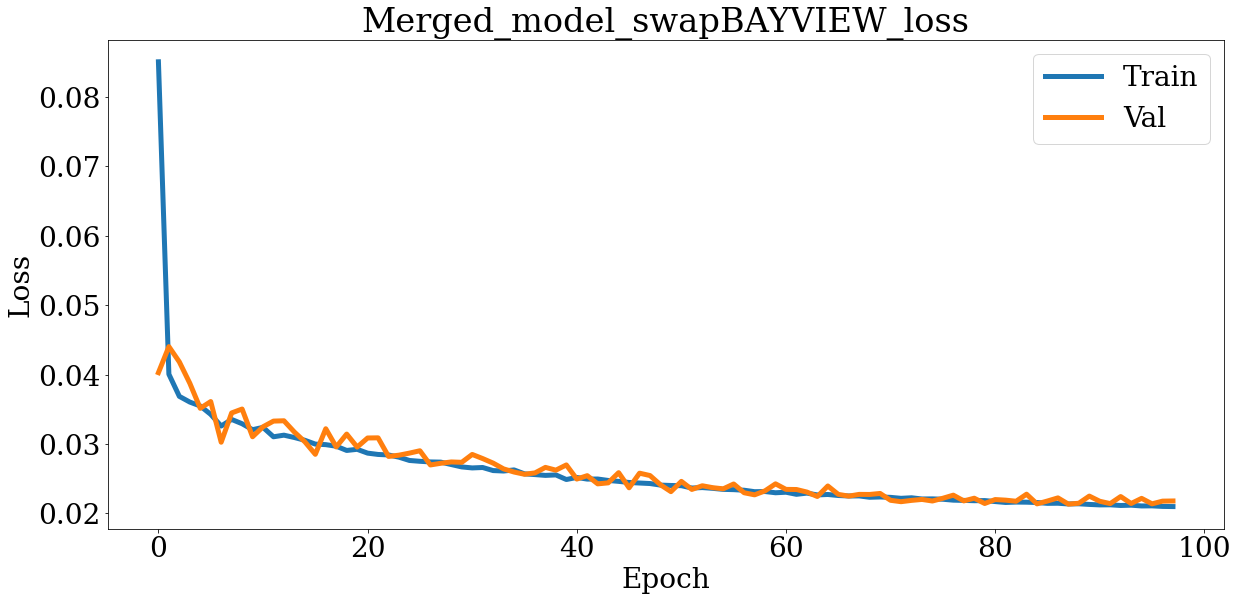

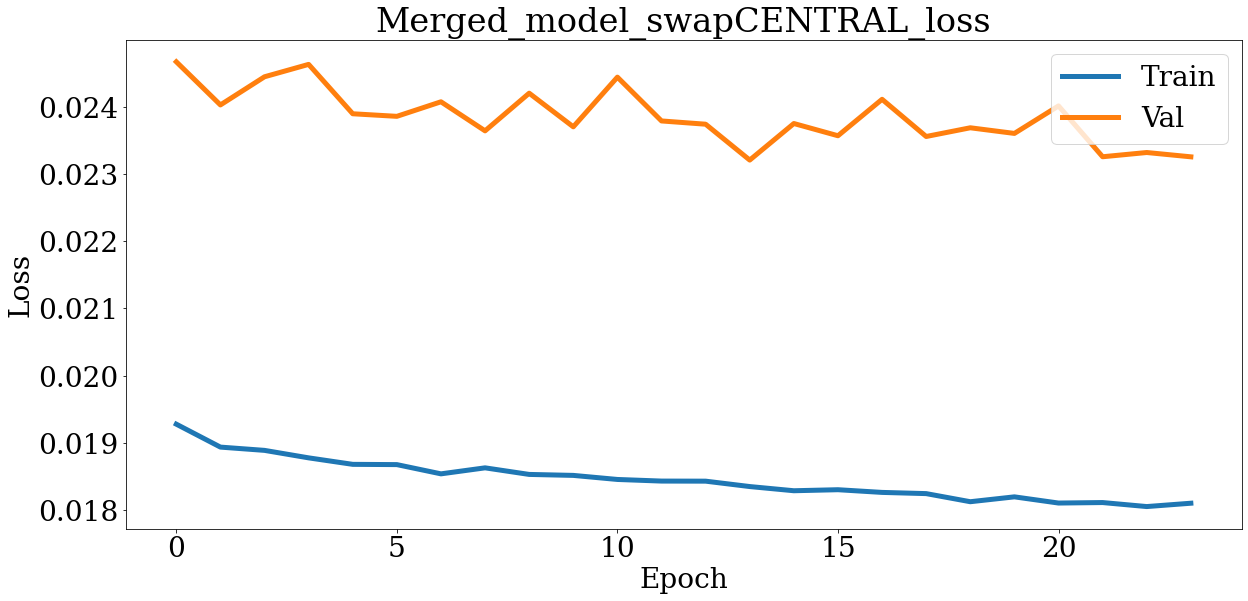

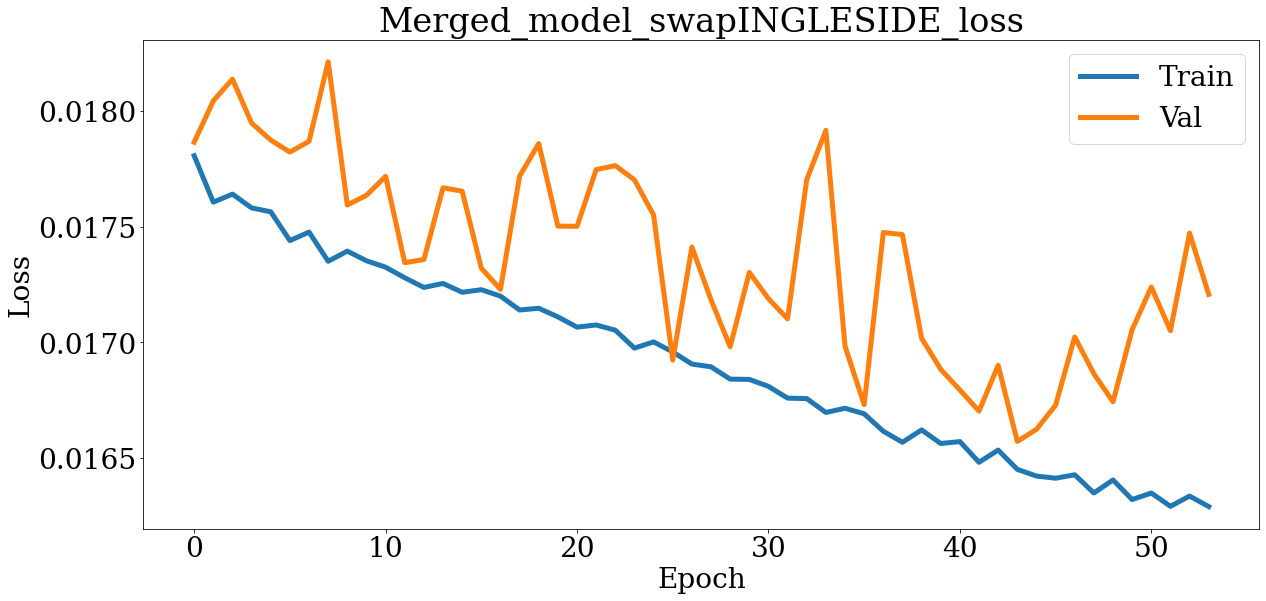

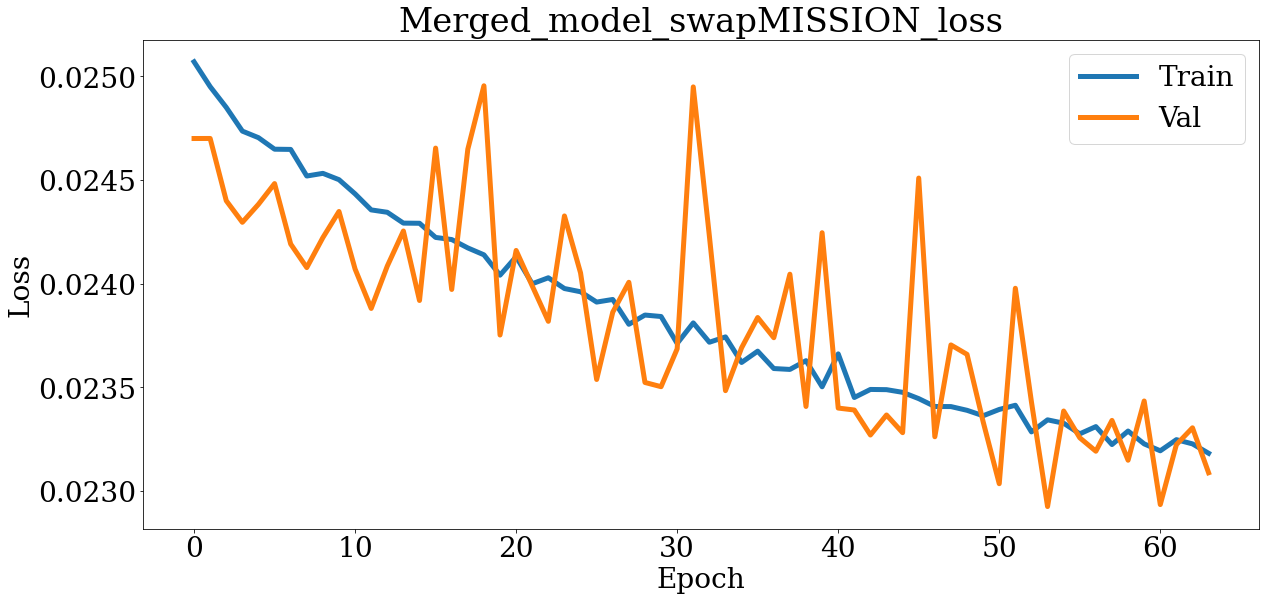

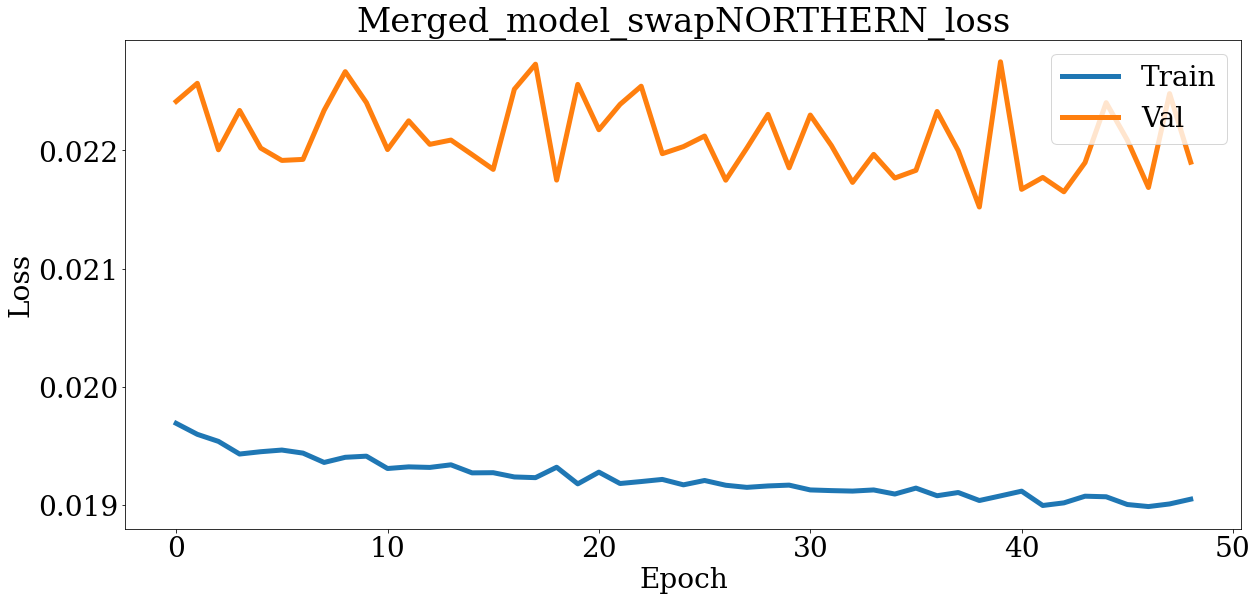

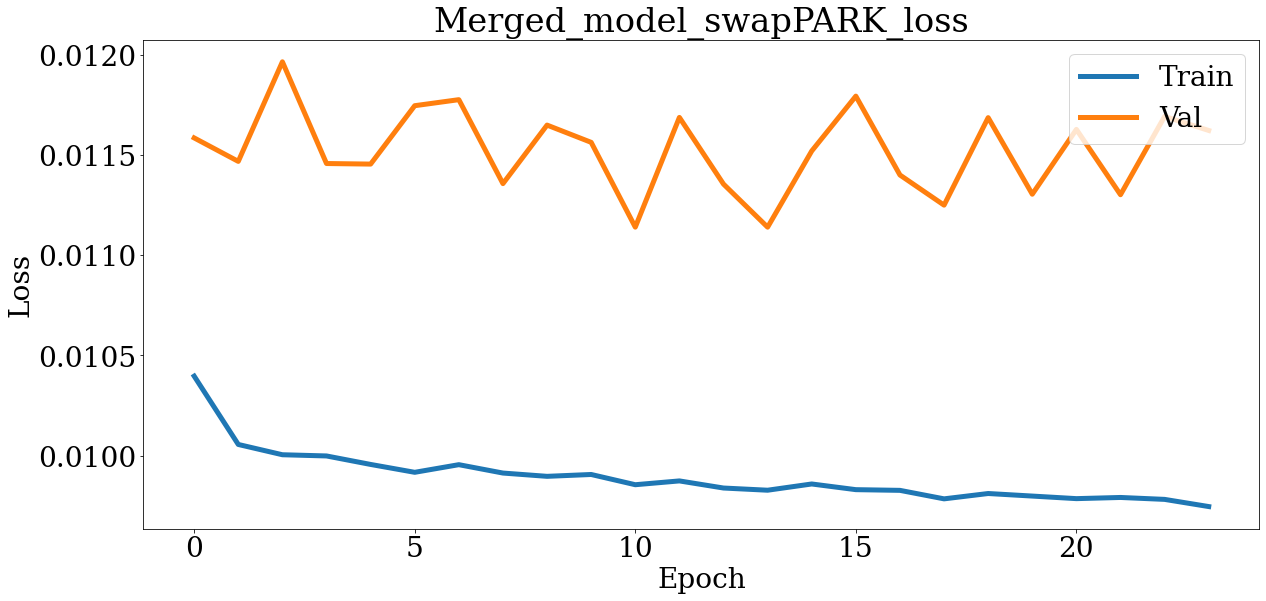

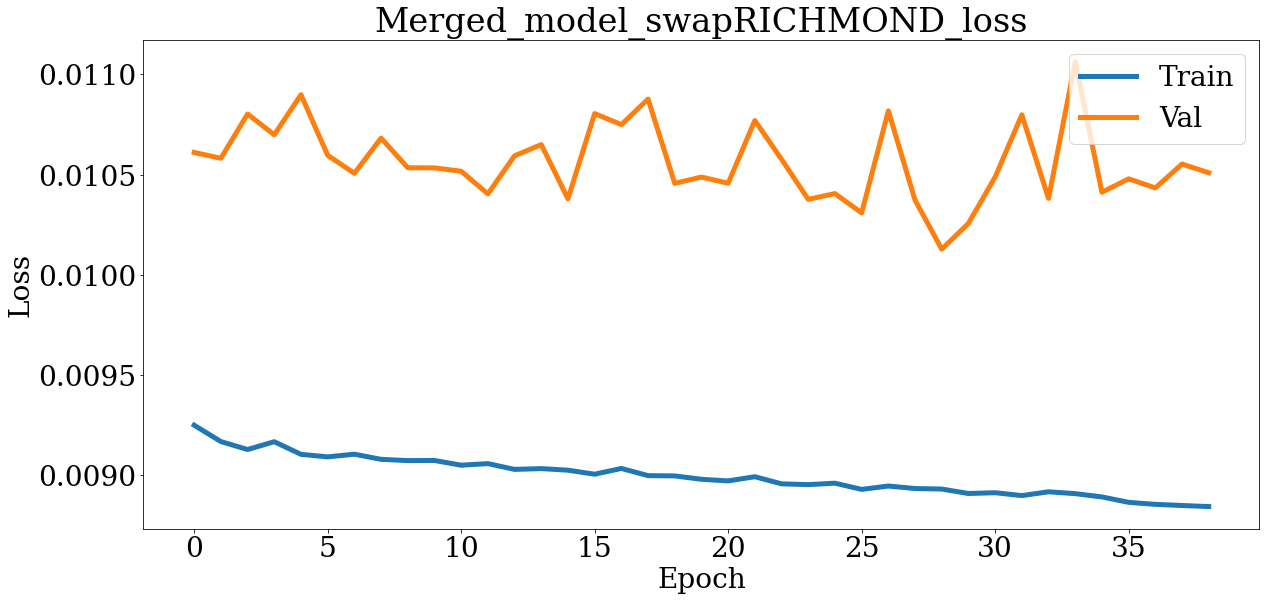

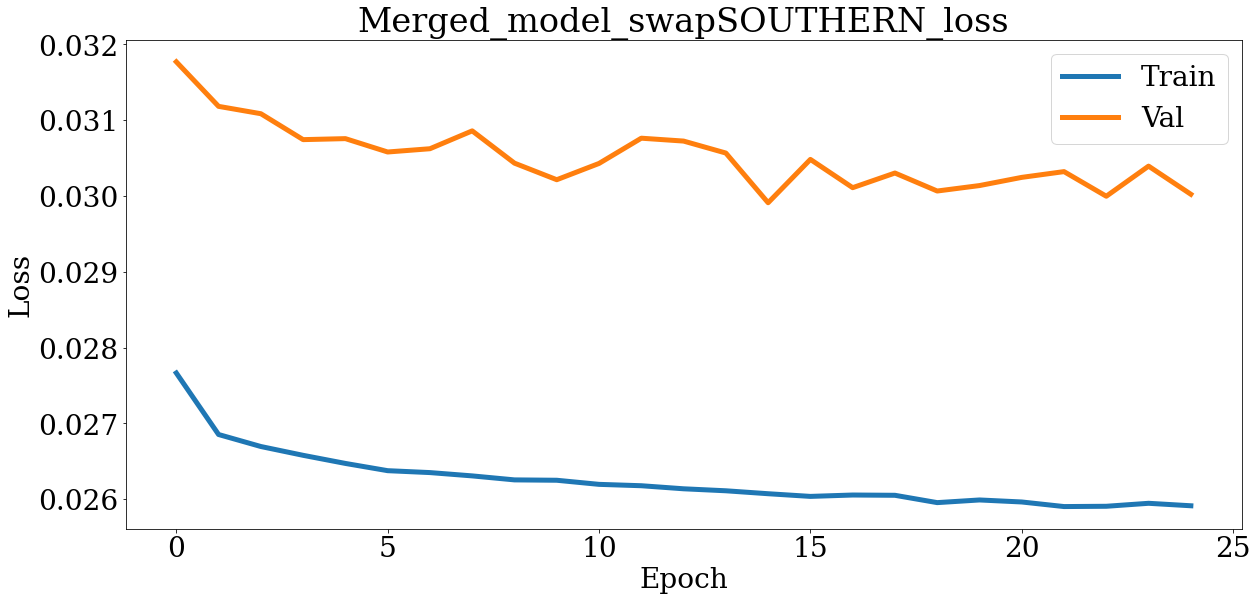

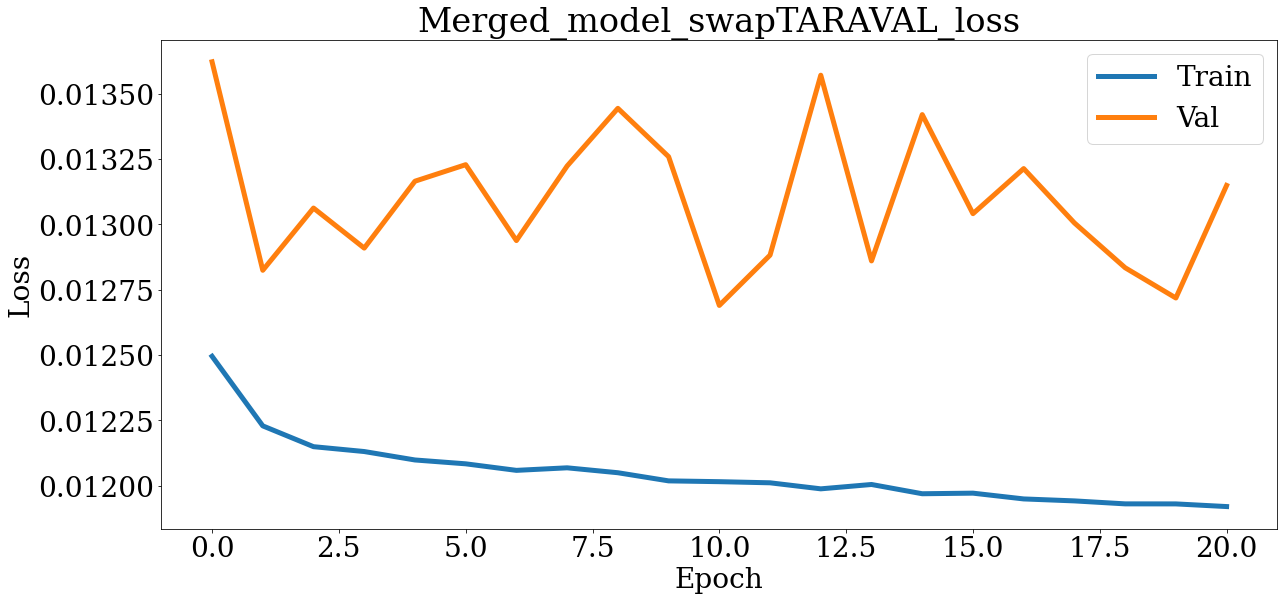

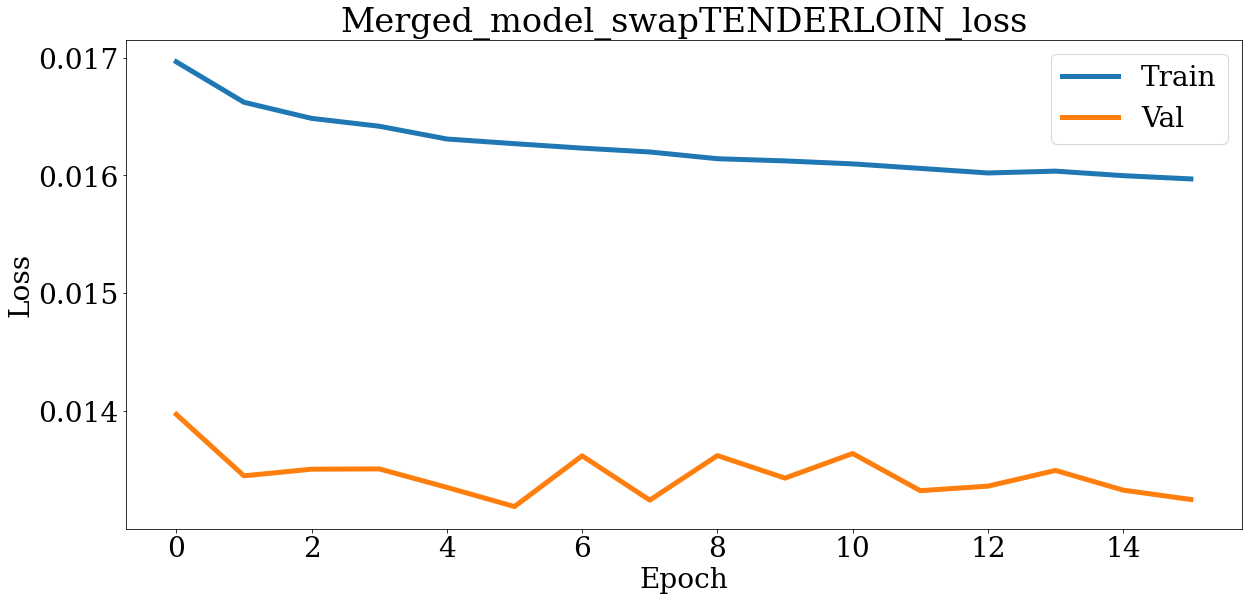

In [ ]:
plt.rcParams.update({'font.size': 28})
for key in histories.keys():
  plt.figure(figsize=(20, 9))
  
  plt.plot(list(histories[key]['loss'].values()),linewidth=5.0)
  plt.plot(list(histories[key]['val_loss'].values()),linewidth=5.0)
  plt.title(key+"_loss")
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right' , prop={'size':28})
  plt.show()

##Choosing prediction

In [ ]:
def getAllPairDistance(predictions):
    '''
    '''
    # predictions = [pred_now_merged , pred_now_attn , pred_now_lstm]
    lenPred = len(predictions)
    allPairDistance = [[1000000000 for i in range(lenPred)] for j in range(lenPred)]
    for i in range(lenPred):
        valid_data_now = predictions[i] # consider this a valid data
        for j in range(lenPred):
          if (j!= i):
            allPairDistance[i][j] = abs(valid_data_now.numpy() - predictions[j].numpy()) #why minus
          else:
            allPairDistance[i][j] = 0; #?

    return allPairDistance

def final_result(window_attention , window_bilstm):

    X_test_lstm , Y_test_lstm = window_bilstm.create_dataset2(window_bilstm.test)
    X_test_attention, Y_test_attention = window_attention.create_dataset2(window_attention.test)
    
    prediction_attention = attn_lstm_model_all_feature(X_test_attention)
    
    prediction_merged_swap = merged_model_swap([X_test_attention,X_test_lstm])
    prediction_bdLstm = bd_td_lstm_model_all_feature(X_test_attention)

    
    final_prediction = []
    per_hour_prediction = {}

    predictions = [prediction_attention , prediction_bdLstm , prediction_merged_swap]

    pred_now=25

    while (pred_now<50):
      pred_now_attn = prediction_attention[pred_now]
      pred_now_bilstm = prediction_bdLstm[pred_now]
      pred_now_merged_swap = prediction_merged_swap[pred_now]

      for hour_now in range(24):
        final_prediction.clear()
        # for per_category_merged, per_category_attn, per_category_bilstm , per_category_merged_swap in zip(pred_now_merged[hour_now],
        #                                                                        pred_now_attn[hour_now],
        #                                                                        pred_now_bilstm[hour_now] , pred_now_merged_swap[hour_now]):
        # per_cats = [pred_now_merged[hour_now],pred_now_attn[hour_now],pred_now_bilstm[hour_now] , pred_now_merged_swap[hour_now]] 
        
        for per_cats in zip(pred_now_attn[hour_now],pred_now_bilstm[hour_now] , pred_now_merged_swap[hour_now]): 
          '''
          assuming per_cats will be array if not array , convert it to array others should work
          '''
          #majorityVote or all pair dist
          cnt = [0 , 0 , 0]
          ok = False
          for i in range(len(per_cats)):
            for j in range(len(per_cats)):
              if(i==j):
                continue
              if per_cats[i]==per_cats[j]:
                cnt[i] = cnt[i]+1
          for i in range(len(per_cats)):
            if(cnt[i]>1):
              ok = True
              final_prediction.append(per_cats[i])
              break
          if(ok==False):
            allPairDistance = getAllPairDistance(per_cats)
            # print("ALL" , allPairDistance) #deltethis
            meanAllPairDistance = []*4
            meanAllPairDistance = np.mean(np.array(allPairDistance),axis= 1)
            # print("mean" , meanAllPairDistance) #delete this
            meanAllPairDistance = np.array(meanAllPairDistance) 
            
            minIndex = np.argmin(meanAllPairDistance) #taking index which has minimum avg
            
            if minIndex<4 :
              final_prediction.append(abs(per_cats[minIndex])*100)
            else:
              final_prediction.append(abs(per_cats[3])*100)

        per_hour_prediction[hour_now] = final_prediction
        # break #delte this 
      pred_now = pred_now+1
      # break#delete this
      
    return per_hour_prediction

In [ ]:
def get_input_data(window1):
    '''
    given model,window , plot_col , it will generate plotable data
    '''
    input_data = []
    for res1 in (window1.test):
        inputs1, labels1 = res1
        n=0
        while(n<len(inputs1)):
            input_data.append(labels1[n, :, :])
            n = n + 24

    input_data = np.array(input_data)

    return input_data

In [ ]:
Fprediction = {}
input_data = {}
total_count_pred = {}
rand_districts = ['BAYVIEW' , 'CENTRAL' , 'INGLESIDE' , 'MISSION' , 'NORTHERN' , 'PARK' , 'RICHMOND' , 'SOUTHERN' , 'TARAVAL' , 'TENDERLOIN']
# rand_districts = [ 'CENTRAL','SOUTHERN', 'BAYVIEW']
window2 = generate_window2(df2)

models_name = 'merged_model'
labels = ['LARCENY','OTHER OFFENSES','NON-CRIMINAL','ASSAULT', 'VEHICLE THEFT', 'DRUG/NARCOTIC','VANDALISM', 'GRP0','GRP1','GRP2'] 

for i in range(len(rand_districts)):
    dis_now = rand_districts[i]
    window1 = generate_window(all_datasets[dis_now])
    Fprediction[dis_now] = final_result(window1,window2)
    total_count_pred[dis_now] = Fprediction[dis_now][5].pop(7)
    input_data[dis_now] = get_input_data(window1)
    # input_data[dis_now] = np.delete(input_data[dis_now][2][5],7)


In [ ]:
# Fprediction [city_name][hour][category]
# input_data['BAYVIEW'].shape // count / hour / category 
_temp_data = []
for j in range(24):
    _x = np.delete(input_data['BAYVIEW'][0][j], 7)
    _temp_data.append(_x)

In [ ]:
_temp_data = np.array(_temp_data)
_temp_data = _temp_data.flatten()
_temp_data.shape

(240,)

In [ ]:
_x = np.array(list(Fprediction['BAYVIEW'].values()))
_x = _x.flatten()
_x.shape

(240,)

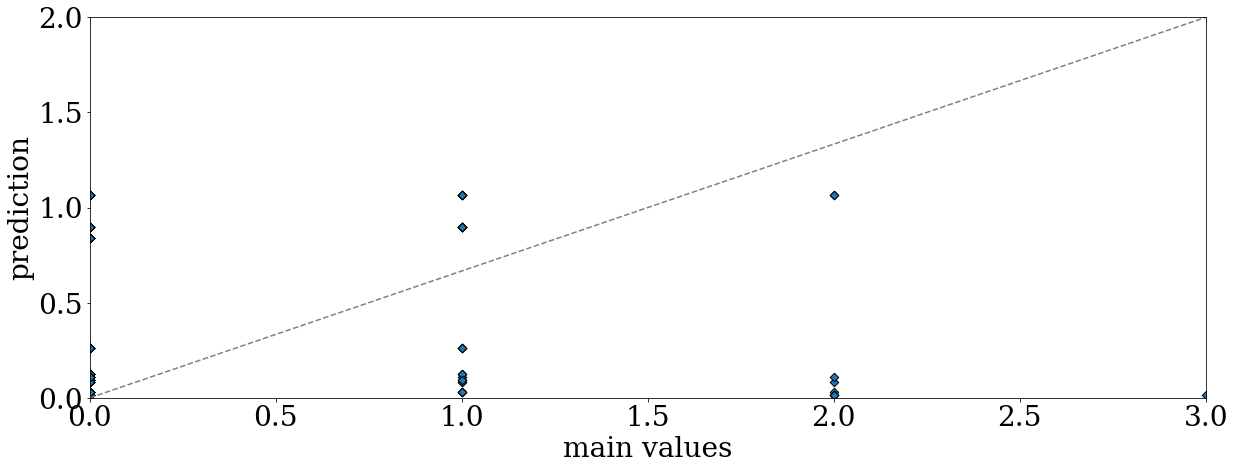

In [ ]:
fig = plt.figure(figsize =(20, 7))
  
# Creating plot
plt.scatter(_temp_data, _x,  marker= "D", edgecolors="black")
x = np.linspace(0,3,20)
y = np.linspace(0,2,20)
plt.plot(x,y,'--m', color= "gray")
plt.xlim(0,3)
plt.ylim(0,2)
plt.ylabel("prediction")
plt.xlabel("main values")

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


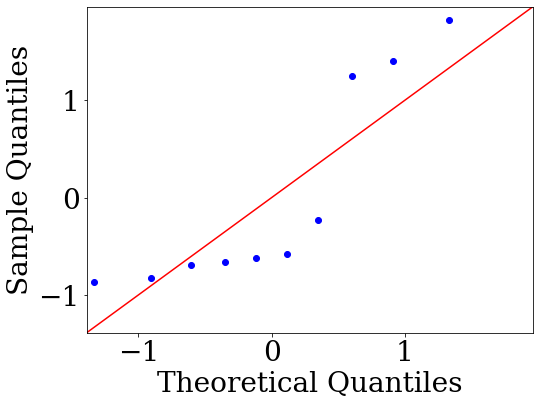

In [ ]:
import numpy as np
import statsmodels.api as sm
import pylab

# test = np.random.normal(0,1, 1000)

sm.qqplot(np.array(Fprediction['BAYVIEW'][0]),fit=True, line='45')
pylab.show()

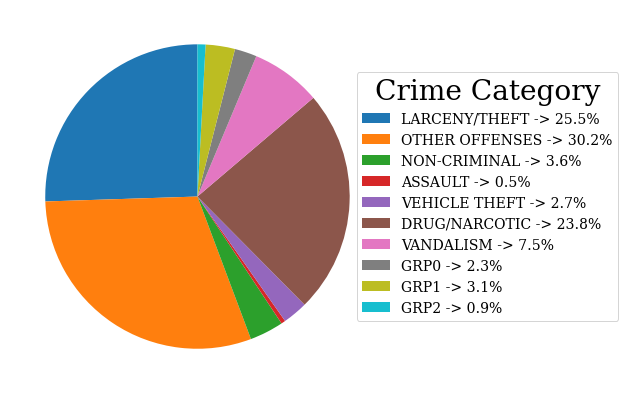

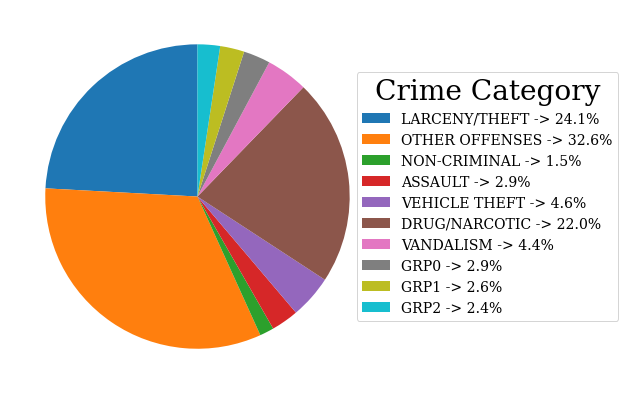

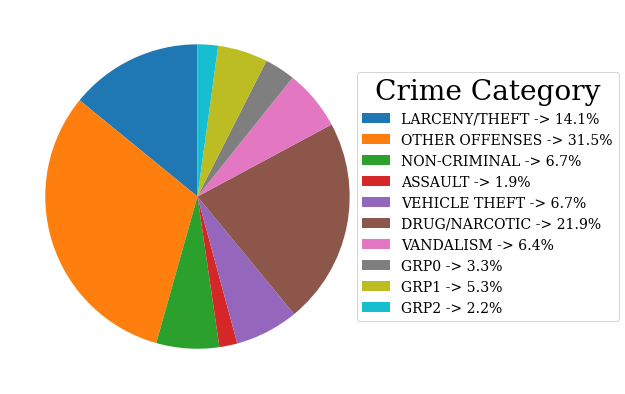

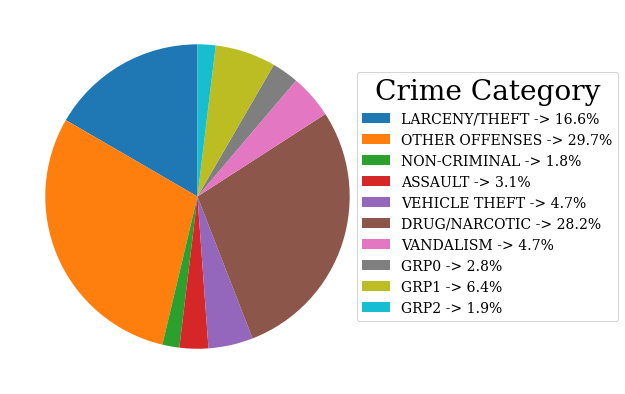

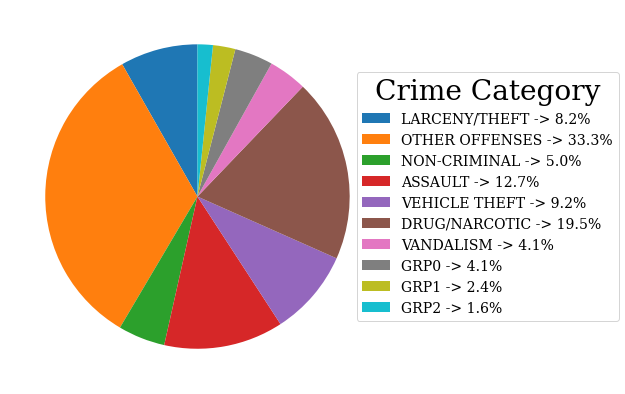

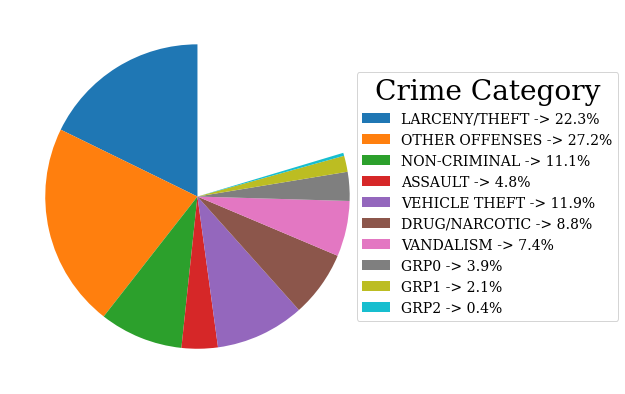

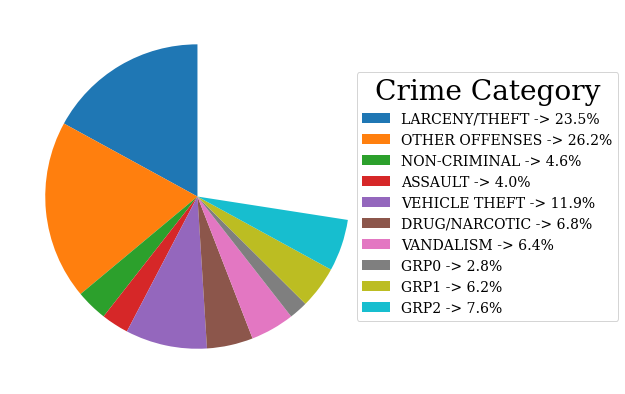

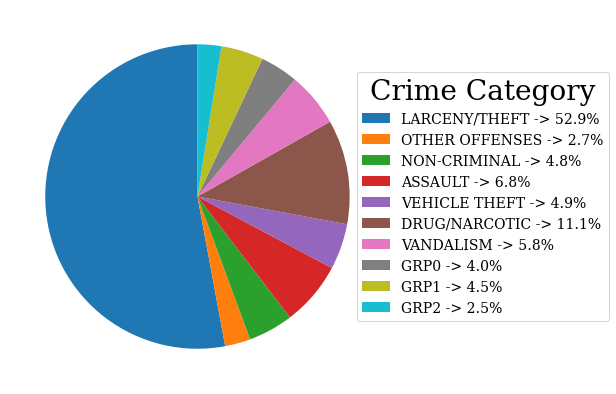

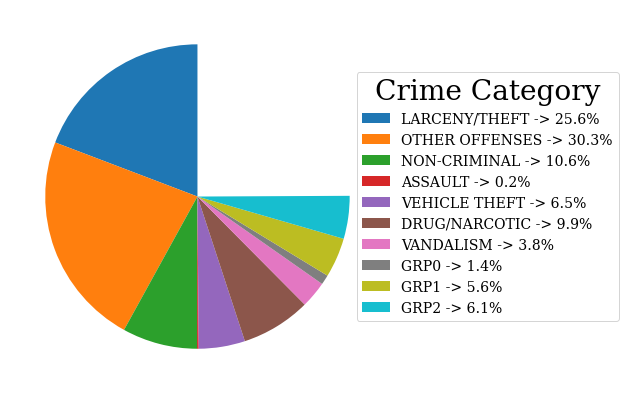

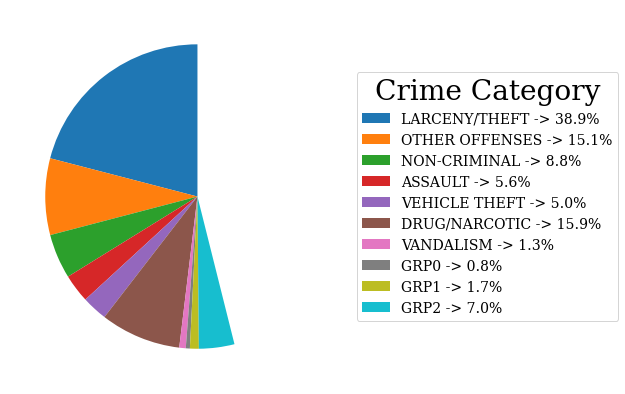

In [ ]:
for dis_now in rand_districts:
  labels = ['LARCENY/THEFT','OTHER OFFENSES','NON-CRIMINAL','ASSAULT', 'VEHICLE THEFT', 'DRUG/NARCOTIC','VANDALISM', 'GRP0','GRP1','GRP2'] 

  fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))

  ## To iterate through lambda function
  i = itertools.count()

  ## For lambda function
  def func(pct, allvals, i):
    category_name = allvals[i]
    return "{:.1f}%".format(pct)

  def get_percentage(data):
    sum_val = sum(data)
    percentage_val = []
    for i in range(len(data)):
      percentage_val.append(data[i]*100/sum_val)
    return percentage_val 

  wedges, texts = ax.pie(Fprediction[dis_now][23], textprops = dict(color = "w"),startangle=90)
  
  

  labels = [f'{l} -> {s:1.1f}%' for l, s in zip(labels, get_percentage(Fprediction[dis_now][23]))]
  ax.legend(wedges, labels,
          title="Crime Category",
          loc="center left",
          bbox_to_anchor=(.9, 0, 0, 1),
          prop = {'size': 14})
  
  
  # plt.setp(autotexts, size=12, weight="bold")

  plt.savefig(ROOTPATH+"/images/San_Francisco/proposed_model_1_hour_prediction_"+dis_now+".png")
  plt.show()


In [ ]:
final_performance = {}
final_val_performance = {}

for x in Police_dept_name:
  final_performance[x] = [0]*len(metrics_name)
  final_val_performance[x] = [0]*len(metrics_name)
for x, key1, key2, key3 in zip(Police_dept_name, performance_attn_all.keys(),performance_swap.keys(),performance_bd.keys()):
  for i in range(7):
    q = 1.0
    if(i!=3):
      q = 3.0
    final_performance[x][i] = (.5*performance_attn_all[key1][i] + .4* performance_swap[key2][i]  + .1* performance_bd[key3][i] ) /q
    final_val_performance[x][i] = (.5*val_performance_attn_all[key1][i] + .4* val_performance_swap[key2][i]  + .1* val_performance_bd[key3][i] ) /q

In [ ]:
print(f'{"model":50s}: val_mape | test_mape | val_smape | test_smape | val_mda | test_mda')
for key in final_performance.keys():
    # print(f'{key:50s}MAE : {final_val_performance[key][0]:.4f} | {final_performance[key][0]:.4f}')
    # print(f'{key:50s}MSLE : {final_val_performance[key][1]:.4f} | {final_performance[key][1]:.4f}')
    # print(f'{key:50s}MSE : {final_val_performance[key][2]:.4f} | {final_performance[key][2]:.4f}')
    # print(f'{key:50s}R^2 : {final_val_performance[key][3]:.4f} | {final_performance[key][3]:.4f}')
    print(f'{key:50s} : {final_val_performance[key][4]:.4f} | {final_performance[key][4]:.4f} | {final_val_performance[key][5]:.4f} | {final_performance[key][5]:.4f} | {final_val_performance[key][6]:.4f} | {final_performance[key][6]:.4f}')
    # print(f'{key:50s}sMAPE : {final_val_performance[key][5]:.4f} | {final_performance[key][5]:.4f}')
    # print(f'{key:50s}MDA : {final_val_performance[key][6]:.4f} | {final_performance[key][6]:.4f}')

model                                             : val_mape | test_mape | val_smape | test_smape | val_mda | test_mda
BAYVIEW                                            : 28.5365 | 28.5641 | 0.0093 | 0.0090 | 0.0868 | 0.0860
CENTRAL                                            : 27.7082 | 27.7408 | 0.0097 | 0.0095 | 0.0922 | 0.0910
INGLESIDE                                          : 28.8527 | 29.2583 | 0.0079 | 0.0071 | 0.0804 | 0.0747
MISSION                                            : 28.6275 | 27.8071 | 0.0228 | 0.0242 | 0.1020 | 0.1099
NORTHERN                                           : 28.1587 | 28.1517 | 0.0124 | 0.0124 | 0.0980 | 0.0990
PARK                                               : 30.6785 | 30.8026 | 0.0090 | 0.0080 | 0.0626 | 0.0592
RICHMOND                                           : 30.1469 | 29.9693 | 0.0062 | 0.0061 | 0.0590 | 0.0612
SOUTHERN                                           : 25.9955 | 25.9269 | 0.0115 | 0.0110 | 0.1199 | 0.1208
TARAVAL                  

In [ ]:
PATH_IMAGE = ROOTPATH+"/images/San_Francisco/"
def plotMetrixGraph(performance_now , val_performance_now , metric_index , ylabel , metric_name , model_name,rotation=90):
    plt.figure(figsize=(20, 7))
    x = np.arange(len(performance_now))
    width = 0.3
    
    val_mae = [v[metric_index] for v in val_performance_now.values()]
    test_mae = [v[metric_index] for v in performance_now.values()]

    
    plt.ylabel(ylabel+' [count, normalized]' , fontsize=25)
    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=performance_now.keys(),
            rotation=rotation,fontsize = 25)
    locs , labels = plt.yticks()
    plt.yticks(locs , fontsize=25)
    _ = plt.legend(prop={'size': 25})
    
    plt.savefig(PATH_IMAGE+"/"+model_name+"_"+metric_name+".png")


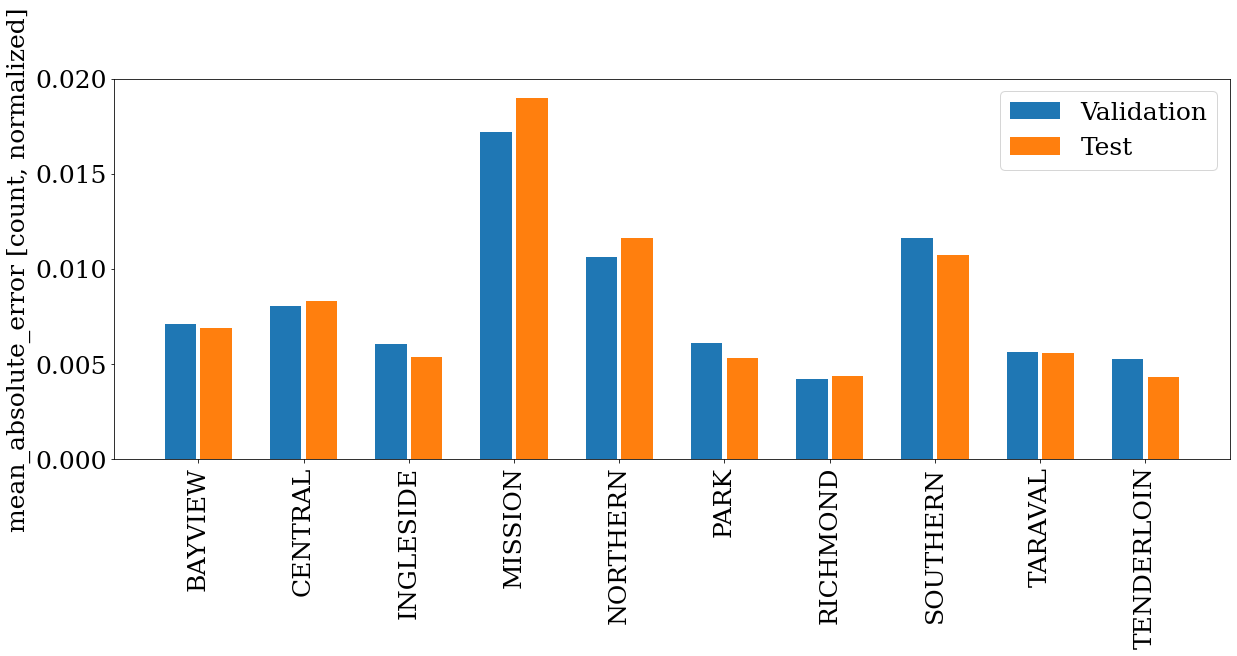

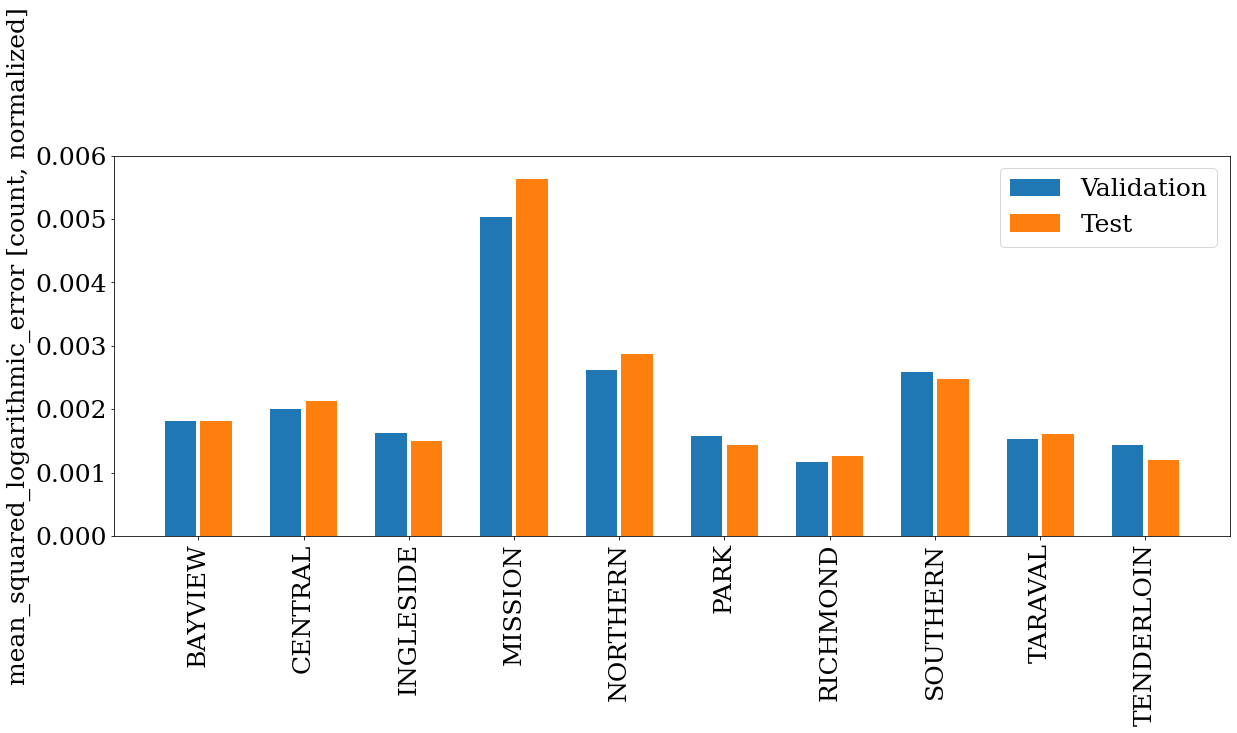

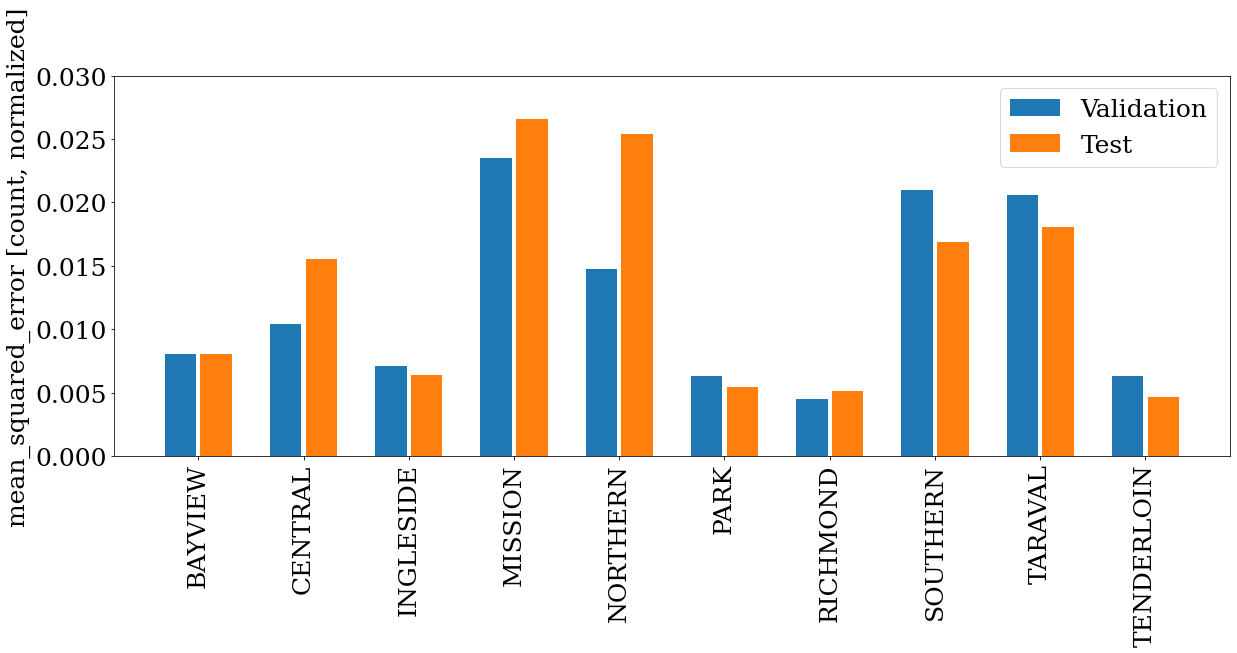

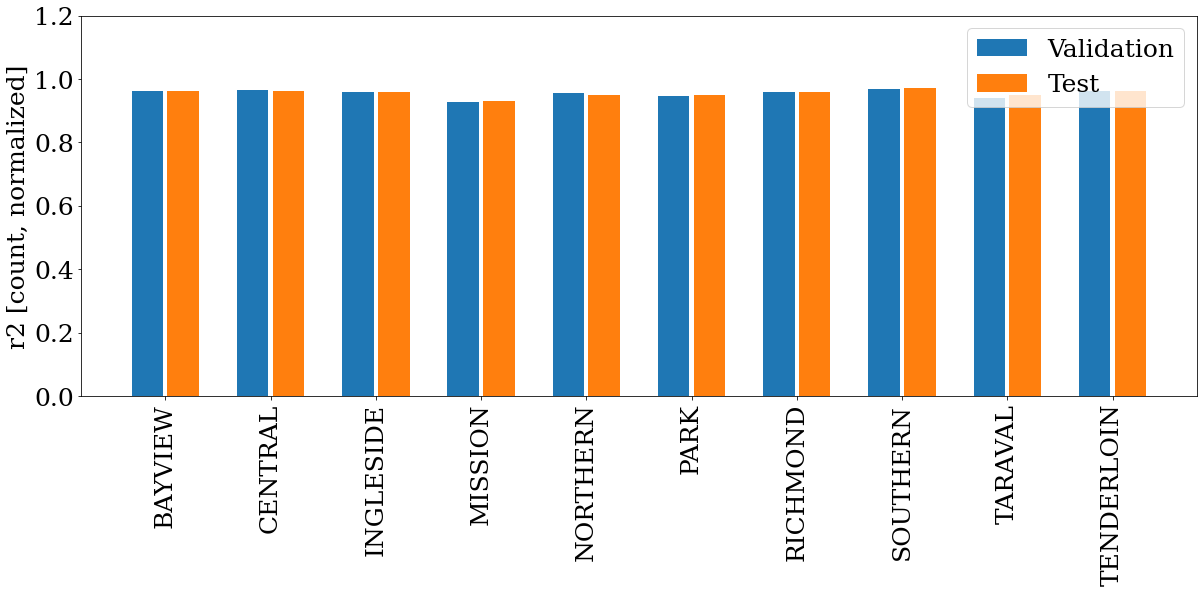

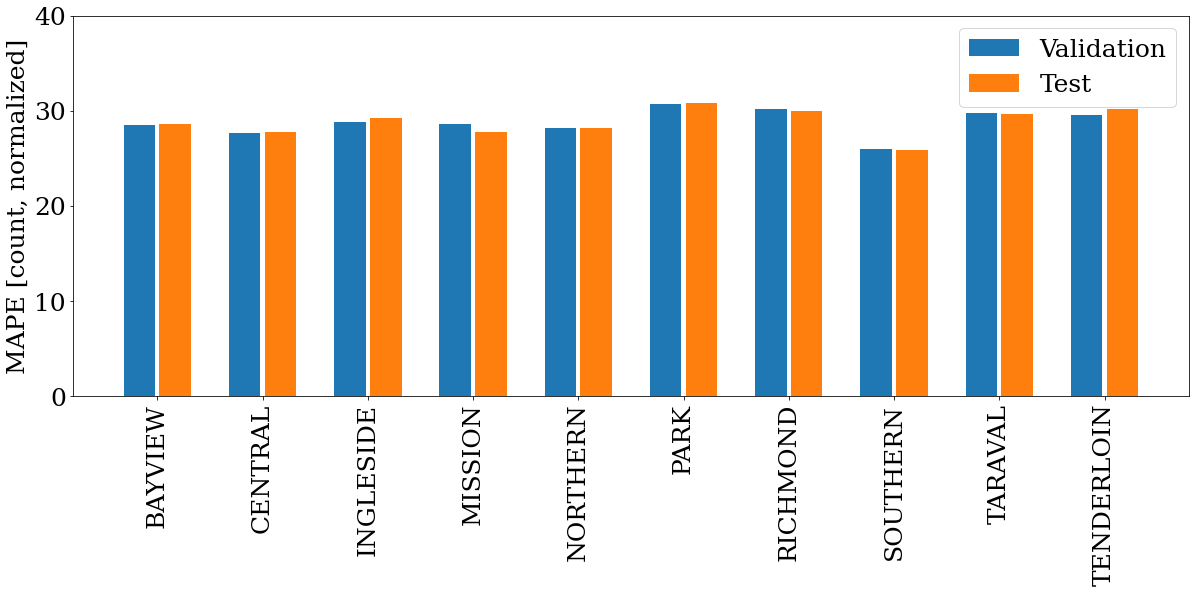

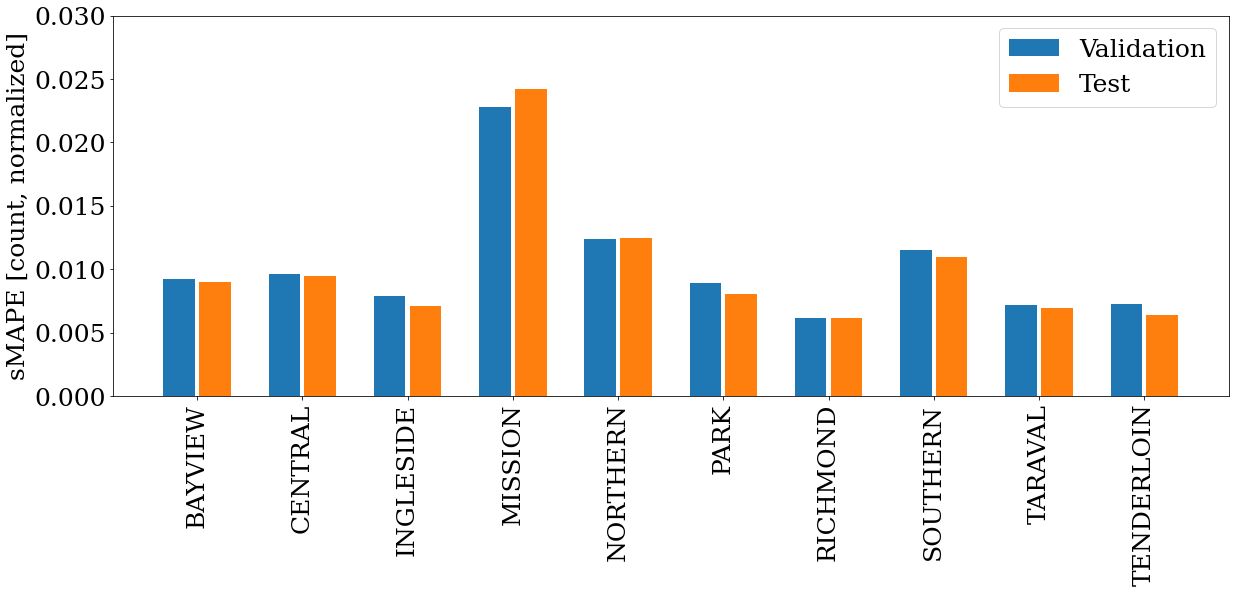

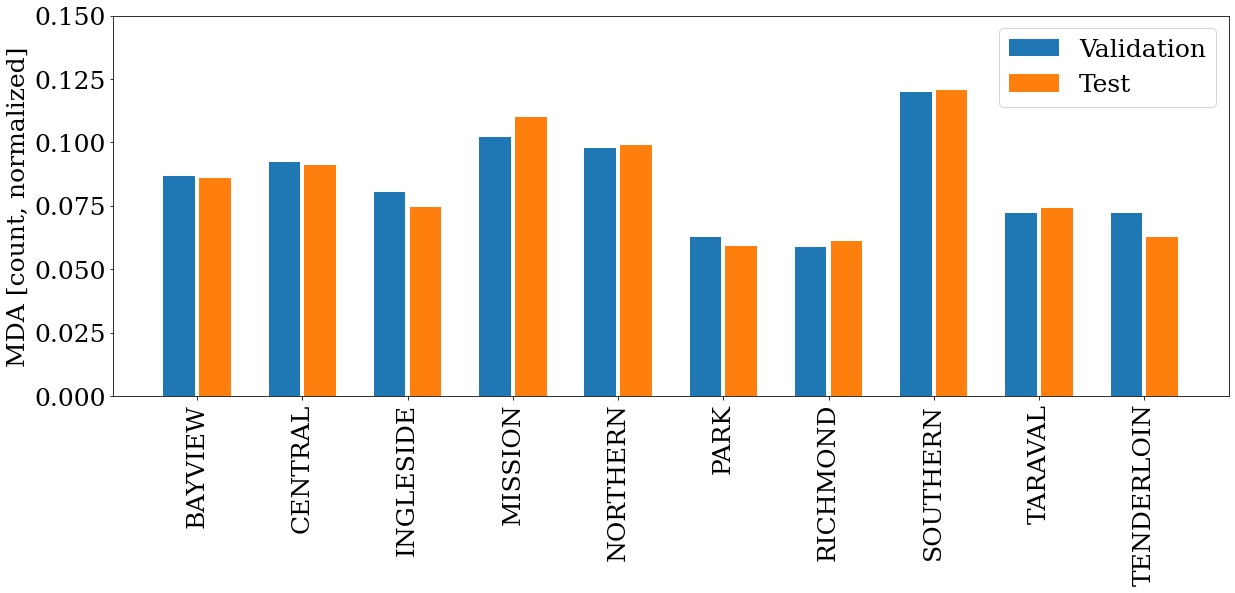

In [ ]:
ylabels = ['mean_absolute_error' , 'mean_squared_logarithmic_error','mean_squared_error' , 'r2' , 'MAPE' , 'sMAPE' , 'MDA']
for i in range(7):
    plotMetrixGraph(final_performance , final_val_performance , i , ylabels[i] , ylabels[i] , '')

In [ ]:
def AVG_result(model_name = None):
  all_performance_mae = 0
  all_performance_msle = 0
  all_performance_mse = 0
  all_performance_r2 = 0
  all_performance_mape = 0
  all_performance_smape = 0 
  all_performance_mda = 0

  all_val_performance_mae = 0
  all_val_performance_msle = 0
  all_val_performance_mse = 0
  all_val_performance_r2 = 0
  
  all_val_performance_mape = 0
  all_val_performance_smape = 0 
  all_val_performance_mda = 0

  for x in Police_dept_name:
    all_performance_mae += final_performance[x][0]
    all_performance_msle += final_performance[x][1]
    all_performance_mse += final_performance[x][2]
    all_performance_r2 += final_performance[x][3]
    
    all_performance_mape += final_performance[x][4]
    all_performance_smape +=final_performance[x][5]
    all_performance_mda +=final_performance[x][6]
    
    all_val_performance_mae += final_val_performance[x][0]
    all_val_performance_msle += final_val_performance[x][1]
    all_val_performance_mse += final_val_performance[x][2]
    all_val_performance_r2 += final_val_performance[x][3]
    all_val_performance_mape += final_val_performance[x][4]
    all_val_performance_smape += final_val_performance[x][5]
    all_val_performance_mda += final_val_performance[x][6]

  avg_performance_mae = all_performance_mae / 10.0
  avg_performance_msle = all_performance_msle / 10.0
  avg_performance_mse = all_performance_mse / 10.0
  avg_performance_r2 = all_performance_r2 / 10.0
  avg_performance_mape = all_performance_mape/10.0
  avg_performance_smape = all_performance_smape/10.0
  avg_performance_mda = all_performance_mda/10.0

  avg_val_performance_mae = all_val_performance_mae / 10.0
  avg_val_performance_msle = all_val_performance_msle / 10.0
  avg_val_performance_mse = all_val_performance_mse / 10.0
  avg_val_performance_r2 = all_val_performance_r2 / 10.0
  avg_val_performance_mape = all_val_performance_mape / 10.0
  avg_val_performance_smape = all_val_performance_smape / 10.0
  avg_val_performance_mda = all_val_performance_mda / 10.0

  print("val:")
  print(avg_val_performance_mae,avg_val_performance_msle,avg_val_performance_mse,avg_val_performance_r2,avg_val_performance_mape,avg_val_performance_smape,avg_val_performance_mda)
  print("test:")
  print(avg_performance_mae,avg_performance_msle,avg_performance_mse,avg_performance_r2 , avg_performance_mape,avg_performance_smape,avg_performance_mda)

In [ ]:
AVG_result()

val:
0.008191884672269223 0.0021404758398421114 0.012261973268662888 0.9549299603700637 28.807824529012045 0.010306787670900425 0.0844964893658956
test:
0.008152238105734188 0.002195787685923278 0.013215074709927041 0.9555004113912583 28.800813725789386 0.010072168608506522 0.08387938598791758


#### Table generation for latex

In [ ]:
#TABLE 4: Evaluation metrics of San Francisco for Proposedmodel
#{\multirow{2}{*}{\text{Bayview}}}& \text{Validation} &0.0142&0.0024&0.0124&0.9430\\ \cline{2-6}&\text{Test} &0.0140&0.0023&0.0124&0.9429\\ \hline
for key in final_performance.keys():
  datanow = "{\\multirow{2}{*}{\\text{"+key+"}}}& \\text{Validation} "
  for i in range(4):
    valueNow = round(final_val_performance[key][i] , 4)
    datanow = datanow+"&"+str(valueNow)
  datanow = datanow+'\\'+'\\'
  datanow = datanow+'\\cline{2-6}&\\text{Test} '
  for i in range(4):
    valueNow = round(final_performance[key][i] , 4)
    datanow = datanow+"&"+str(valueNow)
  datanow = datanow+'\\'+'\\'
  datanow = datanow + "\\hline"
  print(datanow)

{\multirow{2}{*}{\text{BAYVIEW}}}& \text{Validation} &0.0071&0.0018&0.008&0.9616\\\cline{2-6}&\text{Test} &0.0069&0.0018&0.008&0.9616\\\hline
{\multirow{2}{*}{\text{CENTRAL}}}& \text{Validation} &0.0081&0.002&0.0104&0.9652\\\cline{2-6}&\text{Test} &0.0083&0.0021&0.0156&0.9627\\\hline
{\multirow{2}{*}{\text{INGLESIDE}}}& \text{Validation} &0.006&0.0016&0.0071&0.9605\\\cline{2-6}&\text{Test} &0.0054&0.0015&0.0064&0.9596\\\hline
{\multirow{2}{*}{\text{MISSION}}}& \text{Validation} &0.0172&0.005&0.0235&0.9276\\\cline{2-6}&\text{Test} &0.019&0.0056&0.0265&0.9312\\\hline
{\multirow{2}{*}{\text{NORTHERN}}}& \text{Validation} &0.0106&0.0026&0.0147&0.956\\\cline{2-6}&\text{Test} &0.0116&0.0029&0.0254&0.9485\\\hline
{\multirow{2}{*}{\text{PARK}}}& \text{Validation} &0.0061&0.0016&0.0064&0.947\\\cline{2-6}&\text{Test} &0.0053&0.0014&0.0054&0.9483\\\hline
{\multirow{2}{*}{\text{RICHMOND}}}& \text{Validation} &0.0042&0.0012&0.0045&0.959\\\cline{2-6}&\text{Test} &0.0044&0.0013&0.0051&0.9593\\\hline


In [ ]:
# TABLE 7: Evaluation metrics of San Francisco for sub-models
'''  
         {\multirow{2}{*}{\text{ATTN-LSTM}}}& 
         \text{Validation}&
         \textbf{0.0207}&\textbf{0.0061}&\textbf{0.0272}&\textbf{0.9569} \\ \cline{4-8}
         &&& \text{Test} &
         \textbf{0.0199}&\textbf{0.0061}&\textbf{0.0271}&\textbf{0.9567}\\ \cline{3-8} 
         &&{\multirow{2}{*}{\text{St-Bi-LSTM}}}& 
         \text{Validation} &0.0786&0.0104&0.0566&0.9359\\ \cline{4-8}
         &&& \text{Test} &0.0776&0.0098&0.0568&0.9349\\ \cline{3-8} 
         &&{\multirow{2}{*}{\text{Fusion}}}& 
         \text{Validation} &0.0606&0.0077&0.0448&0.9274\\ \cline{4-8}
         &&& \text{Test} &0.0604&0.0075&0.0451&0.9277\\
         \hline'''
def generate_table_row_for_model(model_name , val_performance_now , performance_now , model_key , val_perfor_mini , perfor_mini):
    dataNow = '{\\multirow{2}{*}{\\text{'+model_name+'}}}&\n \\text{Validation}&\n'

    for i in range(len(val_performance_now[model_key])):
        valueNow = round(val_performance_now[model_key][i] , 4)
        if(val_perfor_mini[i] == valueNow):
            dataNow = dataNow+'\\textbf{'+str(valueNow)+'}'
        else:
            dataNow = dataNow+str(valueNow)

        if(i==len(val_performance_now[model_key])-1):
            dataNow = dataNow+" \\"+"\\ "+ '\\cline{4-8}\n'
        else:
            dataNow = dataNow+'&\n'
    dataNow = dataNow+'&&& \\text{Test} &\n'
    
    for i in range(len(performance_now[model_key])):
        valueNow = round(performance_now[model_key][i] , 4)
        if(perfor_mini[i]==valueNow):
            dataNow = dataNow+'\\textbf{'+str(valueNow)+'}'
        else:
            dataNow = dataNow+str(valueNow)
        if(i==len(performance_now[model_key])-1):
            dataNow = dataNow+' \\'+'\\ '
        else:
            dataNow = dataNow+'&\n'
    return dataNow

In [ ]:
#Table generator
for x in val_performance.keys():
    x = str(x)
    # print(x)
    attn_model_name = x
    bd_lstm_model_name = x
    fusion_model_name = x
    val_mini = [1e19]*4
    mini = [1e19]*4
    for i in range(4):
      if(i==3):
        val_mini[i] = 0
        mini[i] = 0
        val_mini[i] = max(val_performance_attn_all[attn_model_name][i] , val_mini[i])
        val_mini[i] = max(val_performance_bd[bd_lstm_model_name][i] , val_mini[i])
        val_mini[i] = max(val_performance[fusion_model_name][i] , val_mini[i])
      
        mini[i] = max(performance_attn_all[attn_model_name][i] , mini[i])
        mini[i] = max(performance_bd[bd_lstm_model_name][i] , mini[i])
        mini[i] = max(performance[fusion_model_name][i] , mini[i])
          
        val_mini[i] = round(val_mini[i] , 4)
        mini[i] = round(mini[i] , 4)
        continue
      val_mini[i] = min(val_performance_attn_all[attn_model_name][i] , val_mini[i])
      val_mini[i] = min(val_performance_bd[bd_lstm_model_name][i] , val_mini[i])
      val_mini[i] = min(val_performance_swap[fusion_model_name][i] , val_mini[i])
        
      mini[i] = min(performance_attn_all[attn_model_name][i] , mini[i])
      mini[i] = min(performance_bd[bd_lstm_model_name][i] , mini[i])
      mini[i] = min(performance_swap[fusion_model_name][i] , mini[i])
        
      val_mini[i] = round(val_mini[i] , 4)
      mini[i] = round(mini[i] , 4)
      
    dataNow = '{\\multirow{6}{*}{\\text{'+x+'}}}&\n{\\multirow{6}{*}{\\text{Temperature}}}&\n'
    dataNow = dataNow+generate_table_row_for_model("ATTN-LSTM" , val_performance_attn_all , performance_attn_all , attn_model_name , val_mini , mini)+"\\cline{3-8} &&\n"
    dataNow = dataNow+generate_table_row_for_model("St-Bi-LSTM" , val_performance_bd , performance_bd , bd_lstm_model_name , val_mini , mini)+"\\cline{3-8} &&\n"
    dataNow = dataNow+generate_table_row_for_model("Fusion" , val_performance_swap , performance_swap , fusion_model_name , val_mini , mini)+"\n\\hline"
      
    print(dataNow)
    # break

IndexError: ignored

In [ ]:
import statsmodels.api as sm